In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import bioframe as bf
import cooler
import cooltools
from pybedtools import BedTool as pbt
from pybedtools.contrib.long_range_interaction import tag_bedpe
from matplotlib.colors import LogNorm
import bbi
from joblib import Memory


mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=3)
mpl.rc('xtick.minor', width=0.4, size=1.5)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=3)
mpl.rc('ytick.minor', width=0.4, size=1.5)

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}


# Add cache functionality to some functions
cachedir = 'cache'
memory = Memory(cachedir, verbose=0)

eigs_cis_cache = memory.cache(cooltools.eigs_cis)
expected_cis_cache = memory.cache(cooltools.expected_cis, ignore=['nproc'])
saddle_cache = memory.cache(cooltools.saddle)


def k27_hic_signal(k27_df, clr, cvd, view_df, min_sep=200000):
    """
    Get Hi-C values corresponding to h3k27me3 interactions
    1) assign peaks to corresponding hic bins. If more than one peak overlaps a bin, keep longest peak
    2) make all possible pairs out of k27 regions
    3) get corresponding hi-c obs/exp values
    
    k27_df - df with k27 peak coordinates.
    """
    k27_df = k27_df.copy(deep=True)
    if 'length' not in k27_df.columns:
        k27_df['length'] = k27_df['end'] - k27_df['start']
    
    # Convert peak coordinates to corresponding hic bins
    clr_bins = clr.bins()[:]\
                  .dropna(subset=['weight'])[['chrom', 'start', 'end']]
    k27_df_bins = bf.overlap(clr_bins, k27_df, how='inner', suffixes=('_bin', ''))\
                    .drop(columns=['chrom', 'start', 'end'])\
                    .rename(columns={'chrom_bin': 'chrom', 'start_bin': 'start', 'end_bin': 'end'})
    
    # Keep longest peak if multiple are in one bin
    k27_df_bins = k27_df_bins.sort_values(by='length', ascending=False)\
                             .drop_duplicates(subset=['chrom', 'start', 'end'], keep='first')
    
    pair_sites = bf.pair_by_distance(k27_df_bins, min_sep=min_sep, 
                                     max_sep=int(1e10), suffixes=('1', '2'))
    pup = cooltools.pileup(clr, pair_sites, view_df=view_df, 
                           expected_df=cvd, flank=0)
    pup_obs = cooltools.pileup(clr, pair_sites, view_df=view_df, 
                               expected_df=None, flank=0)
    pair_sites['obs_exp'] = pup.flatten()
    pair_sites['obs'] = pup_obs.flatten()
    
    return pair_sites

In [2]:
import warnings
from cytoolz import merge
import matplotlib.colors as mcolors


class MidPointLogNorm(LogNorm):
    """
    Borrowed from: https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)
    

def saddleplot(
    track,
    saddledata,
    n_bins,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Function is taken from cooltools package
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

#     warnings.warn(
#         "Generating a saddleplot will be deprecated in future versions, "
#         + "please see https://github.com/open2c_examples for examples on how to plot saddles.",
#         DeprecationWarning,
#     )

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt

#     class MinOneMaxFormatter(ticker.FixedLocator):
#         def set_locs(self, locs=None):
#             self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])
#             self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])
# #             self._sublabels = set([1 / 1.5, 1.5])
            

#         def __call__(self, x, pos=None):
#             if x not in [vmin, 1, vmax]:
#                 return ""
#             else:
#                 return "{x:g}".format(x=x)

    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]

    # Old version
    # hist = np.bincount(x, minlength=len(binedges) + 1)

    groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        groupmean = groupmean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.15, 1, 0.1],
        height_ratios=[0.15, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
#         norm = MidPointLogNorm(vmin=vmin, midpoint=1, vmax=vmax)
    elif scale == "linear":
        norm = TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
        # print(C.min(), C.max())
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    # img = sns.heatmap(, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)
    plt.gca().set_aspect('equal', 'box')

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=0)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges, height=1/len(binedges), width=groupmean, align="edge", **margin_kws
    )

#     plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.xlim([-1, 1])
    
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
#     plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
#     plt.gca().xaxis.set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges, width=1/len(binedges), height=groupmean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    plt.ylim([-1, 1])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
#     plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
#     plt.gca().yaxis.set_visible(False)

    # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
        # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
        # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
        # decimal = 10
        # nsegments = 5
        # cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments) * decimal) / decimal
        # cb.set_ticks(cd_ticks)
    else:
#         grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)
        grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
        cb.ax.yaxis.set_major_locator(ticker.FixedLocator([round(vmin, 2), 1, round(vmax, 2)]))
        cb.ax.yaxis.set_minor_locator(ticker.FixedLocator([]))
#         grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
#         cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())
#         cb.ax.yaxis.set_minor_formatter(ticker.FixedFormatter([vmin, 1, vmax]))
    

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    plt.grid(False)
    plt.axis("off")
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)
        
    # plt.savefig(f"saddle_plot.HC.{ct}.merged.pdf")

    return grid, C

# Calculate eigenvectors

In [7]:
# Load updated, merged HC hi-c matrices 
res = 50_000

# clr_names = {
#     'NeuN+': {
#         'R1': 'HC_sampled/sampled_HC-2Mplus_drop_diag_1K.mcool',
#         'R2': 'HC_sampled/sampled_HC-318plus_drop_diag_1K.mcool',
#         'R3': 'HC_sampled/sampled_HC-3Mplus_drop_diag_1K.mcool',
#         'R4': 'HC_sampled/sampled_HC-91plus_drop_diag_1K.mcool',
#         'merged': 'HC_merged_sampled/sampled_plus_drop_diag_1K.mcool',
#     },
#     'NeuN-': {
#         'R1': 'HC_sampled/sampled_HC-2Mminus_drop_diag_1K.mcool',
#         'R2': 'HC_sampled/sampled_HC-318minus_drop_diag_1K.mcool',
#         'R3': 'HC_sampled/sampled_HC-3Mminus_drop_diag_1K.mcool',
#         'R4': 'HC_sampled/sampled_HC-91minus_drop_diag_1K.mcool',
#         'merged': 'HC_merged_sampled/sampled_minus_drop_diag_1K.mcool',
#     }
# }
# clr_path = {
#     'ASC': {
#         'merged': 'MTG_LEC_A46_FI_M1C.ASC.2719_cells.50kb.mcool',
#     },
#     'ODC': {
#         'merged': 'MTG_LEC_A46_FI_M1C.ODC.2719_cells.50kb.mcool',
#     },
#     'EN': {
#         'merged': 'MTG_LEC_A46_FI_M1C.EN.2719_cells.50kb.mcool',
#     },
#     'IN': {
#         'merged': 'MTG_LEC_A46_FI_M1C.IN.2719_cells.50kb.mcool',
#     },
#     "NeuN+": {
#         'merged': "NeuNplus.our.mcool"
#     },
#     "NeuN-": {
#         'merged': "NeuNminus.our.mcool"
#     }
# }
clr_path = {
    "NeuN+": {
        'R1': 'HC_sampled/sampled_HC-2Mplus_drop_diag_1K.mcool',
        'R2': 'HC_sampled/sampled_HC-318plus_drop_diag_1K.mcool',
        'R3': 'HC_sampled/sampled_HC-3Mplus_drop_diag_1K.mcool',
        'R4': 'HC_sampled/sampled_HC-91plus_drop_diag_1K.mcool',
        'merged': "NeuNpos.Hu2021.mcool"
    },
    "NeuN-": {
        'R1': 'HC_sampled/sampled_HC-2Mminus_drop_diag_1K.mcool',
        'R2': 'HC_sampled/sampled_HC-318minus_drop_diag_1K.mcool',
        'R3': 'HC_sampled/sampled_HC-3Mminus_drop_diag_1K.mcool',
        'R4': 'HC_sampled/sampled_HC-91minus_drop_diag_1K.mcool',
        'merged': "NeuNneg.Hu2021.mcool"
    }
}
# cts, reps = list(clr_path.keys()), ['merged']
cts = list(clr_path.keys())
reps = list(clr_path[cts[0]].keys())


clrs = {ct: {rep:
        cooler.Cooler(clr_path[ct][rep] + f'::resolutions/{res}') 
        for rep in reps} for ct in cts}

clrs

{'NeuN+': {'R1': <Cooler "sampled_HC-2Mplus_drop_diag_1K.mcool::/resolutions/50000">,
  'R2': <Cooler "sampled_HC-318plus_drop_diag_1K.mcool::/resolutions/50000">,
  'R3': <Cooler "sampled_HC-3Mplus_drop_diag_1K.mcool::/resolutions/50000">,
  'R4': <Cooler "sampled_HC-91plus_drop_diag_1K.mcool::/resolutions/50000">,
  'merged': <Cooler "NeuNpos.Hu2021.mcool::/resolutions/50000">},
 'NeuN-': {'R1': <Cooler "sampled_HC-2Mminus_drop_diag_1K.mcool::/resolutions/50000">,
  'R2': <Cooler "sampled_HC-318minus_drop_diag_1K.mcool::/resolutions/50000">,
  'R3': <Cooler "sampled_HC-3Mminus_drop_diag_1K.mcool::/resolutions/50000">,
  'R4': <Cooler "sampled_HC-91minus_drop_diag_1K.mcool::/resolutions/50000">,
  'merged': <Cooler "NeuNneg.Hu2021.mcool::/resolutions/50000">}}

In [4]:
# Fetch chromsizes and calculate GC-content
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens_sad = bf.fetch_centromeres('hg38')

# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bf.make_chromarms(hg38_chromsizes,  hg38_cens_sad)
hg38_arms = hg38_arms.loc[~hg38_arms['name'].isin(['chr13_p', 'chr14_p', 'chr15_p', 'chr21_p', 
                                                   'chr22_p', 'chrY_p', 'chrY_q', 'chrM_p'])]\
                     .reset_index(drop=True)

#* Create bins with correct order
bins = cooler.binnify(hg38_chromsizes, res)

# fasta_records = bf.load_fasta('/home/ipletenev/schizophrenia_2021/data/hg38.fa')
# fasta_records = bf.load_fasta('/home/ipletenev/hg38.fa')
# bins_gc = bins.copy()
# bins_gc = bf.frac_gc(bins_gc, fasta_records)
# bins_gc.to_pickle(f"bins_gc.{res // 1000}kb.pkl")

bins_gc = pd.read_pickle(f"bins_gc.{res // 1000}kb.pkl")
bins_gc.head()

chrom   start     end        GC
0  chr1       0   50000  0.484250
1  chr1   50000  100000  0.376740
2  chr1  100000  150000  0.429960
3  chr1  150000  200000  0.486340
4  chr1  200000  250000  0.480564

In [8]:
# Remove bad bins

# 1) Bins removed by balancing in at least one map 
bad_bins_bal = pd.Index([])

for ct in cts:
    for rep in reps:
        a = clrs[ct][rep].bins()[:]['weight']
        bad_bins_bal = bad_bins_bal.union(a[a != a].index)

bad_bins = pd.Index([])
bad_bins = bad_bins.union(bad_bins_bal)
bad_bins[:10]

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')

In [6]:
# Load histone abundance profile
hist_ab = pd.read_table(f"resulted_new{res // 1000}k_qval_0_1.tsv.gz") # file from Kirill Morozov
 
hist_ph = {
    'NeuN+': hist_ab[['chr', 'start', 'stop', 'Neun_h3k27ac']]\
        .rename(columns={'chr': 'chrom', 'stop': 'end', 'Neun_h3k27ac': 'value'}),
    'NeuN-': hist_ab[['chr', 'start', 'stop', 'Glia_h3k27ac']]\
        .rename(columns={'chr': 'chrom', 'stop': 'end', 'Glia_h3k27ac': 'value'})
}

In [9]:
# obtain first 5 eigenvectors
cis_eigs = {ct: {} for ct in cts}

for ct in cts:
    print(ct)
    for rep in reps:
        if ct in ['EN', 'IN', 'NeuN+']: 
            phasing_track = hist_ph['NeuN+']  
        elif ct in ['ASC', 'ODC', 'NeuN-']: 
            phasing_track = hist_ph['NeuN-']
        else:
            raise ValueError("No phasing track for this cell type")
        cis_eigs[ct][rep] = eigs_cis_cache(
                                clrs[ct][rep],
                                phasing_track=phasing_track,
                                view_df=hg38_arms,
                                n_eigs=5,
                                bad_bins=bad_bins,
                                sort_metric='spearmanr'
                            )
#         cis_eigs[ct][rep] = eigs_cis_cache(
#                                 clrs[ct][rep],
#                                 phasing_track=hist_ph[ct],
#                                 view_df=hg38_arms,
#                                 n_eigs=5,
#                                 bad_bins=bad_bins,
#                                 sort_metric='spearmanr'
#                             )

NeuN+
NeuN-


In [10]:
# Combine eigs to a single dataframe
eig_df = cis_eigs[cts[0]][reps[0]][1][['chrom', 'start', 'end']]

for ct in cts:
    for rep in reps:
        df2 = cis_eigs[ct][rep][1][['chrom','start','end','E1', 'E2']]\
            .rename(columns={'E1': f'E1.{ct}.{rep}',
                             'E2': f'E2.{ct}.{rep}'})
        eig_df = eig_df.merge(df2, on=['chrom', 'start', 'end'], validate="1:1")
            
print(eig_df.shape)
eig_df.head()

(61776, 23)


chrom   start     end  E1.NeuN+.R1  E2.NeuN+.R1  E1.NeuN+.R2  E2.NeuN+.R2  \
0  chr1       0   50000          NaN          NaN          NaN          NaN   
1  chr1   50000  100000          NaN          NaN          NaN          NaN   
2  chr1  100000  150000          NaN          NaN          NaN          NaN   
3  chr1  150000  200000          NaN          NaN          NaN          NaN   
4  chr1  200000  250000          NaN          NaN          NaN          NaN   

   E1.NeuN+.R3  E2.NeuN+.R3  E1.NeuN+.R4  ...  E1.NeuN-.R1  E2.NeuN-.R1  \
0          NaN          NaN          NaN  ...          NaN          NaN   
1          NaN          NaN          NaN  ...          NaN          NaN   
2          NaN          NaN          NaN  ...          NaN          NaN   
3          NaN          NaN          NaN  ...          NaN          NaN   
4          NaN          NaN          NaN  ...          NaN          NaN   

   E1.NeuN-.R2  E2.NeuN-.R2  E1.NeuN-.R3  E2.NeuN-.R3  E1.NeuN-.R4  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   E2.NeuN-.R4  E1.NeuN-.merged  E2.NeuN-.merged  
0          NaN              NaN              NaN  
1          NaN              NaN              NaN  
2          NaN              NaN              NaN  
3          NaN              NaN              NaN  
4          NaN              NaN              NaN  

[5 rows x 23 columns]

In [11]:
# switch E1 and E2 in NeuN-
# arm_sw = ['chr1_q', 'chr2_q', 'chr4_p', 'chr5_q', 'chr6_q', 'chr7_p', 'chr10_q', 
#           'chr15_q', 'chr17_q'] # ourAndHu
# arm_sw = ['chr1_p', 'chr1_q', 'chr2_q', 'chr3_p', 'chr3_q', 'chr4_p', 'chr5_q', 'chr6_p',
#           'chr6_q', 'chr7_p', 'chr7_q', 'chr9_q', 'chr10_q', 'chr11_q', 'chr12_p', 'chr14_q',
#           'chr15_q', 'chr17_q', 'chr20_p'] # only our
arm_sw = {
    'ASC': ['chr1_p', 'chr1_q', 'chr5_q', 'chr6_q', 'chr11_q', 'chr19_q', 'chr20_p'],
    'ODC': ['chr1_p', 'chr1_q', 'chr2_q', 'chr3_p', 'chr3_q', 'chr4_p', 'chr5_q',
            'chr6_p', 'chr6_q', 'chr7_p', 'chr7_q', 'chr9_q', 'chr10_q', 'chr11_q',
            'chr14_q', 'chr20_p'],
    'EN': ['chr7_q', 'chr8_p', 'chr11_p', 'chr16_q', 'chr19_q', 'chrX_q'],
    'IN': ['chr5_q', 'chr7_p', 'chr7_q', 'chr8_q', 'chr10_p', 'chr10_q', 'chr11_p',
           'chr12_p', 'chr22_q'],
    'NeuN-': ['chr1_p', 'chr1_q', 'chr2_q', 'chr3_p', 'chr3_q', 'chr4_p', 'chr5_q', 'chr6_p',
              'chr6_q', 'chr7_p', 'chr7_q', 'chr9_q', 'chr10_q', 'chr11_q', 'chr12_p', 'chr14_q',
              'chr15_q', 'chr17_q', 'chr20_p']
}

eig_df_sw = bf.overlap(eig_df, hg38_arms, how='left', suffixes=['', "_arm"])\
              .drop(columns=['chrom_arm', 'start_arm', 'end_arm'])\
              .drop_duplicates(['chrom', 'start', 'end'], keep=False)

# for ct in cts:
#     if ct == 'NeuN+':
#         continue
#     eig_df_sw.loc[eig_df_sw['name_arm'].isin(arm_sw[ct]), 
#                   [f'E1.{ct}.merged', f'E2.{ct}.merged']] = \
#         eig_df_sw.loc[eig_df_sw['name_arm'].isin(arm_sw[ct]), 
#                       [f'E2.{ct}.merged', f'E1.{ct}.merged']].values
    
for ct in cts:
    for rep in reps:
        if ct == 'NeuN+':
            continue
        eig_df_sw.loc[eig_df_sw['name_arm'].isin(arm_sw[ct]), 
                      [f'E1.{ct}.{rep}', f'E2.{ct}.{rep}']] = \
            eig_df_sw.loc[eig_df_sw['name_arm'].isin(arm_sw[ct]), 
                          [f'E2.{ct}.{rep}', f'E1.{ct}.{rep}']].values

eig_df_sw.head()

chrom   start     end  E1.NeuN+.R1  E2.NeuN+.R1  E1.NeuN+.R2  E2.NeuN+.R2  \
0  chr1       0   50000          NaN          NaN          NaN          NaN   
1  chr1   50000  100000          NaN          NaN          NaN          NaN   
2  chr1  100000  150000          NaN          NaN          NaN          NaN   
3  chr1  150000  200000          NaN          NaN          NaN          NaN   
4  chr1  200000  250000          NaN          NaN          NaN          NaN   

   E1.NeuN+.R3  E2.NeuN+.R3  E1.NeuN+.R4  ...  E2.NeuN-.R1  E1.NeuN-.R2  \
0          NaN          NaN          NaN  ...          NaN          NaN   
1          NaN          NaN          NaN  ...          NaN          NaN   
2          NaN          NaN          NaN  ...          NaN          NaN   
3          NaN          NaN          NaN  ...          NaN          NaN   
4          NaN          NaN          NaN  ...          NaN          NaN   

   E2.NeuN-.R2  E1.NeuN-.R3  E2.NeuN-.R3  E1.NeuN-.R4  E2.NeuN-.R4  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   E1.NeuN-.merged  E2.NeuN-.merged  name_arm  
0              NaN              NaN    chr1_p  
1              NaN              NaN    chr1_p  
2              NaN              NaN    chr1_p  
3              NaN              NaN    chr1_p  
4              NaN              NaN    chr1_p  

[5 rows x 24 columns]

In [88]:
# out_name = f'PC1.tian2023.{res}.sort_spearman.phasing_h3k27ac.E1_switch.bedGraph'
# out_name = f'PC1.our.{res}.sort_spearman.phasing_h3k27ac.E1_switch.bedGraph'
# eig_df_sw[['chrom', 'start', 'end', 'E1.NeuN+.merged', 'E1.NeuN-.merged']]\
#     .to_csv(out_name, header=True, 
#             index=False, sep='\t', na_rep='NA')

In [12]:
# upload results to higlass
import os


chrom_path = "/home/ipletenev/schizophrenia_2021/data/hg38.reduced.chrom.sizes"

for ct in cts:
    for rep in ['merged']:
        for eig in ['E1']:
            out_name = f'{eig}.{ct}.{rep}.our.{res}.phasing_h3k27ac.E1_switch.bedGraph'
#             eig_df_sw[['chrom','start','end', f"{eig}.{ct}.{rep}"]]\
#                 .dropna()\
#                 .to_csv(out_name, header=False, 
#                         index=False, sep='\t', na_rep='NA')
            eig_df[['chrom','start','end', f"{eig}.{ct}.{rep}"]]\
                .dropna()\
                .to_csv(out_name, header=False, 
                        index=False, sep='\t', na_rep='NA')

            # upload to higlass
            sort_out = out_name.rstrip(".bedGraph") + ".sorted.bedGraph"
            bw_out = sort_out.rstrip(".bedGraph") + ".bw"
            os.system(f"bedtools sort -i {out_name} > {sort_out}")
            os.system(f"/opt/anaconda/bin/bedGraphToBigWig {sort_out} {chrom_path} {bw_out}")
            os.system(f"cp {bw_out} /tank/hg-tmp/")
            os.system(f"docker exec higlass-container python higlass-server/manage.py ingest_tileset \
                        --filename /tmp/{bw_out} \
                        --filetype bigwig \
                        --datatype vector \
                        --coordSystem hg38 \
                        --name {bw_out} \
                        --project-name schizophrenia_2021")
            os.system(f"rm /tank/hg-tmp/{bw_out}")

Using coordinates for coordinate system: hg38
Using coordinates for coordinate system: hg38
Using coordinates for coordinate system: hg38
Using coordinates for coordinate system: hg38


## Draw Hi-C with eigenvectors

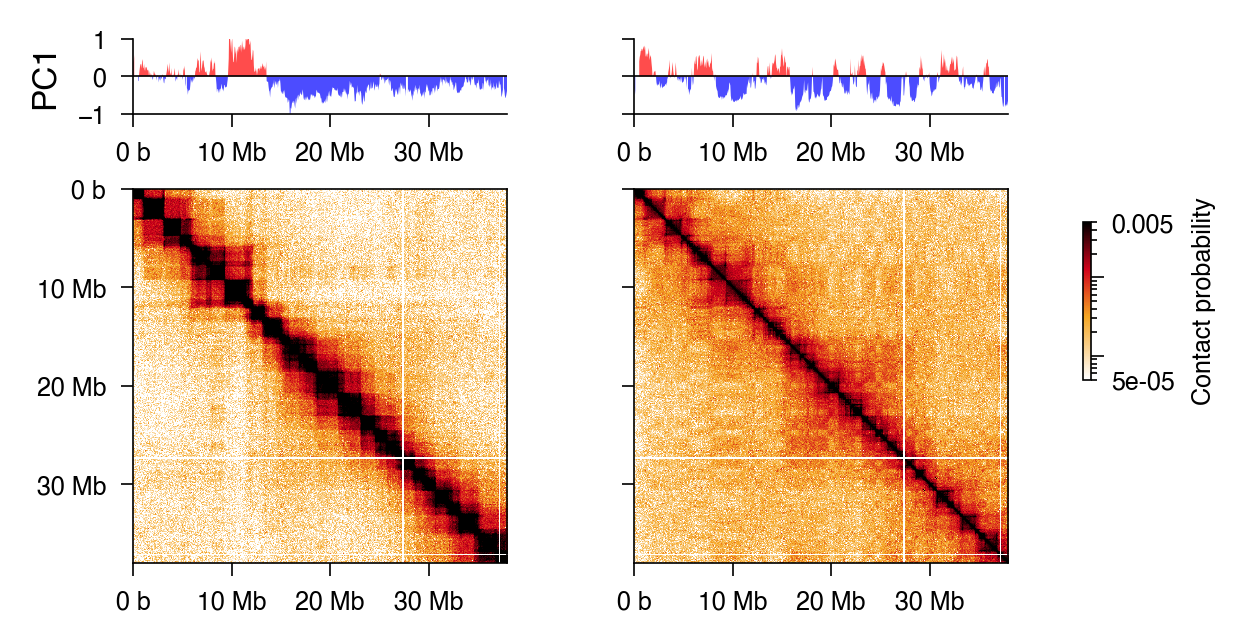

In [93]:
# Draw eigenvectors
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import EngFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

bp_formatter = EngFormatter('b')


def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1e7))
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1e7))
        ax.xaxis.tick_bottom()


class MinOneMaxFormatter(ticker.LogFormatter):
    def set_locs(self, locs=None):
        self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])
 
    def __call__(self, x, pos=None):
        if x not in [vmin, 1, vmax]:
            return ""
        else:
            return "{x:g}".format(x=x)
        

f, axs = plt.subplots(1, 2, figsize=(4, 2), sharey=True, dpi=300, constrained_layout=True)

# Create custom colormap
cmap_colors = np.array([
    [255, 255, 255, 255],
    [245, 166, 35, 255],
    [208, 2, 27, 255],
    [0, 0, 0, 255]
]) / 255
cmap_nodes = [0, 0.4, 0.7, 1]
cust_cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(cmap_nodes, cmap_colors)))

vmin, vmax = 5e-5, 0.005
norm = LogNorm(vmin=vmin, vmax=vmax)

start, end = 0, 38_000_300

reg = ('chr10', start, end)
eig_df_reg = eig_df_sw.loc[clrs[ct][rep].bins().fetch(reg).index]
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

for i, ct in enumerate(['NeuN+', 'NeuN-']):
    im = axs[i].matshow(
        clrs[ct]['merged'].matrix().fetch(reg),
        norm=norm,
        cmap=cust_cmap,
        extent=(start, end, end, start)
    );
    
    divider = make_axes_locatable(axs[i])
    format_ticks(axs[i])

    ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=axs[i])
    ax1.plot([start, end], [0,0], 'k', lw=0.4)
    
    eig = 'E2' if ct == 'NeuN+' else 'E1'
    ax1.fill_between(np.arange(start, end, res), 
                     eig_df_reg[f'{eig}.{ct}.merged'].values, 0, 
                     where=eig_df_reg[f'{eig}.{ct}.merged'].values >= 0, 
                     facecolor='red', interpolate=True, alpha=0.7)
    ax1.fill_between(np.arange(start, end, res), 
                     eig_df_reg[f'{eig}.{ct}.merged'].values, 0, 
                     where=eig_df_reg[f'{eig}.{ct}.merged'].values <= 0, 
                     facecolor='blue', interpolate=True, alpha=0.7)
    ax1.set_xlim([start, end])
    ax1.set_ylim([-1, 1])
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    if i == 0:
        ax1.set_ylabel('PC1')
    if i == 1:
        ax1.yaxis.set_ticklabels([])
    
cb = plt.colorbar(im, ax=axs[1], format=MinOneMaxFormatter(), shrink=0.3)
cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())
cb.ax.set_ylabel('Contact probability', fontsize=6, rotation=90)
        
        # ax3.set_aspect(10)
    
    
# ax2.plot(eig_df_reg[f'E1.HC.NeuN-.merged'].values, np.arange(start, end, res), label='E1', 
#          color=colors['NeuN-'], linewidth=1.2)
# ax2.plot(eig_df_reg[f'E1.HC.NeuN+.merged'].values, np.arange(start, end, res), label='E1', 
#          color=colors['NeuN+'], linewidth=1.2)
    
# plt.tight_layout()

# plt.savefig(f'hic_compartments.{res}.our.neun_minus_eig.pdf')
# plt.savefig(f'hic_compartments.{res}.Hu2021.neun_minus_eig.pdf')

## Count regions that switched compartments

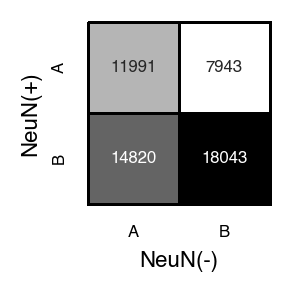

In [16]:
comp_switch = np.zeros((2, 2))
"""
comp_switch array:
         _ _
NeuN+ A |_|_|
      B |_|_|
         A B
        NeuN-
"""
comp_switch[0, 0] = \
    eig_df_sw.loc[(eig_df_sw['E1.HC.NeuN+.merged'] > 0) & 
                  (eig_df_sw['E1.HC.NeuN-.merged'] > 0)].shape[0]
comp_switch[0, 1] = \
    eig_df_sw.loc[(eig_df_sw['E1.HC.NeuN+.merged'] > 0) & 
                  (eig_df_sw['E1.HC.NeuN-.merged'] < 0)].shape[0]
comp_switch[1, 0] = \
    eig_df_sw.loc[(eig_df_sw['E1.HC.NeuN+.merged'] < 0) & 
                  (eig_df_sw['E1.HC.NeuN-.merged'] > 0)].shape[0]
comp_switch[1, 1] = \
    eig_df_sw.loc[(eig_df_sw['E1.HC.NeuN+.merged'] < 0) & 
                  (eig_df_sw['E1.HC.NeuN-.merged'] < 0)].shape[0]

plt.figure(dpi=200, figsize=(1.5, 1.5))
sns.heatmap(comp_switch, annot=True, fmt='.0f', cmap='Greys', cbar=False, 
            linewidths=1, linecolor='k',
            annot_kws={'fontsize': 6})
plt.axis('equal')
plt.xticks([0.5, 1.5], ['A', 'B'])
plt.yticks([0.5, 1.5], ['A', 'B'])
plt.tick_params(which='both', width=0)
plt.xlabel('NeuN(-)')
plt.ylabel('NeuN(+)')

plt.tight_layout()
# plt.savefig('comp_transitions.pdf')
# plt.savefig('comp_transitions.png', dpi=300)

In [11]:
eig_df_sw.shape

(61758, 8)

Text(-19.166666666666664, 0.5, 'Log( NeuN+ / NeuN- ),\nRizzardi et al.')

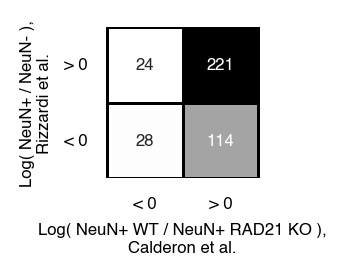

In [81]:
# OFFTOP: Calderon figure
cont_table = np.array([[24, 221], 
                       [28, 114]])

plt.figure(dpi=200, figsize=(1, 1))
sns.heatmap(cont_table, annot=True, fmt='.0f', cmap='Greys', cbar=False, 
            linewidths=1, linecolor='k',
            annot_kws={'fontsize': 6})
plt.axis('equal')
plt.xticks([0.5, 1.5], ['< 0', '> 0'])
plt.yticks([0.5, 1.5], ['> 0', '< 0'], rotation=0)
plt.tick_params(which='both', width=0)
plt.xlabel('Log( NeuN+ WT / NeuN+ RAD21 KO ),\nCalderon et al.', fontsize=6)
plt.ylabel('Log( NeuN+ / NeuN- ),\nRizzardi et al.', fontsize=6)

# plt.savefig('cont_table.calderon_rizzardi.pdf')

# Saddle plot

In [12]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens_sad = bf.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bf.make_chromarms(hg38_chromsizes,  hg38_cens_sad)
hg38_arms = hg38_arms.loc[~hg38_arms['name'].isin(['chr13_p', 'chr14_p', 'chr15_p', 'chr21_p', 
                                                   'chr22_p', 'chrY_p', 'chrY_q', 'chrM_p'])]\
                     .reset_index(drop=True)
# hg38_arms = hg38_arms.loc[hg38_arms['chrom'].isin(['chr4'])]\
#                      .reset_index(drop=True)
hg38_arms.head()

chrom      start        end    name
0  chr1          0  123479591  chr1_p
1  chr1  123479591  248956422  chr1_q
2  chr2          0   93139351  chr2_p
3  chr2   93139351  242193529  chr2_q
4  chr3          0   92214016  chr3_p

In [13]:
# compute expected
cvd = {ct: {} for ct in cts}

for ct in cts:
    for rep in reps:
        cvd[ct][rep] = expected_cis_cache(
            clrs[ct][rep],
            view_df=hg38_arms,
            smooth=False,
            nproc=5
        )

## Whole-genome saddle

In [14]:
interaction_sum = {ct: {} for ct in cts}
interaction_count = {ct: {} for ct in cts}
saddle_nbins = 50

for ct in cts:
#     for rep in ['merged']:
    for rep in reps:
        interaction_sum[ct][rep], interaction_count[ct][rep] = saddle_cache(
                clrs[ct][rep],
                cvd[ct][rep],
#                 eig_df_sw[['chrom','start','end', f'E1.{ct}.{rep}']],
                eig_df_sw[['chrom','start','end', f'E1.NeuN-.{rep}']],
                'cis',
                n_bins=saddle_nbins,
                qrange=(0.025, 0.975),
                view_df=hg38_arms,
                min_diag=4,
        )

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_di

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:214: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


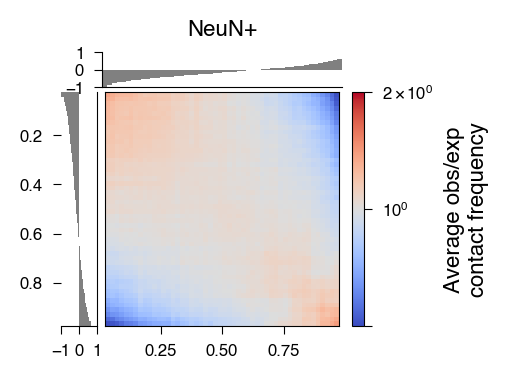

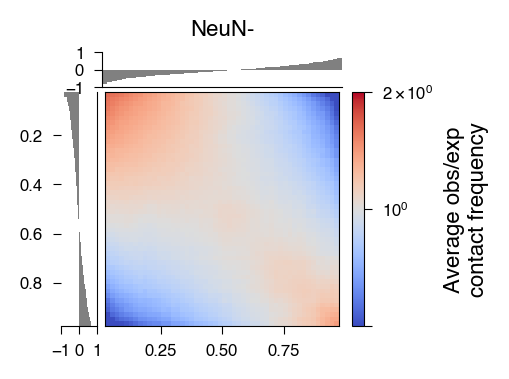

In [96]:
# plt.figure(dpi=150)
# plt.title('HCplus')
# colors = {'NeuN+': sns.color_palette()[4], 
#           'NeuN-': sns.color_palette()[1]}

sp ={}
for ct in cts:
    for rep in ['merged']:
        plot, sp[ct] =  saddleplot(
           eig_df[['chrom','start','end', f'E1.{ct}.{rep}']],
           interaction_sum[ct][rep] / interaction_count[ct][rep],
           saddle_nbins,
           cmap='RdBu_r',
           qrange=(0.025, 0.975),
           cbar_kws={'label':'Average obs/exp\ncontact frequency'},
           fig_kws={'dpi': 200, 'figsize': [2, 2]},
           title=ct,
           scale='log',
           vmin=1/2, vmax=2,
#                        fig=f,
           margin_kws={'facecolor': 'grey'}
        );
#             plt.savefig(f"saddle_plot.HC.{ct}.merged.our.neun_minus_eig.pdf")

### Saddle ratio

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:214: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


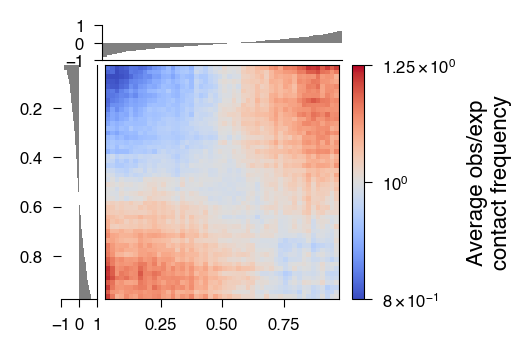

In [102]:
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

sp ={}

m_neu = interaction_sum['NeuN+']['merged'] / interaction_count['NeuN+']['merged']
m_gli = interaction_sum['NeuN-']['merged'] / interaction_count['NeuN-']['merged']

plot, sp[ct] =  saddleplot(
   eig_df[['chrom','start','end', f'E1.NeuN-.merged']],
   m_neu / m_gli,
   saddle_nbins,
   cmap='RdBu_r',
   qrange=(0.025, 0.975),
   cbar_kws={'label':'Average obs/exp\ncontact frequency'},
   fig_kws={'dpi': 200, 'figsize': [2, 2]},
   title='',
   scale='log',
   vmin=1/1.25, vmax=1.25,
#                        fig=f,
   margin_kws={'facecolor': 'grey'}
);

# plt.savefig(f"saddle_ratio.HC.merged.Hu2021.neun_minus_eig.pdf")
# plt.savefig(f"saddle_ratio.Hu2021.neun_minus_eig.pdf")

<Figure size 900x600 with 0 Axes>

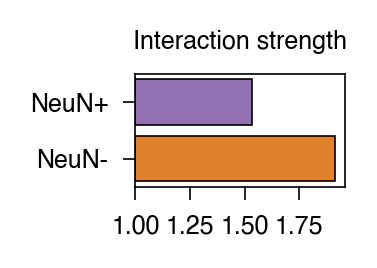

In [101]:
## Plot interaction strength (merged)
plt.figure(dpi=150)
figs = []
labels = ['Intra / Inter']
x = np.arange(len(labels))
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1],
          'ODC': sns.color_palette("magma", 8)[7],
          'ASC': sns.color_palette("magma", 8)[6],
          'EN': sns.color_palette("magma", 8)[3],
          'IN': sns.color_palette("magma", 8)[4]}
nbins_corner = saddle_nbins // 5

ct_arr, group_arr, strnth_arr = [], [], []
for ct in cts:
    ct_arr.extend([ct])

    mat = (interaction_sum[ct][rep] / interaction_count[ct][rep])[1:-1, 1:-1]
    AB = np.nanmean(mat[:nbins_corner, -nbins_corner:])
    AABB = np.nanmean([mat[-nbins_corner:, -nbins_corner:], 
                       mat[:nbins_corner, :nbins_corner]])

    group_arr.append(u'Intra / Inter')
    strnth_arr.append(AABB / AB - 1)

plot_df = pd.DataFrame(data={
    'ct': ct_arr,
    'group': group_arr,
    'strnth': strnth_arr
})

plt.figure(figsize=(0.9, 0.5), dpi=300)
sns.barplot(data=plot_df, x='strnth', y='ct', ci=None, orient='h',
            linewidth=0.4, edgecolor='k', 
            palette=colors, 
            left=1)
# plt.xlim([1, 1.8])
plt.xticks([1, 1.25, 1.5, 1.75])

plt.xlabel('')
plt.ylabel('')
# plt.title()
plt.title('Interaction strength', fontsize=6)
# plt.savefig('interaction_strength.tian2023.neun_minus_eig.pdf', bbox_inches='tight')
# plt.savefig('interaction_strength.Hu2021.neun_minus_eig.pdf', bbox_inches='tight')

<Figure size 900x600 with 0 Axes>

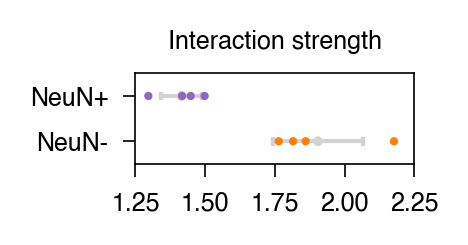

In [87]:
## Plot interaction strength (reps)
plt.figure(dpi=150)
figs = []
labels = ['Intra / Inter']
x = np.arange(len(labels))
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}
nbins_corner = saddle_nbins // 5

ct_arr, group_arr, strnth_arr = [], [], []
for ct in cts:
    for rep in reps:
        if rep == 'merged':
            continue
        ct_arr.extend([ct])
        rep_arr.extend([rep])

        mat = (interaction_sum[ct][rep] / interaction_count[ct][rep])[1:-1, 1:-1]
        AB = np.nanmean(mat[:nbins_corner, -nbins_corner:])
        AABB = np.nanmean([mat[-nbins_corner:, -nbins_corner:], 
                           mat[:nbins_corner, :nbins_corner]])

        group_arr.append(u'Intra / Inter')
        strnth_arr.append(AABB / AB)

plot_df = pd.DataFrame(data={
    'ct': ct_arr,
#     'reps': rep_arr,
    'group': group_arr,
    'strnth': strnth_arr
})

plt.figure(figsize=(1.2, 0.4), adpi=300)
sns.pointplot(data=plot_df, x='strnth', y='ct', 
              linestyles='', ci='sd', color='lightgrey', errwidth=1, capsize=0.1)
sns.swarmplot(data=plot_df, x='strnth', y='ct', orient='h',
              s=2, palette=colors)
# plt.xlim([1, 2.8])
plt.xticks([1.25, 1.5, 1.75, 2, 2.25])
# plt.xticks([1, 1.5, 2])

plt.xlabel('')
plt.ylabel('')
# plt.title()
plt.title('Interaction strength', fontsize=6)
plt.savefig('interaction_strength.our_reps.neun_minus_eig.pdf', bbox_inches='tight')
# plt.savefig('interaction_strength.Hu2021.neun_minus_eig.pdf', bbox_inches='tight')

## Per-chromosomal analysis

In [29]:
interaction_sum = {'HC': {'NeuN+': {}, 'NeuN-': {}}, 
                   'SZ': {'NeuN+': {}, 'NeuN-': {}}}
interaction_count = {'HC': {'NeuN+': {}, 'NeuN-': {}}, 
                     'SZ': {'NeuN+': {}, 'NeuN-': {}}}

# Per-chromosome arm
for phen in phens:
    for ct in ('NeuN+', 'NeuN-'):
        for chromarm in hg38_arms['name'].values:
            print(chromarm)
            interaction_sum[phen][ct][chromarm], interaction_count[phen][ct][chromarm] = cooltools.saddle(
                    clrs[phen][ct]['merged'],
                    cvd[phen][ct]['merged'].loc[cvd[phen][ct]['merged']['region1'] == chromarm],
                    eig_df_sw[['chrom','start','end', f'E1.{phen}.NeuN-.merged']],
                    'cis',
                    n_bins=100,
                    qrange=(0.025, 0.975),
                    # view_df=view_df,
                    view_df=hg38_arms.loc[hg38_arms['name'] == chromarm].reset_index(drop=True),
                    min_diag=4,
                    # max_diag=16
            )

chr1_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr1_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr2_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr2_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr3_p
chr3_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr4_p
chr4_q
chr5_p
chr5_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr6_p
chr6_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr7_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr7_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr8_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr8_q
chr9_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr9_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr10_p
chr10_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr11_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr11_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr12_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr12_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr13_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr14_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr15_q
chr16_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr16_q
chr17_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr17_q
chr18_p
chr18_q
chr19_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr19_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr20_p
chr20_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr21_q
chr22_q
chrX_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chrX_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr1_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr1_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr2_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr2_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr3_p
chr3_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr4_p
chr4_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr5_p
chr5_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr6_p
chr6_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr7_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr7_q
chr8_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr8_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr9_p
chr9_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr10_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr10_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr11_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr11_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr12_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr12_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr13_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr14_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr15_q
chr16_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr16_q
chr17_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr17_q
chr18_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr18_q
chr19_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr19_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr20_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr20_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr21_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chr22_q
chrX_p


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


chrX_q


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat


/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


<Figure size 900x600 with 0 Axes>

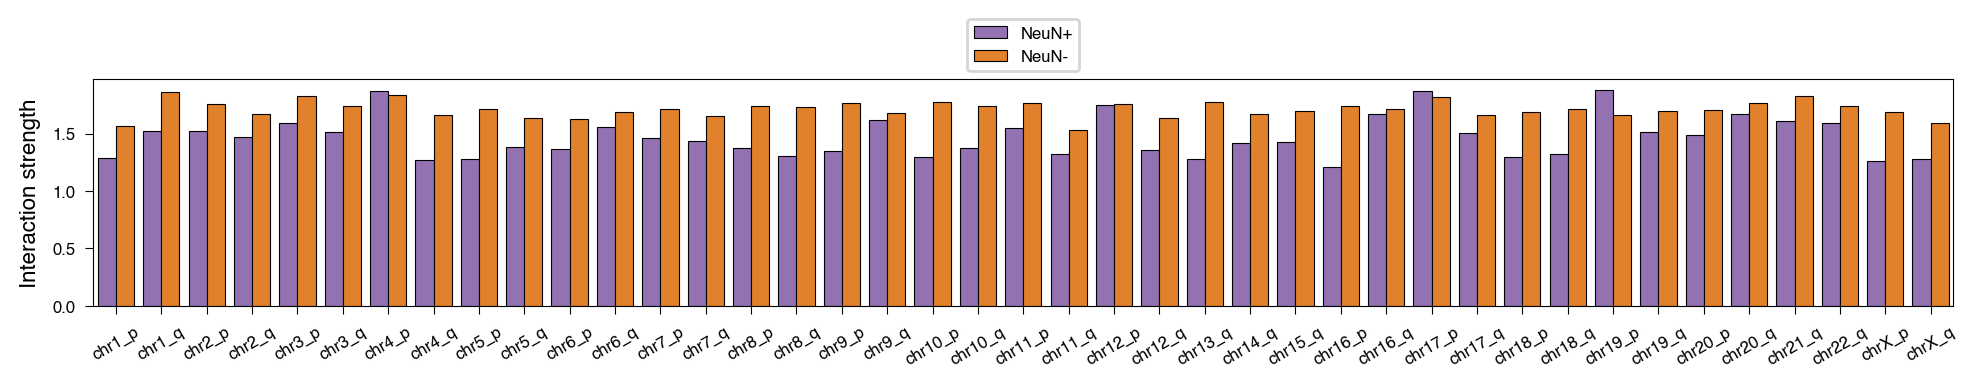

In [31]:
## Plot interaction strength (merged, by arms)
plt.figure(dpi=150)
figs = []
labels = ['Intra / Inter']
x = np.arange(len(labels))
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

ct_arr, phen_arr, rep_arr, group_arr, strnth_arr = [], [], [], [], []
for phen in phens:
    for chromarm in hg38_arms['name'].values:
        for ct in ('NeuN+', 'NeuN-'):
            ct_arr.extend([ct])
            phen_arr.extend([phen])
            rep_arr.extend([chromarm])
            
            mat = (interaction_sum[phen][ct][chromarm] / interaction_count[phen][ct][chromarm])[1:-1, 1:-1]
            AB = np.nanmean(mat[:20, -20:])
            AABB = np.nanmedian([mat[-20:, -20:], mat[:20, :20]])
            
            group_arr.append(u'Intra / Inter')
            strnth_arr.append(AABB / AB)

plot_df = pd.DataFrame(data={
    'ct': ct_arr,
    'phen': phen_arr,
    'chromarm': rep_arr,
    'group': group_arr,
    'strnth': strnth_arr
})

plt.figure(figsize=(12, 1.5), dpi=200)

sns.barplot(data=plot_df, y='strnth', x='chromarm', hue='ct', ci=None, 
            linewidth=0.4, edgecolor='k', palette=colors)
plt.legend(loc="lower center", bbox_to_anchor=[0.5, 1], fontsize=6)

plt.xlabel('')
plt.ylabel('Interaction strength')
plt.xticks(rotation=30);
# plt.savefig('interaction_strength.our.per-chrom.pdf', bbox_inches='tight')
# plt.savefig('interaction_strength.our.per-chrom.png', dpi=300, bbox_inches='tight')

Text(-24.166666666666664, 0.5, 'Log$_{2}$ $\\left(\\dfrac{NeuN+}{NeuN-}\\right)$')

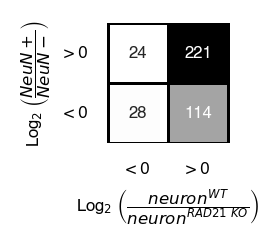

In [176]:
# OFFTOP: Calderon figure
cont_table = np.array([[24, 221], 
                       [28, 114]])

plt.figure(dpi=200, figsize=(0.8, 0.8))
sns.heatmap(cont_table, annot=True, fmt='.0f', cmap='Greys', cbar=False, 
            linewidths=1, linecolor='k',
            annot_kws={'fontsize': 6})
plt.axis('equal')
plt.xticks([0.5, 1.5], ['< 0', '> 0'])
plt.yticks([0.5, 1.5], ['> 0', '< 0'], rotation=0)
plt.tick_params(which='both', width=0)
# plt.xlabel('Log( NeuN+ WT / NeuN+ RAD21 KO ),\nCalderon et al.', fontsize=6)
# plt.ylabel('Log( NeuN+ / NeuN- ),\nRizzardi et al.', fontsize=6)

plt.xlabel(r'Log$_{2}$ $\left(\dfrac{neuron^{WT}}{neuron^{RAD21\ KO}}\right)$', fontsize=6)
plt.ylabel(r'Log$_{2}$ $\left(\dfrac{NeuN+}{NeuN-}\right)$', fontsize=6)

# plt.savefig('cont_table.calderon_rizzardi.pdf')

# Autocorrelation plot

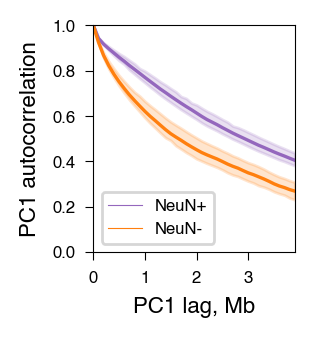

In [57]:
from scipy.stats import spearmanr

res=100000
max_lag = 40


def autocorrelation(df, valcol, max_lag=max_lag):
    chroms = df["chrom"].unique()

    def r(h):
        v1, v2 = [], []
        for chrom in chroms:
            pc_chrom = df.loc[df['chrom'] == chrom, valcol]
            n = len(pc_chrom)
            v1.extend(pc_chrom.tolist()[:n-h])
            v2.extend(pc_chrom.tolist()[h:])

        corr, _ = spearmanr(v1, v2, nan_policy='omit')
        return corr

    x = np.arange(max_lag)
    autocor = [r(loc) for loc in x]
    return autocor


fig, ax = plt.subplots(figsize=(1.3, 1.5), dpi=200)
# eig_labs = {'E1.HC.NeuN+': 'NeuN+.HC', 'E1.SZ.NeuN+': 'NeuN+.SZ', 
#             'E1.HC.NeuN-': 'NeuN-.HC', 'E1.SZ.NeuN-': 'NeuN-.SZ',}
eig_cols = eig_df.drop(columns=['chrom', 'start', 'end']).columns
linestyles = {'HC': "solid", 'SZ': "dashed"}
colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

# for eig in eig_cols:
lag = []
cts = []
autocors = []
for ct in ('NeuN+', 'NeuN-'):
    for phen in phens:
        for rep in ['R1', 'R2', 'R3', 'R4']:
            autocor = autocorrelation(eig_df[['chrom', f'E1.{phen}.{ct}.{rep}']], 
                                      valcol=f'E1.{phen}.{ct}.{rep}')
            lag.extend(np.arange(max_lag) * res / 1e6)
            cts.extend([ct] * max_lag)
            autocors.extend(autocor)

autocor_df = pd.DataFrame(data={
    'lag': lag,
    'ct': cts,
    'autocor': autocors
})

ax.set_xlabel('PC1 lag, Mb')
ax.set_ylabel('PC1 autocorrelation')
sns.lineplot(data=autocor_df, x='lag', y='autocor', hue='ct', linewidth=1.2, palette=colors)
ax.legend(title=False, fontsize=6, loc='lower left')
# if "label" in kwds:
#     ax.legend()
# ax.grid()
    
ax.set_ylim([0, 1])
ax.set_xlim([0, 3.9])

# plt.plot([4, 4], [0, 1], 'k--', alpha=0.5)
# plt.savefig('autocorr.HC.rep_err.pdf')

Text(0, 0.5, 'PC1 autocorrelation at 1Mb distance')

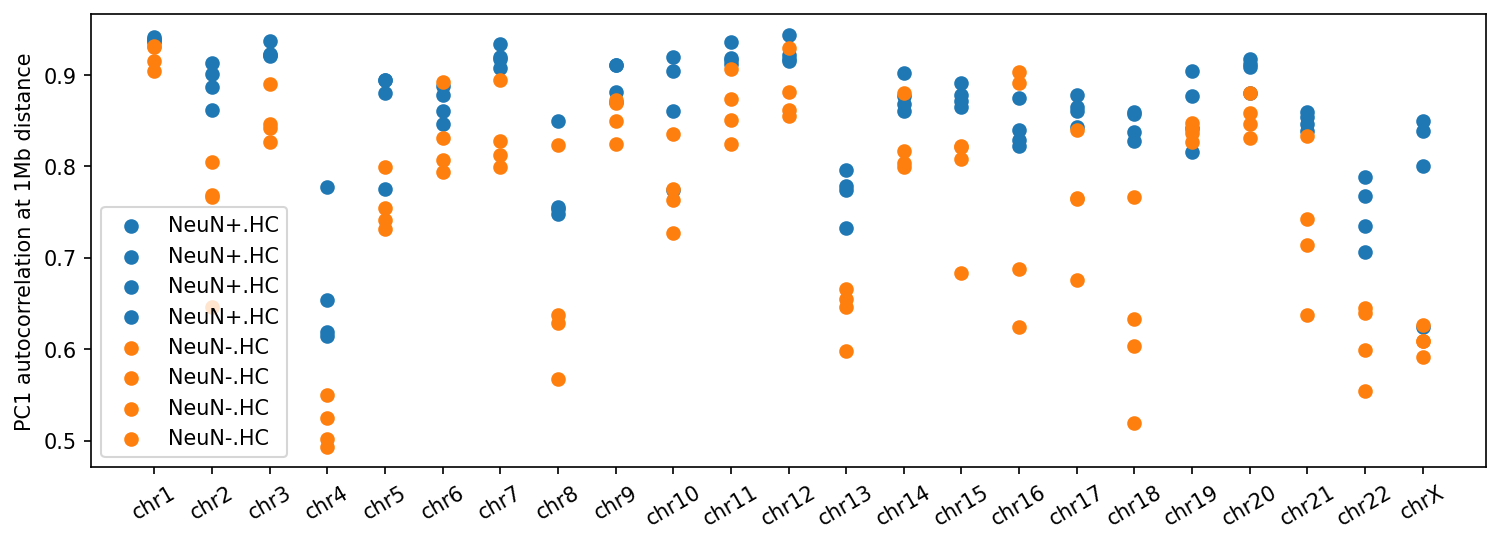

In [583]:
# Per-chromosome autocorrelation at 1Mb
chrom_names = clrs['HC']['NeuN+'][rep].chromnames[:23]

ac_1mb = {phen: {ct: {rep:
    np.zeros((len(chrom_names)))
 for rep in reps} for ct in ('NeuN+', 'NeuN-')} for phen in ('HC', 'SZ')}

for i, chrom in enumerate(chrom_names):
    for phen in phens:
        for ct in ('NeuN+', 'NeuN-'):
            for rep in reps:
                ac_1mb[phen][ct][rep][i] = eig_df.loc[eig_df['chrom'] == chrom, 
                                                      f'E1.{phen}.{ct}.{rep}'].autocorr(4)

plt.figure(dpi=150, figsize=(12, 4))
i=0
for ct in ('NeuN+', 'NeuN-'):
    for phen in phens:
        for rep in ['R1', 'R2', 'R3', 'R4']:
            plt.scatter(np.arange(len(chrom_names)), ac_1mb[phen][ct][rep], 
                        label=ct + '.' + phen, 
                        color=colors[ct]
                       )
            i+=1
        
plt.legend()
plt.xticks(np.arange(len(chrom_names)), chrom_names, rotation = 30);
plt.ylabel('PC1 autocorrelation at 1Mb distance')

## Per-chromosome autorrelation split by polycomb interaction abundance

In [241]:
# load fithic data
fithic = {
    ct: pd.read_pickle(f"../2022.10.07/fithic.100kb.{ct}.all.qvalue_0.05.pkl")
    for ct in ["NeuN+", 'NeuN-']
}

fithic['NeuN+'].head()

chrom1  start1    end1 chrom2    start2      end2       q-value
0   chr1       0  100000  chr19    300000    400000  1.032217e-02
1   chr1  800000  900000  chr16         0    100000  1.566392e-03
2   chr1  800000  900000  chr16    100000    200000  2.540313e-06
3   chr1  800000  900000  chr16  90000000  90100000  7.070092e-13
4   chr1  800000  900000  chr19    300000    400000  2.058502e-04

In [244]:
# Overlap fithic interactions with k27me3
k27_bed_mrg = {
    'NeuN+': pbt('dong2022/H3K27me3_Neuron.tab.broadPeak')\
                .filter(lambda pk: (float(pk[8]) >= 1.3) & (len(pk) > 10000)).saveas(),
    'NeuN-': pbt('dong2022/H3K27me3_NonNeuron.tab.broadPeak')\
                .filter(lambda pk: (float(pk[8]) >= 1.3) & (len(pk) > 10000)).saveas()
}

k27_fh = {}

for ct in ['NeuN+', 'NeuN-']:
    k27_df = k27_bed_mrg[ct].cut([0,1,2,6]).to_dataframe(names=['chrom', 'start', 'end', 'signalValue'])
    pair_sites = k27_hic_signal(k27_df, clrs['HC'][ct]['merged'], cvd['HC'][ct]['merged'],
                                view_df=hg38_arms, min_sep=200000)
    k27_fh[ct] = pair_sites.merge(fithic[ct][['chrom1', 'start1', 'end1', 
                                              'chrom2', 'start2', 'end2', 'q-value']], 
                                  on=['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2'])
    k27_fh[ct]['log_dist'] = np.log10( k27_fh[ct]['start2'] - k27_fh[ct]['start1'] )
    k27_fh[ct]['dist'] = k27_fh[ct]['start2'] - k27_fh[ct]['start1']
    k27_fh[ct]['ct'] = ct

print(k27_fh["NeuN+"].shape, 
      k27_fh["NeuN-"].shape)
k27_fh['NeuN+'].head()

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/snipping.py:230: UserWarning: Some features do not have view regions assigned! Some snips will be empty.
  "Some features do not have view regions assigned! Some snips will be empty."
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/snipping.py:230: UserWarning: Some features do not have view regions assigned! Some snips will be empty.
  "Some features do not have view regions assigned! Some snips will be empty."
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/snipping.py:230: UserWarning: Some features do not have view regions assigned! Some snips will be empty.
  "Some features do not have view regions assigned! Some snips will be empty."
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/cooltools/api/snipping.py:230: UserWarning: Some features do not have view regions assigned! Some snips will be empty.
  "Some features do not have view regions assig

(1564, 16) (284, 16)


chrom1    start1      end1  signalValue1  length1 chrom2    start2  \
0  chr11  14900000  15000000       4.26447    10468  chr11  16600000   
1  chr11  20100000  20200000       4.94531    13713  chr11  31700000   
2  chr11  20500000  20600000       4.78004    12532  chr11  31700000   
3  chr11  20600000  20700000       4.78004    12532  chr11  31700000   
4  chr11  20100000  20200000       4.94531    13713  chr11  31800000   

       end2  signalValue2  length2   obs_exp       obs       q-value  \
0  16700000       3.75332    14029  3.606242  0.014641  3.161770e-81   
1  31800000       4.74137    24328  4.318344  0.001873  2.562453e-14   
2  31800000       4.74137    24328  4.678634  0.002098  2.218000e-16   
3  31800000       4.74137    24328  2.207676  0.000953  6.024661e-03   
4  31900000       4.74137    24328  5.581361  0.002410  5.355247e-24   

   log_dist      dist     ct  
0  6.230449   1700000  NeuN+  
1  7.064458  11600000  NeuN+  
2  7.049218  11200000  NeuN+  
3  7.045323  11100000  NeuN+  
4  7.068186  11700000  NeuN+

In [266]:
clrs['HC'][ct]['merged'].chromsizes['chr1']

248956422

<BarContainer object of 13 artists>

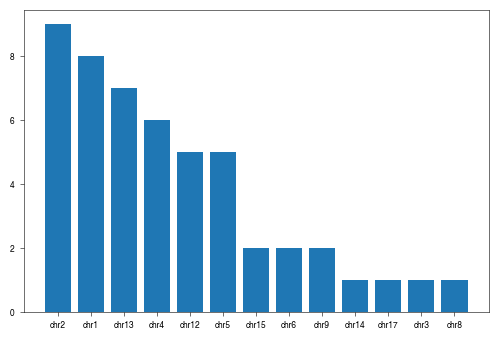

In [292]:
# Get top 100 neuronal polycomb interactions

fh_top = k27_fh['NeuN+'].loc[k27_fh['NeuN+']['chrom1'] == k27_fh['NeuN+']['chrom2']]\
                        .sort_values(by='obs_exp', ascending=False)\
                        .head(50)\
                        .groupby('chrom1', as_index=False)\
                        .size()
# fh_top['chromsize'] = fh_top['chrom1'].apply(lambda chrom: clrs['HC'][ct]['merged'].chromsizes[chrom])
# fh_top['size'] = fh_top['size'] / fh_top['chromsize'] ** 2
fh_top.sort_values(by='size', ascending=False, inplace=True)

plt.figure(dpi=100)
plt.bar(x=fh_top['chrom1'], height=fh_top['size'])

Text(0, 0.5, 'PC1 autocorrelation at 1Mb distance')

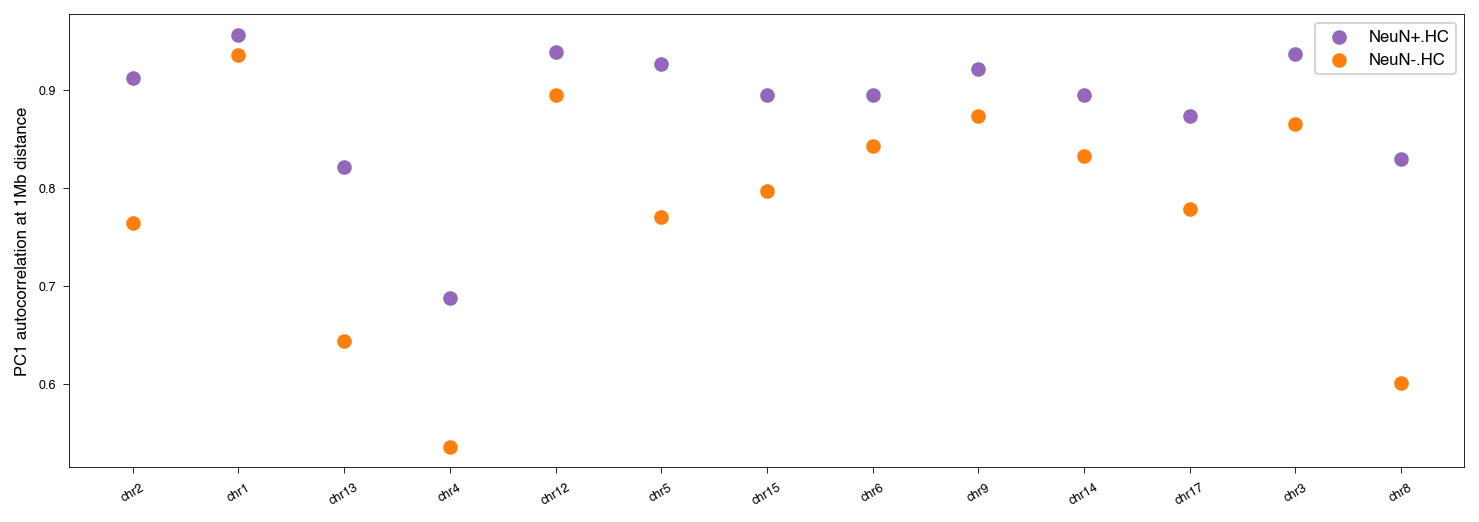

In [293]:
# Per-chromosome autocorrelation at 1Mb
chrom_names = fh_top['chrom1']

ac_1mb = {phen: {ct: {rep:
    np.zeros((len(chrom_names)))
 for rep in reps} for ct in ('NeuN+', 'NeuN-')} for phen in ('HC', 'SZ')}

for i, chrom in enumerate(chrom_names):
    for phen in phens:
        for ct in ('NeuN+', 'NeuN-'):
            for rep in ['merged']:
                ac_1mb[phen][ct][rep][i] = eig_df.loc[eig_df['chrom'] == chrom, 
                                                      f'E1.{phen}.{ct}.{rep}'].autocorr(4)

plt.figure(dpi=150, figsize=(12, 4))
i=0
for ct in ('NeuN+', 'NeuN-'):
    for phen in phens:
        for rep in ['merged']:
            plt.scatter(np.arange(len(chrom_names)), ac_1mb[phen][ct][rep], 
                        label=ct + '.' + phen, 
                        color=colors[ct]
                       )
            i+=1
        
plt.legend()
plt.xticks(np.arange(len(chrom_names)), chrom_names, rotation = 30);
plt.ylabel('PC1 autocorrelation at 1Mb distance')

Text(0, 0.5, 'PC1 autocorrelation at 1Mb distance')

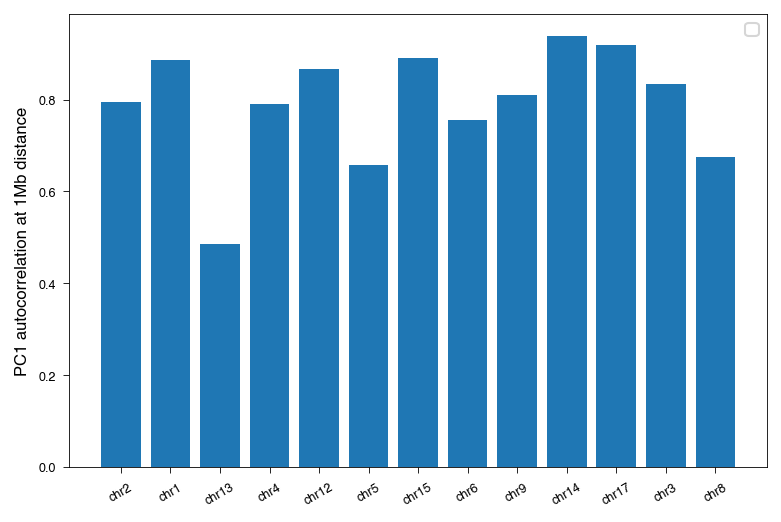

In [294]:
# Per-chromosome autocorrelation at 1Mb
chrom_names = fh_top['chrom1']

cor_chrom = {phen:  {rep: np.zeros((len(chrom_names)))
             for rep in reps} for phen in ('HC', 'SZ')}

for i, chrom in enumerate(chrom_names):
    for phen in phens:
        for rep in ['merged']:
            v1 = eig_df.dropna().loc[eig_df['chrom'] == chrom, f'E1.{phen}.NeuN+.{rep}']
            v2 = eig_df.dropna().loc[eig_df['chrom'] == chrom, f'E1.{phen}.NeuN-.{rep}']
            cor_chrom[phen][rep][i] = v1.corr(v2, method='spearman')

plt.figure(dpi=150)
i=0
for phen in phens:
    for rep in ['merged']:
        plt.bar(x=chrom_names, height=cor_chrom[phen][rep])
        i+=1
        
plt.legend()
plt.xticks(np.arange(len(chrom_names)), chrom_names, rotation = 30);
plt.ylabel('PC1 autocorrelation at 1Mb distance')

/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/ipletenev/.conda/envs/hic/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


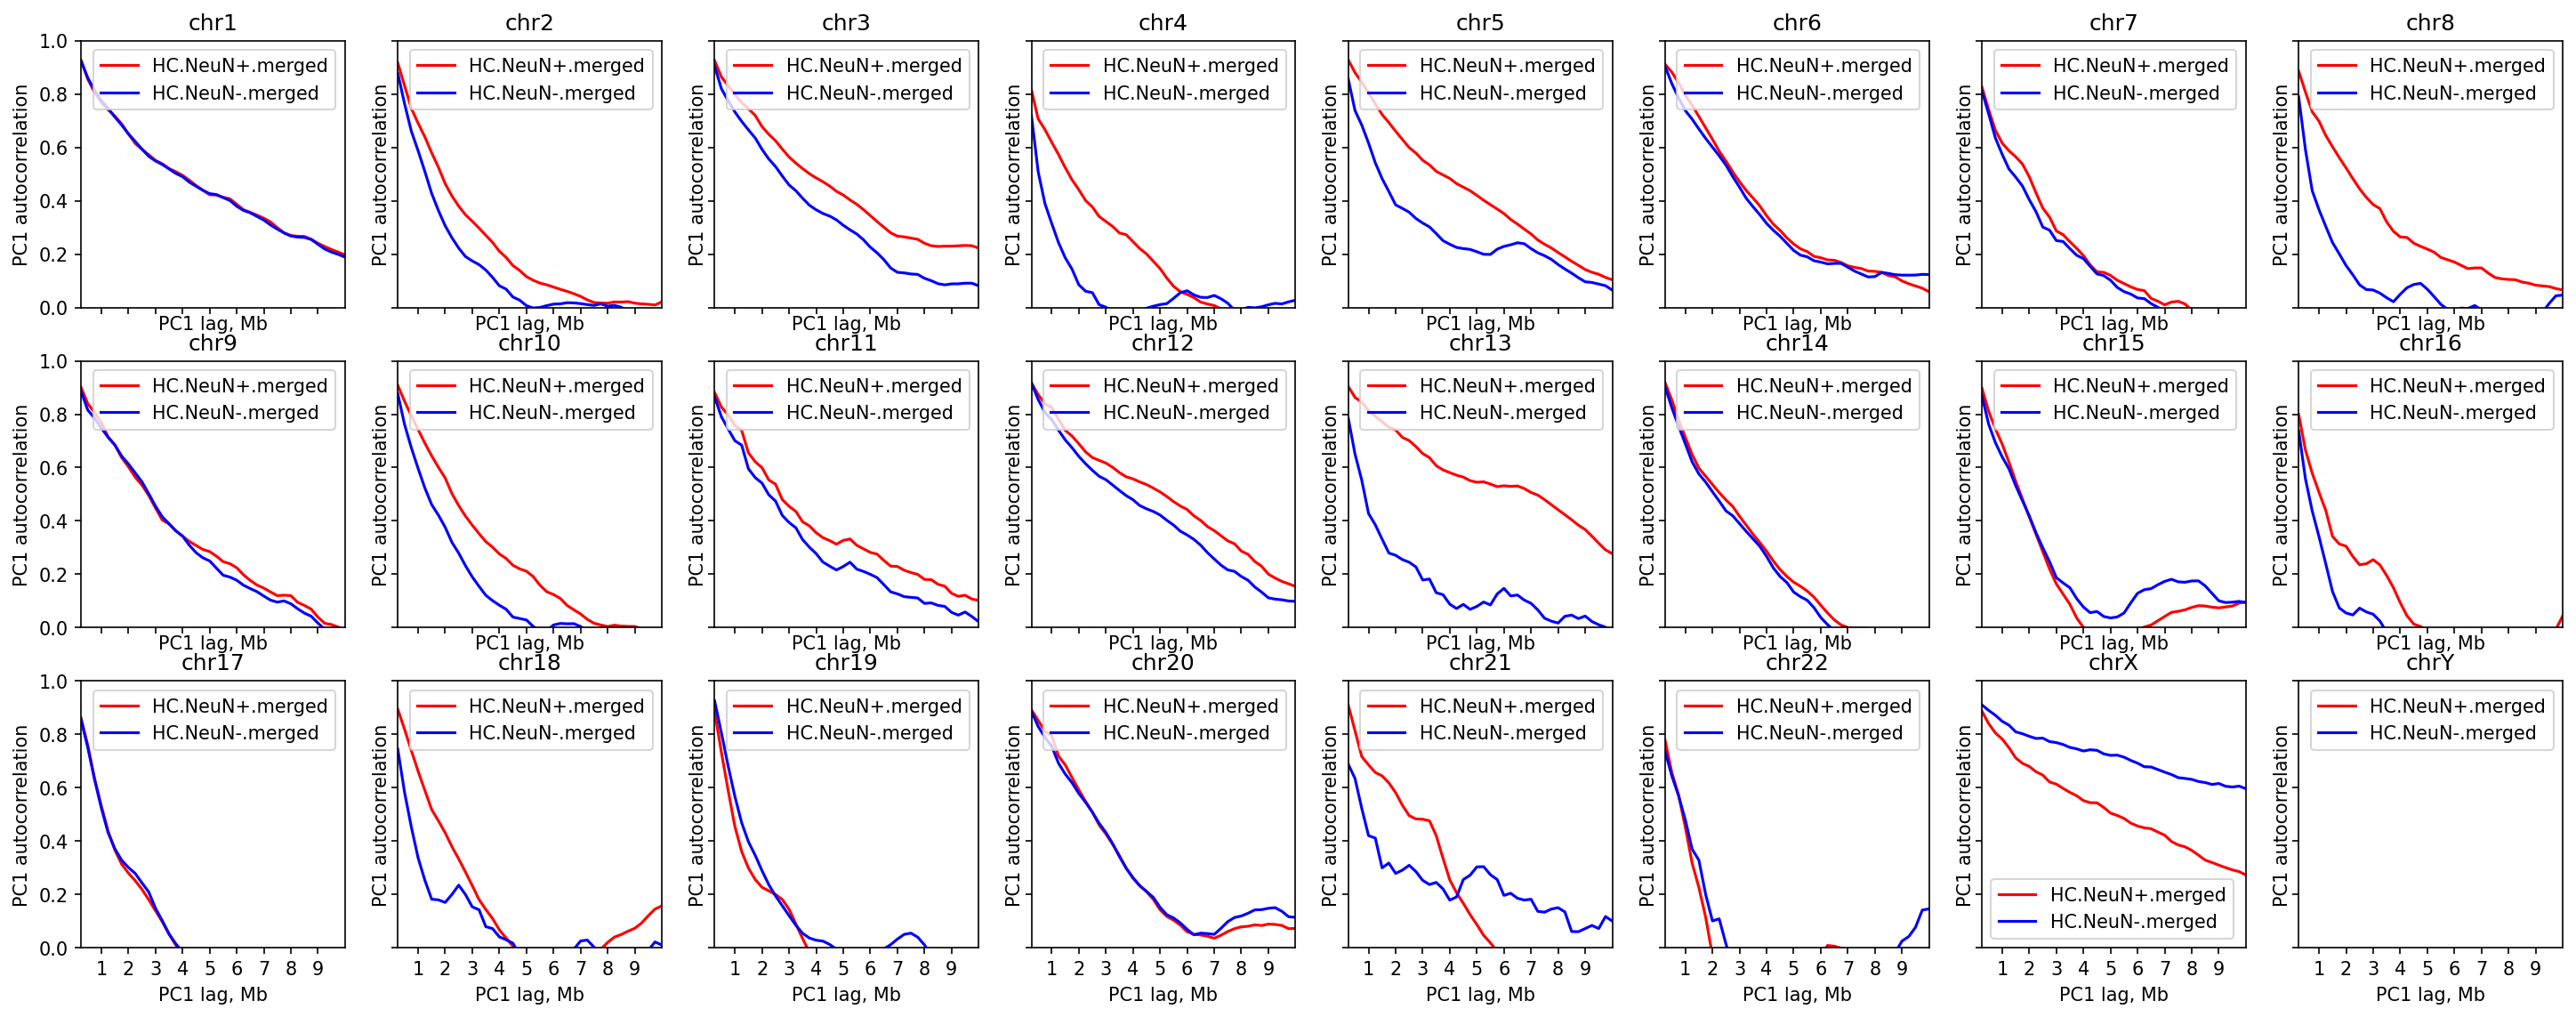

In [40]:
def autocorrelation(series, lower=0.95, upper=0.99, ax=None, **kwds):
    # require scipy
    import scipy
    import matplotlib.pyplot as plt

    n = len(series)
    
    data = np.asarray(series)
    if ax is None:
        ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))
    mean = np.nanmean(data)
    c0 = np.nansum((data - mean) ** 2) / float(n)

    def r(h):
        return np.nansum((data[: n - h] - mean) * (data[h:] - mean)) / float(n) / c0

    x = np.arange(n) + 1
    y = [r(loc) for loc in x]

    ax.set_xlabel('PC1 lag, Mb')
    ax.set_ylabel('PC1 autocorrelation')
    ax.plot(x, y, **kwds)
    if "label" in kwds:
        ax.legend()
    ax.grid()
    return ax

chroms = clrs['HC']['NeuN+']['merged'].chromnames[:24]

fig, axs = plt.subplots(3, 8, dpi=150, figsize=(24, 9), sharex=True, sharey=True)
# eig_labs = {'E1.HC.NeuN+': 'NeuN+.HC', 'E1.SZ.NeuN+': 'NeuN+.SZ', 
#             'E1.HC.NeuN-': 'NeuN-.HC', 'E1.SZ.NeuN-': 'NeuN-.SZ',}
eig_cols = eig_df.drop(columns=['chrom', 'start', 'end']).columns
colors = {'NeuN+': 'red', 'NeuN-': 'blue'}
linestyles = {'HC': "solid", 'SZ': "dashed"}

# for eig in eig_cols:
for ct in ('NeuN+', 'NeuN-'):
    for phen in phens:
        for rep in reps:
            for i, chrom in enumerate(chroms):
                autocorrelation(eig_df.loc[eig_df['chrom'] == chrom, f'E1.{phen}.{ct}.{rep}'], 
                                label=f'{phen}.{ct}.{rep}', ax=axs.flat[i], 
                                color=colors[ct], 
                                linestyle=linestyles[phen])

                axs.flat[i].set_ylim([0, 1])
                axs.flat[i].set_title(chrom)
                axs.flat[i].set_xticks(ticks=np.arange(0, 40, 4), 
                                       labels=[int(i) for i in np.arange(0, 40, 4) * res / 1e6])
                axs.flat[i].set_xlim([1, 40])

# plt.plot([4, 4], [0, 1], 'k--', alpha=0.5)
# plt.savefig('autocorr.perchr.china.HC.merged.png', dpi=300)

In [139]:
eig_df.head()

chrom    start      end  E1.HC.NeuN+  E1.SZ.NeuN+  E1.HC.NeuN-  E1.SZ.NeuN-
12  chr1  3000000  3250000     0.969178     0.974166     0.968025     0.859714
15  chr1  3750000  4000000     0.813742     0.742088     0.890897     0.729646
16  chr1  4000000  4250000     0.473965     0.620622     0.370616     0.448477
17  chr1  4250000  4500000     0.528085     0.655191     0.290528     0.467072
18  chr1  4500000  4750000     0.494208     0.495360     0.466976     0.549143

# compartment length distribution

In [1001]:
phen_lst, ct_lst, comp_lst, length_lst = [], [], [], []

for phen in ('HC', 'SZ'):
    for ct in ('NeuN+', 'NeuN-'):
        comp_A_df = pbt.from_dataframe(eig_df.loc[eig_df[f'E1.{phen}.{ct}'] > 0]).merge().to_dataframe()
        comp_A_df['length'] = comp_A_df['end'] - comp_A_df['start']
        
        comp_B_df = pbt.from_dataframe(eig_df.loc[eig_df[f'E1.{phen}.{ct}'] < 0]).merge().to_dataframe()
        comp_B_df['length'] = comp_B_df['end'] - comp_B_df['start']
        
        N_A, N_B = comp_A_df.shape[0], comp_B_df.shape[0]
        print(N_A, N_B)

        phen_lst.extend([phen] * (N_A + N_B))
        ct_lst.extend([ct] * (N_A + N_B))
        
        comp_lst.extend(['A'] * N_A)
        comp_lst.extend(['B'] * N_B)
        
        length_lst.extend(comp_A_df['length'].values.tolist())
        length_lst.extend(comp_B_df['length'].values.tolist())
        
comp_size_df = pd.DataFrame(data={
    'phen': phen_lst,
    'ct': ct_lst,
    'comp': comp_lst,
    'size': length_lst
})
comp_size_df.head()

563 461
775 727
582 500
744 693


phen     ct comp     size
0   HC  NeuN+    A   250000
1   HC  NeuN+    A  2500000
2   HC  NeuN+    A  6250000
3   HC  NeuN+    A  3000000
4   HC  NeuN+    A  8250000

<AxesSubplot:xlabel='phen', ylabel='size'>

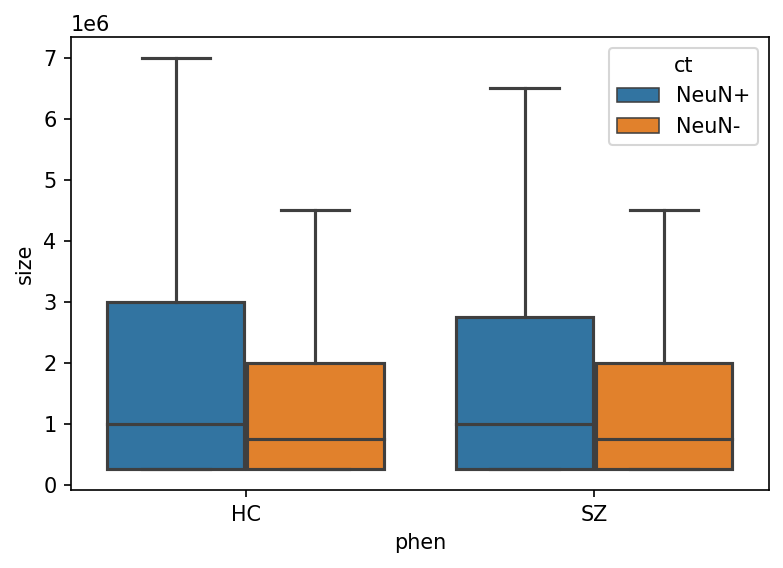

In [1010]:
plt.figure(dpi=150)
sns.boxplot(data=comp_size_df, y='size', x='phen', hue='ct', showfliers = False)
# plt.yscale('log')

Text(0.5, 0, 'Chromatin compartment')

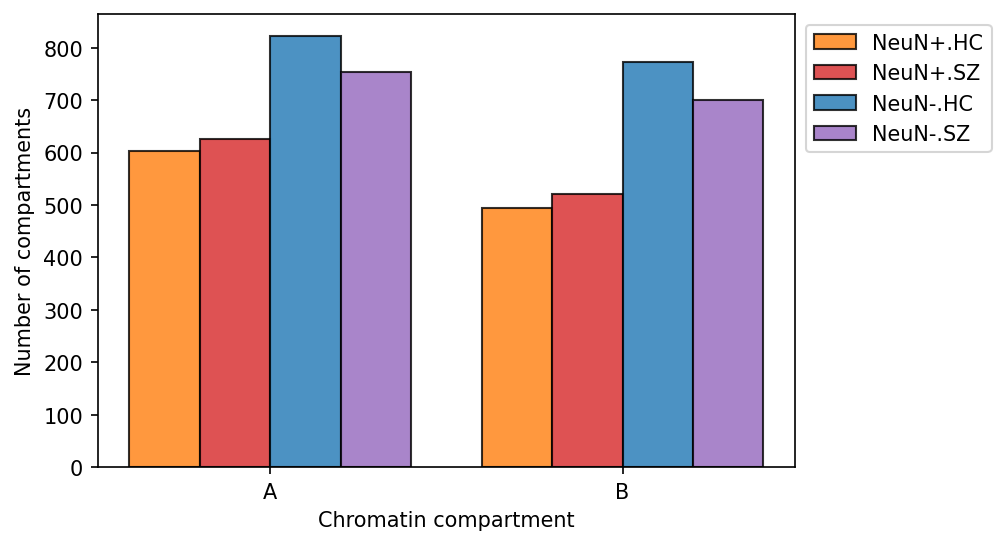

In [621]:
plt.figure(dpi=150)
labels = ['A', 'B']
x = np.arange(len(labels))
width = 0.2

i=0
for ct in ('NeuN+', 'NeuN-'):
    for phen in ('HC', 'SZ'):
        N_A = pbt.from_dataframe(eig_df.loc[eig_df[f'E1.{phen}.{ct}'] > 0]).merge().to_dataframe().shape[0]
        N_B = pbt.from_dataframe(eig_df.loc[eig_df[f'E1.{phen}.{ct}'] < 0]).merge().to_dataframe().shape[0]
        
        bars = plt.bar(height = [N_A, N_B], 
                       x = x + (-3+2*i) * width/2, width=width, 
                       label=f'{ct}.{phen}', color=palette[i], alpha=0.8)
        
        for bar in bars:
            bar.set_edgecolor("black")
        
        i+=1

plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(x, labels)
plt.ylabel('Number of compartments')
plt.xlabel("Chromatin compartment")

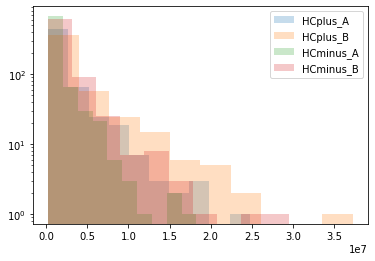

In [24]:
plt.hist(HCplus_A['length'], alpha=0.25, log=True, label='HCplus_A')
plt.hist(HCplus_B['length'], alpha=0.25, log=True, label='HCplus_B')
plt.hist(HCminus_A['length'], alpha=0.25, log=True, label='HCminus_A')
plt.hist(HCminus_B['length'], alpha=0.25, log=True, label='HCminus_B')
plt.legend()

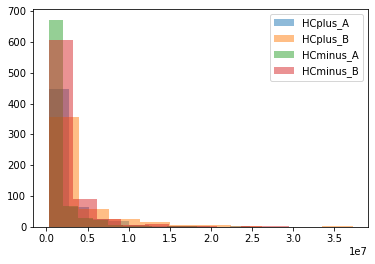

In [26]:
plt.hist(HCplus_A['length'], alpha=0.5, label='HCplus_A')
plt.hist(HCplus_B['length'], alpha=0.5, label='HCplus_B')
plt.hist(HCminus_A['length'], alpha=0.5, label='HCminus_A')
plt.hist(HCminus_B['length'], alpha=0.5, label='HCminus_B')
plt.legend()

In [239]:
HC_Apl_Bmin = pbt.from_dataframe(eig_df.loc[(eig_df['E1.HC.NeuN+'] > 0) & (eig_df['E1.HC.NeuN-'] < 0)]).merge().slop(b=1, g='chrom.sizes')
HC_Bpl_Amin = pbt.from_dataframe(eig_df.loc[(eig_df['E1.HC.NeuN+'] < 0) & (eig_df['E1.HC.NeuN-'] > 0)]).merge().slop(b=1, g='chrom.sizes')

HC_Apl = pbt.from_dataframe(eig_df.loc[eig_df['E1.HC.NeuN+'] > 0]).merge().slop(b=1, g='chrom.sizes')
HC_Bpl = pbt.from_dataframe(eig_df.loc[eig_df['E1.HC.NeuN+'] < 0]).merge().slop(b=1, g='chrom.sizes')

HC_Apl_Bmin = HC_Apl_Bmin.intersect(HC_Bpl, wa=True, v=True).slop(b=-1, g='chrom.sizes').to_dataframe()
HC_Apl_Bmin['length'] = HC_Apl_Bmin['end'] - HC_Apl_Bmin['start']

HC_Bpl_Amin = HC_Bpl_Amin.intersect(HC_Apl, wa=True, v=True).slop(b=-1, g='chrom.sizes').to_dataframe()
HC_Bpl_Amin['length'] = HC_Bpl_Amin['end'] - HC_Bpl_Amin['start']


SZ_Apl_Bmin = pbt.from_dataframe(eig_df.loc[(eig_df['E1.SZ.NeuN+'] > 0) & (eig_df['E1.SZ.NeuN-'] < 0)]).merge().slop(b=1, g='chrom.sizes')
SZ_Bpl_Amin = pbt.from_dataframe(eig_df.loc[(eig_df['E1.SZ.NeuN+'] < 0) & (eig_df['E1.SZ.NeuN-'] > 0)]).merge().slop(b=1, g='chrom.sizes')

SZ_Apl = pbt.from_dataframe(eig_df.loc[eig_df['E1.SZ.NeuN+'] > 0]).merge().slop(b=1, g='chrom.sizes')
SZ_Bpl = pbt.from_dataframe(eig_df.loc[eig_df['E1.SZ.NeuN+'] < 0]).merge().slop(b=1, g='chrom.sizes')

SZ_Apl_Bmin = SZ_Apl_Bmin.intersect(SZ_Bpl, wa=True, v=True).slop(b=-1, g='chrom.sizes').to_dataframe()
SZ_Apl_Bmin['length'] = SZ_Apl_Bmin['end'] - SZ_Apl_Bmin['start']

SZ_Bpl_Amin = SZ_Bpl_Amin.intersect(SZ_Apl, wa=True, v=True).slop(b=-1, g='chrom.sizes').to_dataframe()
SZ_Bpl_Amin['length'] = SZ_Bpl_Amin['end'] - SZ_Bpl_Amin['start']

Text(0.5, 1.0, 'SZ')

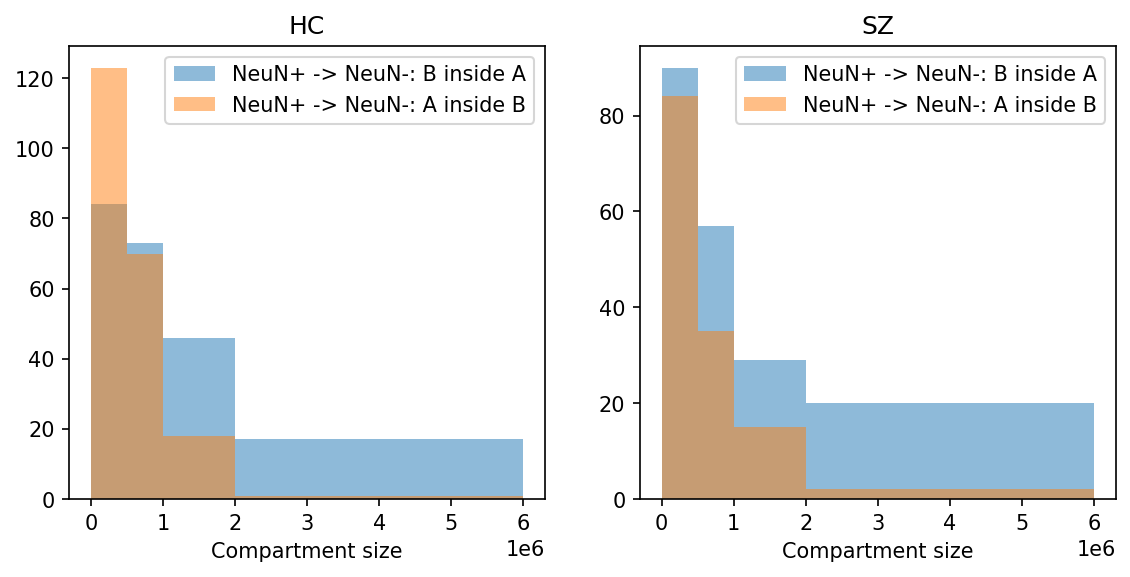

In [240]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4), dpi=150)

ax1.hist(HC_Apl_Bmin['length'], alpha=0.5, label='NeuN+ -> NeuN-: B inside A', 
         bins=(0, 0.5e6, 1e6, 2e6, 6e6))
ax1.hist(HC_Bpl_Amin['length'], alpha=0.5, label='NeuN+ -> NeuN-: A inside B', 
         bins=(0, 0.5e6, 1e6, 2e6, 6e6))

ax2.hist(SZ_Apl_Bmin['length'], alpha=0.5, label='NeuN+ -> NeuN-: B inside A', 
         bins=(0, 0.5e6, 1e6, 2e6, 6e6))
ax2.hist(SZ_Bpl_Amin['length'], alpha=0.5, label='NeuN+ -> NeuN-: A inside B', 
         bins=(0, 0.5e6, 1e6, 2e6, 6e6))

ax1.legend()
ax2.legend()

ax1.set_xlabel('Compartment size')
ax2.set_xlabel('Compartment size')

ax1.set_title('HC')
ax2.set_title('SZ')

# Do compartments correlate with DE genes and histone active marks? 

## Genes

In [11]:
# Load DE genes
gen = {
    'NeuN+': pbt('rizzardi.pc_DE_genes.upr_in_neu.bed'),
    'NeuN-': pbt('rizzardi.pc_DE_genes.upr_in_gli.bed'),
}

gen['NeuN+'].head()

chr1	960583	965719	KLHL17	1.81434524821276	+
 chr1	998961	1000172	HES4	0.688899316976641	-
 chr1	1203507	1206592	TNFRSF18	2.46071171101427	-
 chr1	1216930	1232031	SDF4	3.19233881411361	-
 chr1	1471764	1497848	ATAD3B	2.36754629940133	+
 chr1	1512161	1534685	ATAD3A	2.83659689025593	+
 chr1	1534777	1540624	TMEM240	3.15611524794125	-
 chr1	1598011	1600135	FNDC10	1.13456396133486	-
 chr1	1615453	1630605	MIB2	1.04215958904012	+
 chr1	1915107	1917296	CALML6	0.902077980549597	+
 

In [21]:
# Extract TSS
chrom_sizes_path = 'chrom.sizes'
tss = {}

for ct in ('NeuN+', 'NeuN-'):
    tss[ct] = gen[ct].flank(g=chrom_sizes_path, s=True, l=1, r=0)

tss['NeuN+'].head()

chr1	960582	960583	KLHL17	1.81434524821276	+
 chr1	1000172	1000173	HES4	0.688899316976641	-
 chr1	1206592	1206593	TNFRSF18	2.46071171101427	-
 chr1	1232031	1232032	SDF4	3.19233881411361	-
 chr1	1471763	1471764	ATAD3B	2.36754629940133	+
 chr1	1512160	1512161	ATAD3A	2.83659689025593	+
 chr1	1540624	1540625	TMEM240	3.15611524794125	-
 chr1	1600135	1600136	FNDC10	1.13456396133486	-
 chr1	1615452	1615453	MIB2	1.04215958904012	+
 chr1	1915106	1915107	CALML6	0.902077980549597	+
 

In [76]:
# get compartments
comp = {phen: {ct: {rep: {
    'A': pbt.from_dataframe(eig_df.loc[eig_df[f'E1.{phen}.{ct}.{rep}'] > 0]).merge(),
    'B': pbt.from_dataframe(eig_df.loc[eig_df[f'E1.{phen}.{ct}.{rep}'] < 0]).merge()
} for rep in reps} for ct in ('NeuN+', 'NeuN-')} for phen in ['HC']}

comp['HC']['NeuN+'][rep]['A'].head()

chr1	1800000	1900000
 chr1	2900000	3500000
 chr1	3600000	6100000
 chr1	6200000	12800000
 chr1	13400000	16500000
 chr1	16600000	16700000
 chr1	16900000	21400000
 chr1	21500000	25300000
 chr1	25400000	30300000
 chr1	30500000	46800000
 

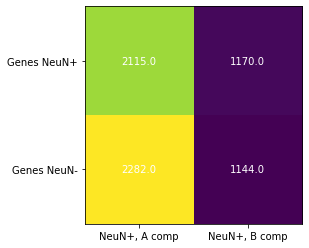

In [71]:
plus_comps = np.zeros((2,2))

plus_comps[0, 0] = tss['NeuN+'].intersect(comp['HC']['NeuN+']['A'], u=True).count()
plus_comps[0, 1] = tss['NeuN+'].intersect(comp['HC']['NeuN+']['B'], u=True).count()
plus_comps[1, 0] = tss['NeuN-'].intersect(comp['HC']['NeuN+']['A'], u=True).count()
plus_comps[1, 1] = tss['NeuN-'].intersect(comp['HC']['NeuN+']['B'], u=True).count()

fig, ax = plt.subplots()
im = ax.imshow(plus_comps)

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, plus_comps[i, j],
                       ha="center", va="center", color="w")
        
ax.set_xticks([0, 1], ['NeuN+, A comp', 'NeuN+, B comp'])
ax.set_yticks([0, 1], ['Genes NeuN+', 'Genes NeuN-'])

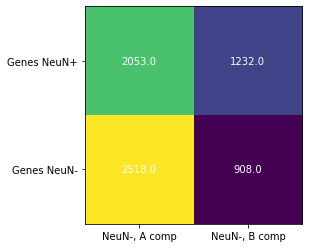

In [72]:
plus_comps = np.zeros((2,2))

plus_comps[0, 0] = tss['NeuN+'].intersect(comp['HC']['NeuN-']['A'], u=True).count()
plus_comps[0, 1] = tss['NeuN+'].intersect(comp['HC']['NeuN-']['B'], u=True).count()
plus_comps[1, 0] = tss['NeuN-'].intersect(comp['HC']['NeuN-']['A'], u=True).count()
plus_comps[1, 1] = tss['NeuN-'].intersect(comp['HC']['NeuN-']['B'], u=True).count()

fig, ax = plt.subplots()
im = ax.imshow(plus_comps)

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, plus_comps[i, j],
                       ha="center", va="center", color="w")
        
ax.set_xticks([0, 1], ['NeuN-, A comp', 'NeuN-, B comp'])
ax.set_yticks([0, 1], ['Genes NeuN+', 'Genes NeuN-'])

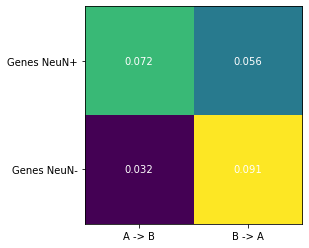

In [73]:
comp_AB = comp['HC']['NeuN+']['A'].intersect(comp['HC']['NeuN-']['B'])
comp_BA = comp['HC']['NeuN+']['B'].intersect(comp['HC']['NeuN-']['A'])

plus_comps = np.zeros((2,2))

plus_comps[0, 0] = tss['NeuN+'].intersect(comp_AB, u=True).count() / tss['NeuN+'].count()
plus_comps[0, 1] = tss['NeuN+'].intersect(comp_BA, u=True).count() / tss['NeuN+'].count()
plus_comps[1, 0] = tss['NeuN-'].intersect(comp_AB, u=True).count() / tss['NeuN-'].count()
plus_comps[1, 1] = tss['NeuN-'].intersect(comp_BA, u=True).count() / tss['NeuN-'].count()

fig, ax = plt.subplots()
im = ax.imshow(plus_comps)

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, round(plus_comps[i, j], 3),
                       ha="center", va="center", color="w")
        
ax.set_xticks([0, 1], ['A -> B', 'B -> A'])
ax.set_yticks([0, 1], ['Genes NeuN+', 'Genes NeuN-'])

[0.5589041095890411, 0.6287215411558669]
[0.29010654490106547, 0.2276707530647986]
[0.08493150684931507, 0.037361354349095155]
[0.06605783866057839, 0.10624635143023935]
[0.5643835616438356, 0.6293053123175715]
[0.306544901065449, 0.2542323409223584]
[0.07701674277016743, 0.036485697606538234]
[0.052054794520547946, 0.07997664915353181]


Text(0.5, 1.0, 'SZ compartments')

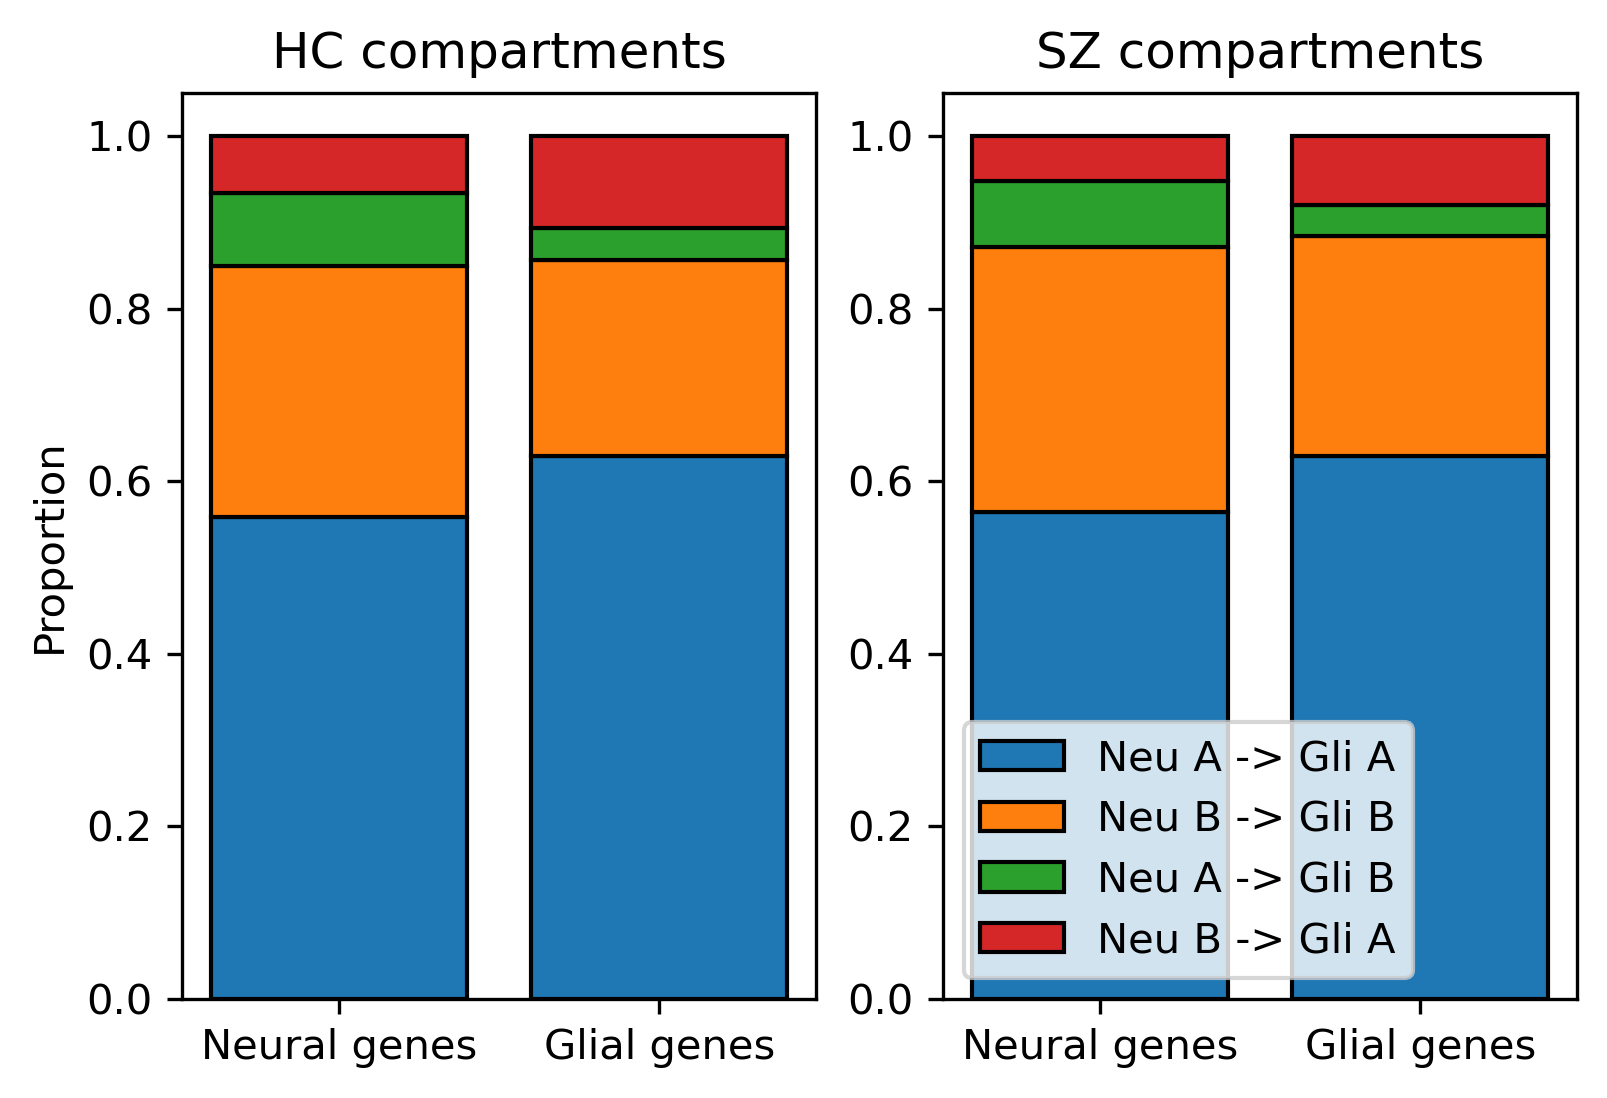

In [161]:
# comp_AB = comp['HC']['NeuN+']['A'].intersect(comp['HC']['NeuN-']['B'])
# comp_BA = comp['HC']['NeuN+']['B'].intersect(comp['HC']['NeuN-']['A'])
# comp_AA = comp['HC']['NeuN+']['A'].intersect(comp['HC']['NeuN-']['A'])
# comp_BB = comp['HC']['NeuN+']['B'].intersect(comp['HC']['NeuN-']['B'])

comp_pl_min = {
    phen: {
        'AA': comp[phen]['NeuN+']['A'].intersect(comp[phen]['NeuN-']['A']),
        'BB': comp[phen]['NeuN+']['B'].intersect(comp[phen]['NeuN-']['B']),
        'AB': comp[phen]['NeuN+']['A'].intersect(comp[phen]['NeuN-']['B']),
        'BA': comp[phen]['NeuN+']['B'].intersect(comp[phen]['NeuN-']['A']),
    } for phen in ('HC', 'SZ')
}

na_gene = { phen: {
    ct: tss[ct].intersect(comp_pl_min[phen]['AA'], v=True)\
               .intersect(comp_pl_min[phen]['BB'], v=True)\
               .intersect(comp_pl_min[phen]['AB'], v=True)\
               .intersect(comp_pl_min[phen]['BA'], v=True)\
               .count()
    for ct in ('NeuN+', 'NeuN-')
    } for phen in ('HC', 'SZ')
}

clr_labels = ['Neu A -> Gli A', 'Neu B -> Gli B', 
              'Neu A -> Gli B', 'Neu B -> Gli A']
xlabels = ['Neural genes', 'Glial genes']

fig, axs = plt.subplots(1, 2, dpi=300)

for j, phen in enumerate(('HC', 'SZ')):
    tot_arr = np.array([0, 0])
    for i, grp in enumerate(['AA', 'BB', 'AB', 'BA']):
        arr = [
            tss['NeuN+'].intersect(comp_pl_min[phen][grp], u=True).count() / (tss['NeuN+'].count() - na_gene[phen]['NeuN+']) ,
            tss['NeuN-'].intersect(comp_pl_min[phen][grp], u=True).count() / (tss['NeuN-'].count() - na_gene[phen]['NeuN-']),
        ]
        print(arr)
        bars = axs[j].bar(xlabels, arr, label=clr_labels[i], bottom=tot_arr)
        for bar in bars:
            bar.set_edgecolor("black")
        tot_arr = tot_arr + arr
    
plt.legend()
axs[0].set_ylabel('Proportion')
axs[0].set_title('HC compartments')
axs[1].set_title('SZ compartments')

## Active marks

In [45]:
# Load chip-seq
hist = {
    'k4me3': pd.read_excel("girdhar2018.diff_histone_marks.xlsx", sheet_name=0, skiprows=3),
    'k27ac': pd.read_excel("girdhar2018.diff_histone_marks.xlsx", sheet_name=1, skiprows=1)
}
hist['k27ac'].head()

/home/ipletenev/miniconda3/envs/hic/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


GeneID Chrom  Start    End     logFC        PValue   Genename  \
0  peak_1  chr1  10002  10156 -0.213739  7.326571e-02    DDX11L1   
1  peak_2  chr1  11572  12154 -0.345938  4.532004e-03    DDX11L1   
2  peak_3  chr1  12766  22970 -1.275447  3.208215e-22  MIR6859-1   
3  peak_4  chr1  24511  30857  0.044267  6.171846e-01     WASH7P   
4  peak_5  chr1  34411  35192  1.984971  1.697925e-23    FAM138F   

       Celltype        Annotation  
0            NS  Promoter (1-2kb)  
1  Non-neuronal  Promoter (<=1kb)  
2  Non-neuronal  Promoter (<=1kb)  
3            NS  Promoter (<=1kb)  
4      Neuronal  Promoter (<=1kb)

In [46]:
# convert chip-seq to bed
hist_bed = {
    mark: {
        "NeuN+": pbt.from_dataframe(df.loc[df['Celltype'] == 'Neuronal',     ['Chrom', 'Start', 'End']]),
        "NeuN-": pbt.from_dataframe(df.loc[df['Celltype'] == 'Non-neuronal', ['Chrom', 'Start', 'End']]),
    }
    for mark, df in hist.items()
}

hist_bed['k4me3']["NeuN+"].head()

chr1	10219	10387
 chr1	441768	442756
 chr1	540170	541208
 chr1	713110	715786
 chr1	804979	805885
 chr1	839177	841023
 chr1	845267	846018
 chr1	856239	856634
 chr1	933753	937752
 chr1	967662	973498
 

Text(0, 0.5, 'Jaccard coef.')

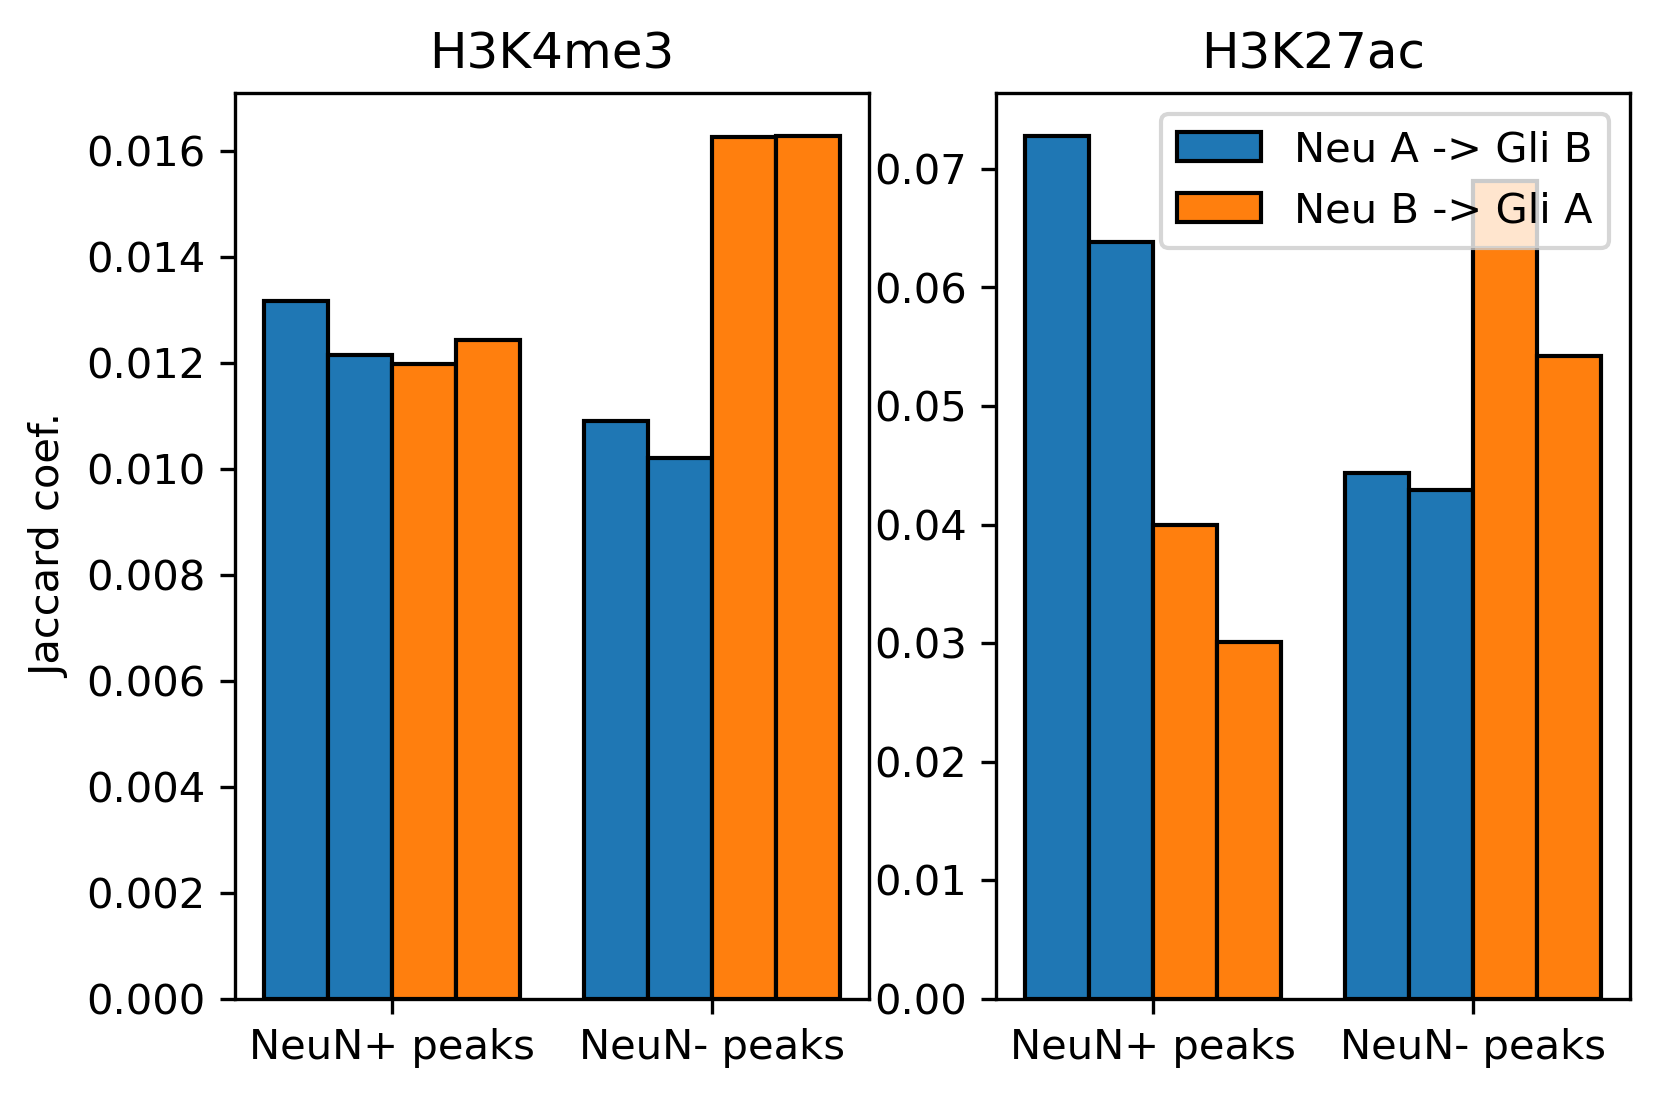

In [162]:
fig, axs = plt.subplots(1, 2, dpi=300)

xlabs = ['NeuN+ peaks', "NeuN- peaks"]
leg_labs = ['Neu A -> Gli B', 'Neu B -> Gli A']
titles = ['H3K4me3', 'H3K27ac']
width = 0.2  # the width of the bars
x = np.array([0, 1])

for i, mark in enumerate(('k4me3', 'k27ac')):
    # A-> B
    arr = [
        hist_bed[mark]["NeuN+"].sort().jaccard(comp_pl_min['HC']['AB'].sort())['jaccard'],
        hist_bed[mark]["NeuN+"].sort().jaccard(comp_pl_min['SZ']['AB'].sort())['jaccard'],
        hist_bed[mark]["NeuN-"].sort().jaccard(comp_pl_min['HC']['AB'].sort())['jaccard'],
        hist_bed[mark]["NeuN-"].sort().jaccard(comp_pl_min['SZ']['AB'].sort())['jaccard']
    ]
    bars = axs[i].bar([-3*width/2, -width/2, 1-3*width/2, 1-width/2], 
                      arr, width, label=leg_labs[0])
    
    for bar in bars:
        bar.set_edgecolor("black")
    
    # B-> A
    arr = [
        hist_bed[mark]["NeuN+"].sort().jaccard(comp_pl_min['HC']['BA'].sort())['jaccard'],
        hist_bed[mark]["NeuN+"].sort().jaccard(comp_pl_min['SZ']['BA'].sort())['jaccard'],
        hist_bed[mark]["NeuN-"].sort().jaccard(comp_pl_min['HC']['BA'].sort())['jaccard'],
        hist_bed[mark]["NeuN-"].sort().jaccard(comp_pl_min['SZ']['BA'].sort())['jaccard'],
    ]
    bars = axs[i].bar([width/2, 3*width/2, 1+width/2, 1+3*width/2], 
                      arr, width, label=leg_labs[1])
    
    for bar in bars:
        bar.set_edgecolor("black")
    
    axs[i].set_xticks(x, xlabs)
    axs[i].set_title(titles[i])
    
plt.legend()
axs[0].set_ylabel("Jaccard coef.")

# Long DE gene within switched compartment (PCDH9-like)

In [85]:
long_gen = { ct: bed.filter(lambda gene: len(gene) >= 750000).saveas() for ct, bed in gen.items()}
long_gen['NeuN+'].count()

79

In [92]:
# Overlap long DE genes with switched compartments
long_gen['NeuN+'].intersect(comp_pl_min['HC']['AB'], u=True, f=1).head()

chr4	142023159	142847432	INPP4B	1.60525889330996	-
 chr6	68635281	69390571	ADGRB3	5.01132410421039	+
 chr11	132414976	133532501	OPCML	1.57794831491703	-
 chr12	129071724	129904025	TMEM132D	2.02384701419891	-
 

In [93]:
# Overlap long DE genes with switched compartments
long_gen['NeuN-'].intersect(comp_pl_min['HC']['BA'], u=True, f=1).head()

chr3	114314499	115147288	ZBTB20	-4.58254639088322	-
 chr13	66302833	67230445	PCDH9	-3.05768643583888	-
 

# Loops overlap neu genes more frequently than glial genes

In [127]:
# Read loops
loops = pd.read_pickle("../2022.07.01/merged_loops.bedpe.pkl")
# loops['name'] = np.arange(loops.shape[0])
# loops['score'] = np.arange(loops.shape[0])
# loops['strand1'] = '+'
# loops['strand2'] = '+'

loops.head()

chrom1     start1       end1 chrom2     start2       end2
0  chr10  123575000  123600000  chr10  123950000  123975000
1  chr10   91000000   91025000  chr10   91250000   91275000
2  chr10  109875000  109900000  chr10  110100000  110125000
3  chr11    3850000    3875000  chr11    4050000    4075000
4  chr11   30350000   30375000  chr11   30850000   30875000

In [132]:
pbt.from_dataframe(loops).pair_to_bed(tss['NeuN+']).count() / tss['NeuN+'].count()

0.06245181187355436

In [131]:
pbt.from_dataframe(loops).pair_to_bed(tss['NeuN-']).count() / tss['NeuN-'].count()

0.052801992528019925

Text(0.5, 1.0, 'Fraction of DE genes overlapping dots')

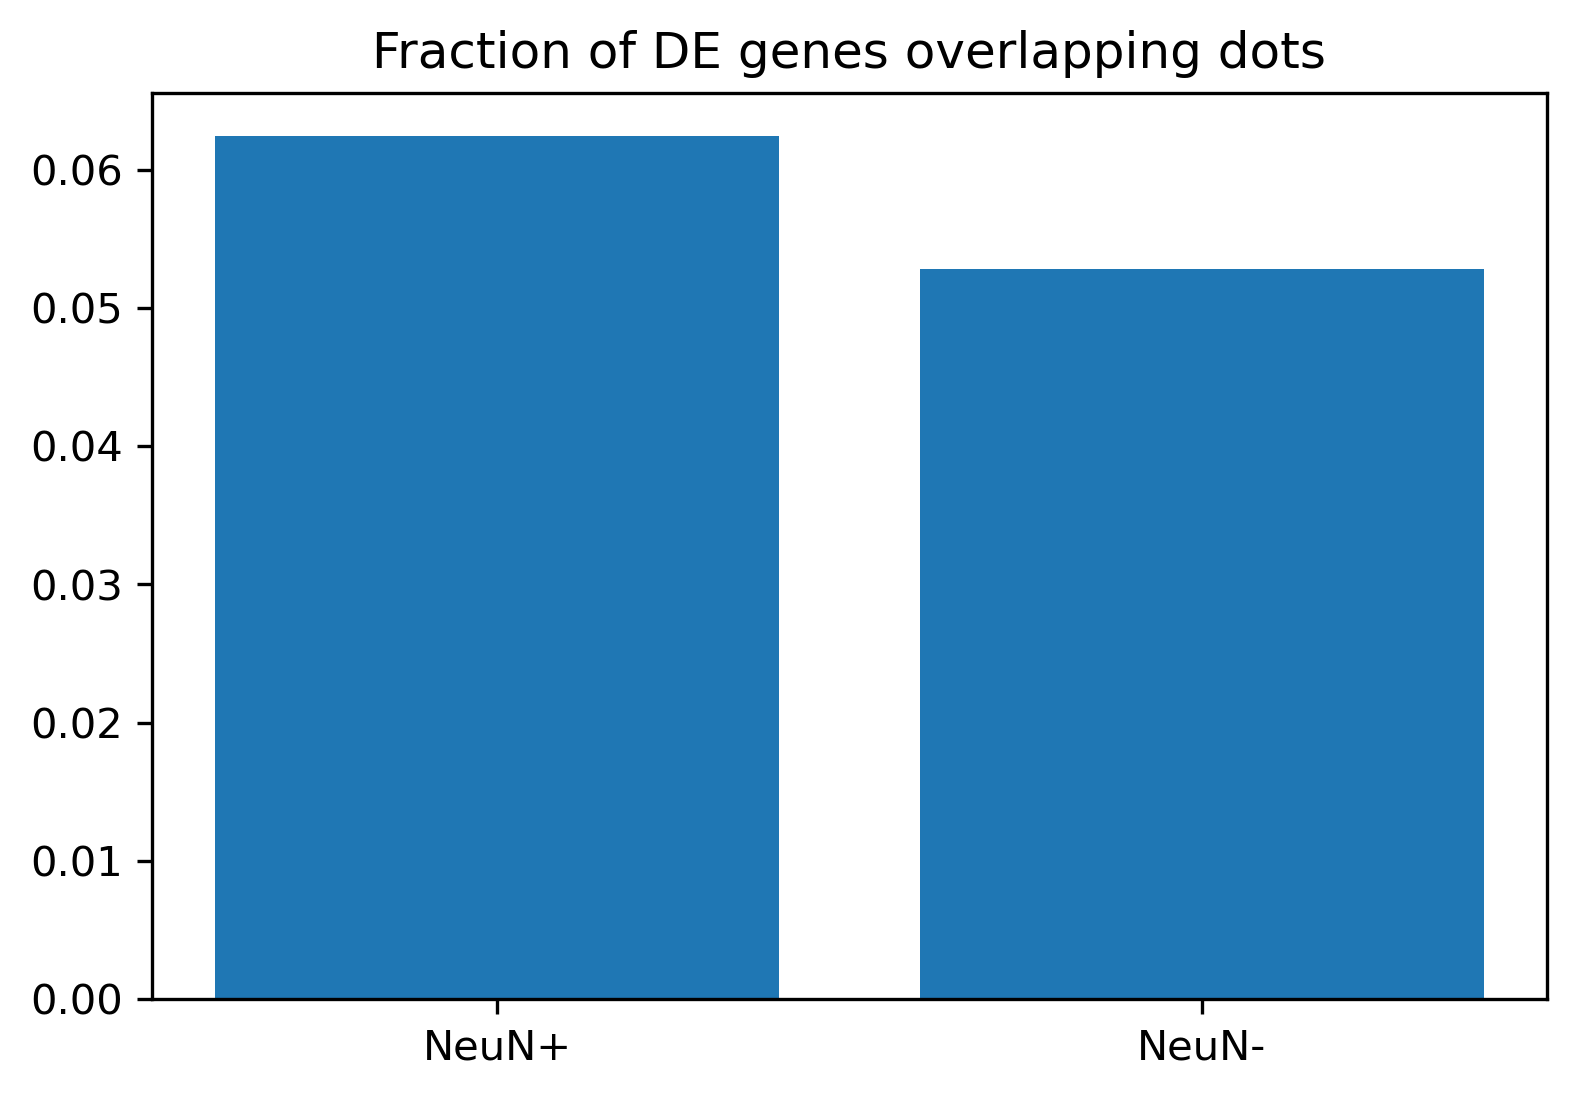

In [164]:
plt.figure(dpi=300)
arr = [
    pbt.from_dataframe(loops).pair_to_bed(tss['NeuN+']).count() / tss['NeuN+'].count(),
    pbt.from_dataframe(loops).pair_to_bed(tss['NeuN-']).count() / tss['NeuN-'].count()
]

plt.bar(['NeuN+', 'NeuN-'], arr)
plt.title('Fraction of DE genes overlapping dots')

# TAD borders overlap neu genes more frequently than glial genes

In [269]:
# Load TAD borders
tads = {
    phen: {
        "NeuN+": pbt(f"tad_borders_mrg_smp/boundaries_{phen}_plus_250.0kb.bed"),
        "NeuN-": pbt(f"tad_borders_mrg_smp/boundaries_{phen}_minus_250.0kb.bed"),
    } for phen in ('HC', 'SZ')
}
tads['HC']['NeuN+'].head()

chr1	3000000	3025000	HC_plus	0.35308732665141174	.
 chr1	3400000	3425000	HC_plus	0.479415909975409	.
 chr1	3875000	3900000	HC_plus	2.1821610472033632	.
 chr1	4825000	4850000	HC_plus	0.49296193343376804	.
 chr1	5975000	6000000	HC_plus	0.9480686593285115	.
 chr1	6650000	6675000	HC_plus	1.6039880517766343	.
 chr1	7275000	7300000	HC_plus	0.2533886553964951	.
 chr1	7625000	7650000	HC_plus	0.9704202613930586	.
 chr1	7950000	7975000	HC_plus	0.40197408657572403	.
 chr1	8325000	8350000	HC_plus	1.0198159532059128	.
 

# Expected

In [2]:
# Load updated, merged hi-c matrices 
res_scal = 2000
reps = ['merged']
phen='HC'

clr_dir = '/tank/projects/schizophrenia_2021/hi-c/our_data/2022.11_2/HC_merged_sampled/'
clr_names = {'HC': {
    'NeuN+': {'merged': f"sampled_plus_drop_diag_1K.mcool"},
    'NeuN-': {'merged': f"sampled_minus_drop_diag_1K.mcool"}
    }
}

clrs_scal = {phen: {ct: {rep:
        cooler.Cooler(clr_dir + clr_names[phen][ct][rep] + f'::resolutions/{res_scal}') 
        for rep in reps} for ct in ('NeuN+', 'NeuN-')} for phen in ['HC']}

clrs_scal

{'HC': {'NeuN+': {'merged': <Cooler "sampled_plus_drop_diag_1K.mcool::/resolutions/2000">},
  'NeuN-': {'merged': <Cooler "sampled_minus_drop_diag_1K.mcool::/resolutions/2000">}}}

In [83]:
cvd_smooth_agg = {'HC': {'NeuN+': {}, 'NeuN-': {}}, 
                  'SZ': {'NeuN+': {}, 'NeuN-': {}}}

In [92]:
for ct in ('NeuN+', 'NeuN-'):
    for phen in ['HC']:
        for rep in reps:
    
            cvd_smooth_agg[phen][ct][rep] = cooltools.expected_cis(
                clr=clrs_scal[phen][ct][rep],
                smooth=True,
                aggregate_smoothed=True,
                nproc=10
            )

In [4]:
for ct in ('NeuN+', 'NeuN-'):
    # cvd_smooth_agg['HC'][ct]['merged'].to_pickle(f"cvd_smooth_agg_{ct}.pkl")
    cvd_smooth_agg['HC'][ct]['merged'] = pd.read_pickle(f"cvd_smooth_agg_{ct}.pkl")    

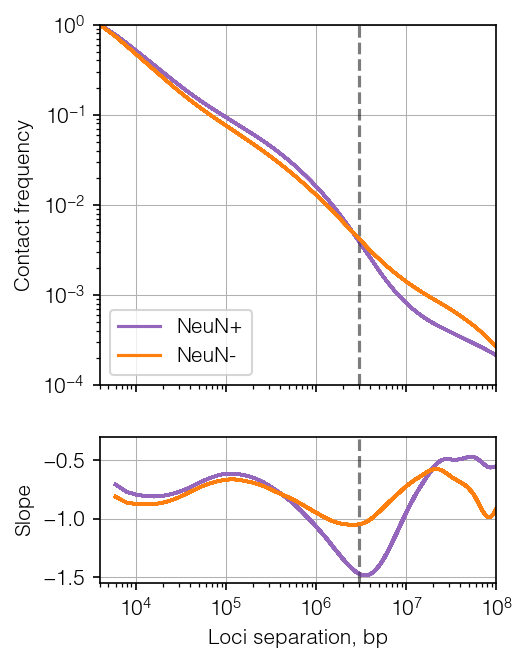

In [24]:
import warnings
from matplotlib.ticker import LogLocator
import matplotlib

matplotlib.rcParams['font.family'] = 'Helvetica'
# matplotlib.rc('font', serif='Helvetica Neue')
# matplotlib.rcParams['font.style'] = 'normal'
# matplotlib.rcParams["font.weight"] = "light"

matplotlib.rcParams.update({
    'font.weight': 'normal',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'normal',
})

warnings.filterwarnings('ignore')

# Plot scaling
f, axs = plt.subplots(2, 1, dpi=150, sharex=True, gridspec_kw={'height_ratios':[3, 1]}, 
                      figsize=(3.4, 4.5), 
                      layout="constrained")

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}
linestyles = {'R1': "solid", 'R2': "dashed", 'R3': 'dashdot', 'R4': 'dotted'}


i=0
for ct in ('NeuN+', 'NeuN-'):
    for phen in ['HC']:   
        for rep in reps:
            cvd_smooth_agg[phen][ct][rep].loc[:, 's_bp'] = cvd_smooth_agg[phen][ct][rep]['dist'] * res_scal
            cvd_smooth_agg[phen][ct][rep].loc[cvd_smooth_agg[phen][ct][rep]['dist'] < 2, 
                                              'balanced.avg.smoothed.agg'] = np.nan
            cvd_smooth_agg[phen][ct][rep].loc[:, 'balanced.avg.smoothed.agg.norm'] = \
                cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg'] / \
                cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg'].values[2]
            # cvd_smooth_agg[phen][ct][rep]['not_balanced.avg'] = cvd_smooth_agg[phen][ct][rep]['balanced.sum'] / \
            #     cvd_smooth_agg[phen][ct][rep]['n_valid']

            der = np.gradient(np.log(cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg.norm']),
                              np.log(cvd_smooth_agg[phen][ct][rep]['s_bp']))

            ax = axs[0]
            ax.plot([3e6, 3e6], [1e-4, 1], 'k--', alpha=0.3)
            ax.loglog(
                cvd_smooth_agg[phen][ct][rep]['s_bp'],
                # cvd_smooth_agg[phen][ct][rep]['not_balanced.avg'],
                cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg.norm'],
                # '-',
                # markersize=5,
                # label=f"{ct}, {phen}, {rep}",
                label=f"{ct}",
                color=colors[ct],
                # alpha=0.7,
                # linestyle=linestyles[rep]
            )

            ax.set(
                ylabel='Contact frequency',
                # xlim=(2e4, 4e7), # 10kb
                # xlim=(5e4, 5e7), # 25kb
            )
            ax.set_xlim([4000, 1e8])
            ax.set_ylim([1e-4, 1])
            ax.set_adjustable("box")
            ax.set_aspect(1)
            ax.grid(lw=0.5)
            ax.legend()
            # a = LogLocator()
            # a.set_params(base=10)
            # ax.xaxis.set_minor_locator(a)

            ax = axs[1]
            ax.plot([3e6, 3e6], [-1.55, -0.3], 'k--', alpha=0.3)
            ax.semilogx(
                cvd_smooth_agg[phen][ct][rep]['s_bp'],
                der,
                color=colors[ct],
                # alpha=0.5,
                # linestyle=linestyles[rep]
            )

            ax.set(
                xlabel='Loci separation, bp',
                ylabel='Slope',
            )

            ax.grid(lw=0.5)
            ax.set_xticks([1e4, 1e5, 1e6, 1e7, 1e8], minor=False)
            ax.set_ylim([-1.55, -0.3])
            
            # a = LogLocator()
            # a.set_params(base=10)
            # ax.xaxis.set_minor_locator(a)
            # ax.minorticks_on()

            
# ax.set(
#     xlabel='Genome separation, bp',
#     ylabel='Average contact frequency')
# # ax.set_aspect(1.0)
# ax.grid(lw=0.5)
# plt.xlim([2e4, 1e6])

# plt.tight_layout()
# plt.savefig("scaling.2022.11.2kb.smooth.agg.norm.HC.pdf")

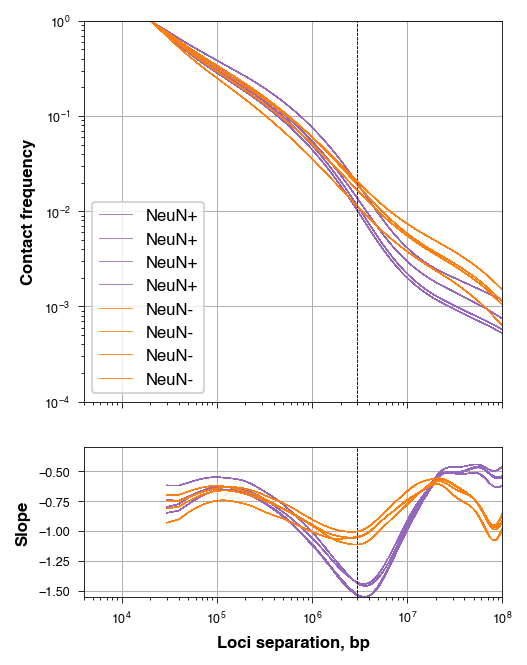

In [93]:
import warnings
from matplotlib.ticker import LogLocator
import matplotlib

matplotlib.rcParams['font.family'] = 'Helvetica'
# matplotlib.rc('font', serif='Helvetica Neue')
# matplotlib.rcParams['font.style'] = 'normal'
# matplotlib.rcParams["font.weight"] = "light"

matplotlib.rcParams.update({
    'font.weight': 'normal',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'normal',
})

warnings.filterwarnings('ignore')

# Plot scaling
f, axs = plt.subplots(2, 1, dpi=150, sharex=True, gridspec_kw={'height_ratios':[3, 1]}, 
                      figsize=(3.4, 4.5), 
                      layout="constrained")

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}
linestyles = {'R1': "solid", 'R2': "dashed", 'R3': 'dashdot', 'R4': 'dotted'}


i=0
for ct in ('NeuN+', 'NeuN-'):
    for phen in ['HC']:   
        for rep in reps:
            cvd_smooth_agg[phen][ct][rep].loc[:, 's_bp'] = cvd_smooth_agg[phen][ct][rep]['dist'] * res_scal
            cvd_smooth_agg[phen][ct][rep].loc[cvd_smooth_agg[phen][ct][rep]['dist'] < 2, 
                                              'balanced.avg.smoothed.agg'] = np.nan
            cvd_smooth_agg[phen][ct][rep].loc[:, 'balanced.avg.smoothed.agg.norm'] = \
                cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg'] / \
                cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg'].values[2]
            # cvd_smooth_agg[phen][ct][rep]['not_balanced.avg'] = cvd_smooth_agg[phen][ct][rep]['balanced.sum'] / \
            #     cvd_smooth_agg[phen][ct][rep]['n_valid']

            der = np.gradient(np.log(cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg.norm']),
                              np.log(cvd_smooth_agg[phen][ct][rep]['s_bp']))

            ax = axs[0]
            ax.plot([3e6, 3e6], [1e-4, 1], 'k--', alpha=0.3)
            ax.loglog(
                cvd_smooth_agg[phen][ct][rep]['s_bp'],
                # cvd_smooth_agg[phen][ct][rep]['not_balanced.avg'],
                cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg.norm'],
                # '-',
                # markersize=5,
                # label=f"{ct}, {phen}, {rep}",
                label=f"{ct}",
                color=colors[ct],
                # alpha=0.7,
                # linestyle=linestyles[rep]
            )

            ax.set(
                ylabel='Contact frequency',
                # xlim=(2e4, 4e7), # 10kb
                # xlim=(5e4, 5e7), # 25kb
            )
            ax.set_xlim([4000, 1e8])
            ax.set_ylim([1e-4, 1])
            ax.set_adjustable("box")
            ax.set_aspect(1)
            ax.grid(lw=0.5)
            ax.legend()
            # a = LogLocator()
            # a.set_params(base=10)
            # ax.xaxis.set_minor_locator(a)

            ax = axs[1]
            ax.plot([3e6, 3e6], [-1.55, -0.3], 'k--', alpha=0.3)
            ax.semilogx(
                cvd_smooth_agg[phen][ct][rep]['s_bp'],
                der,
                color=colors[ct],
                # alpha=0.5,
                # linestyle=linestyles[rep]
            )

            ax.set(
                xlabel='Loci separation, bp',
                ylabel='Slope',
            )

            ax.grid(lw=0.5)
            ax.set_xticks([1e4, 1e5, 1e6, 1e7, 1e8], minor=False)
            ax.set_ylim([-1.55, -0.3])
            
            # a = LogLocator()
            # a.set_params(base=10)
            # ax.xaxis.set_minor_locator(a)
            # ax.minorticks_on()

            
# ax.set(
#     xlabel='Genome separation, bp',
#     ylabel='Average contact frequency')
# # ax.set_aspect(1.0)
# ax.grid(lw=0.5)
# plt.xlim([2e4, 1e6])

# plt.tight_layout()
# plt.savefig("scaling.2022.11.2kb.smooth.agg.norm.HC.pdf")

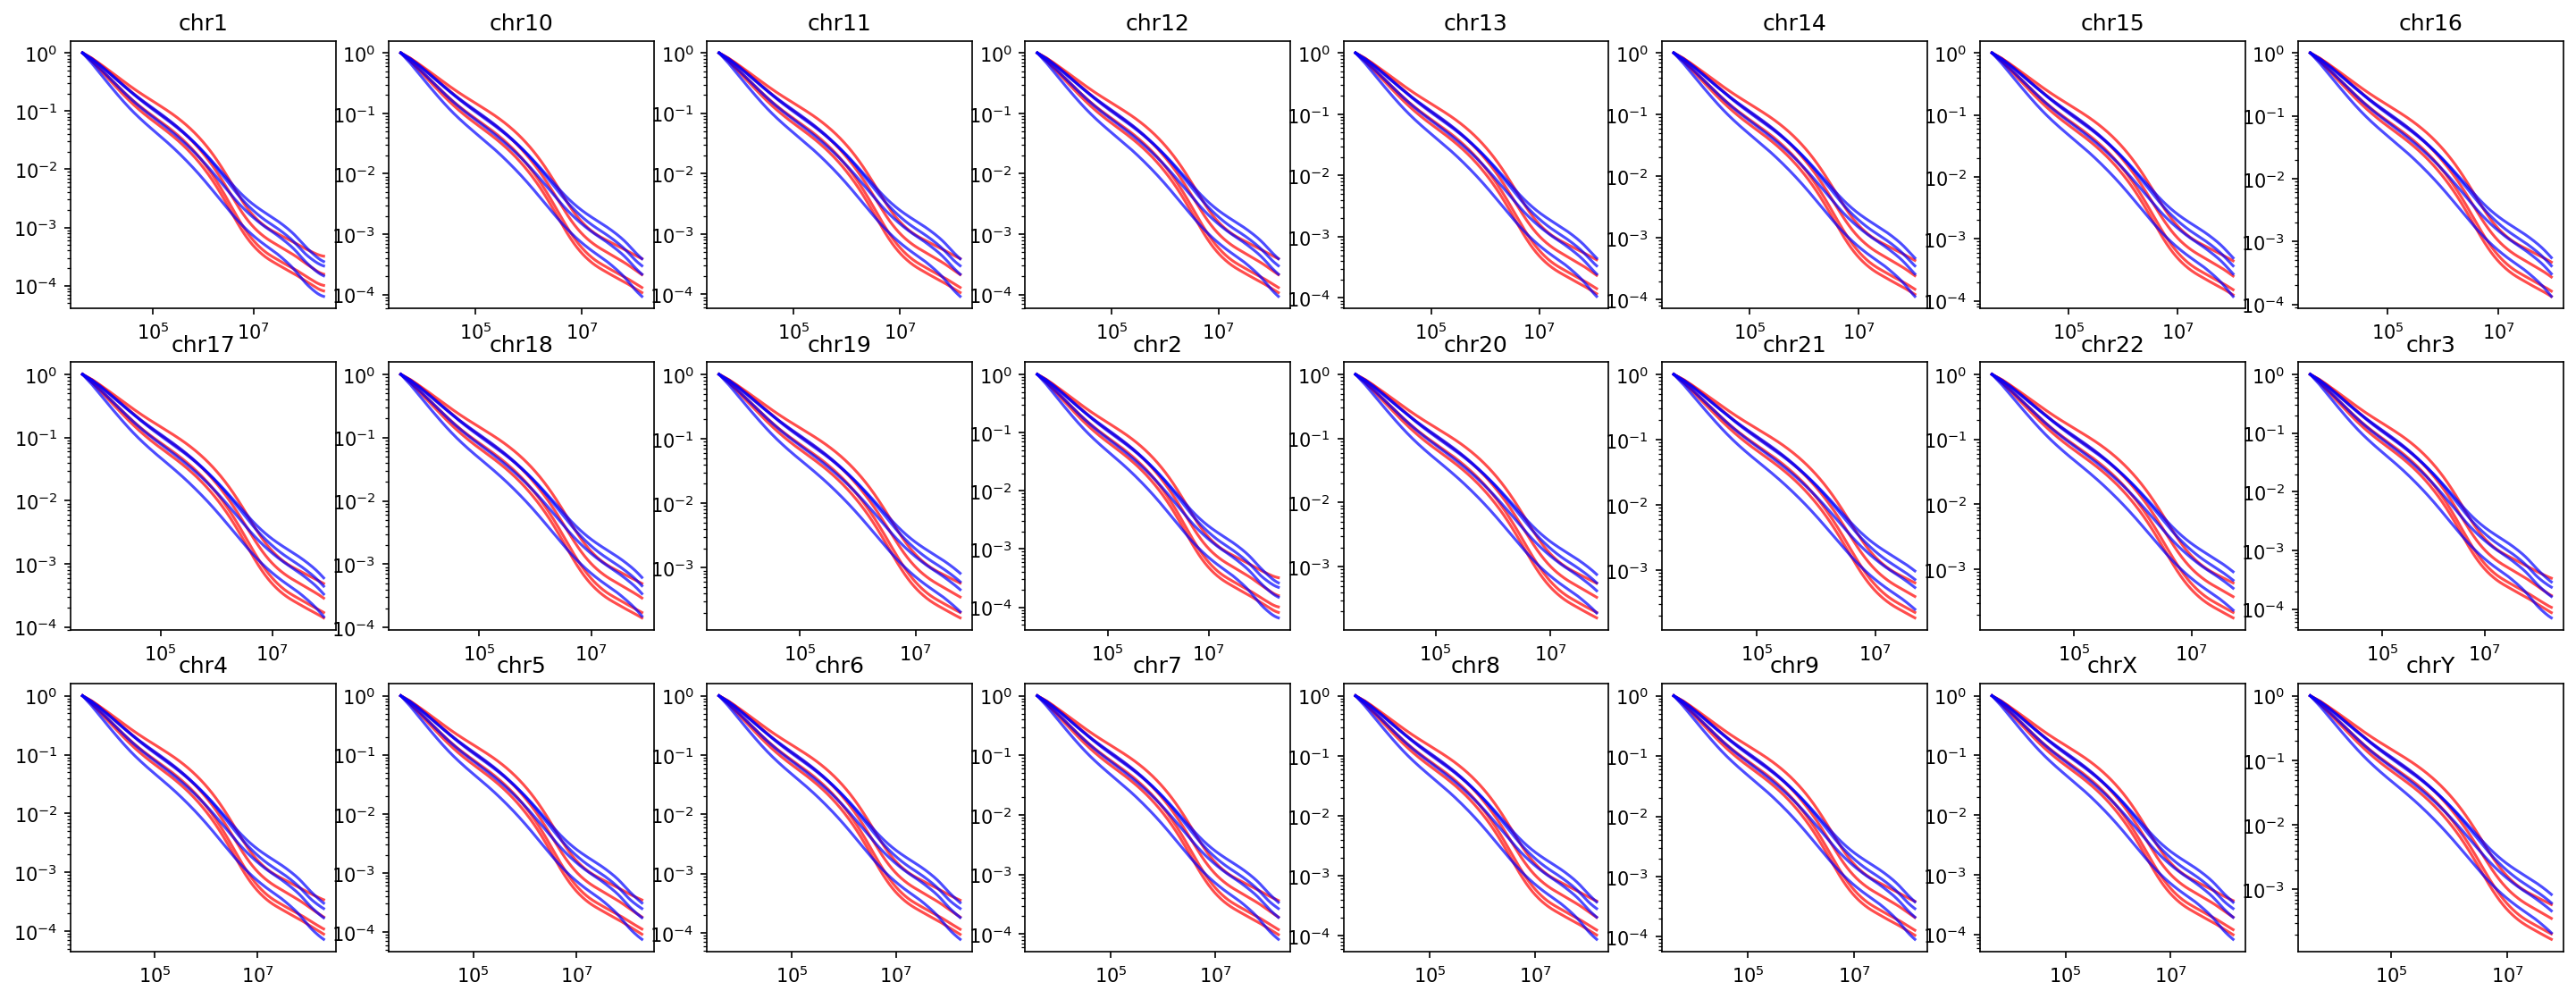

In [53]:
# Plot chroms separately
f, axs = plt.subplots(3, 8, dpi=150, figsize=(24, 9))

axs_flat = axs.flatten()
colors = {'NeuN+': 'red', 'NeuN-': 'blue'}
linestyles = {'HC': "solid", 'SZ': "dashed"}

for j, chrom in enumerate(hg38_cens['chrom'].values):
    ax = axs_flat[j]
    i=0
    for ct in ('NeuN+', 'NeuN-'):
        for phen in ['HC']:   
            for rep in reps:
                cvd_smooth_agg[phen][ct][rep].loc[:, 's_bp'] = cvd_smooth_agg[phen][ct][rep]['dist'] * res_scal
                cvd_smooth_agg[phen][ct][rep].loc[cvd_smooth_agg[phen][ct][rep]['dist'] < 2, 'balanced.avg.smoothed.agg'] = np.nan
                cvd_smooth_agg[phen][ct][rep].loc[:, 'balanced.avg.smoothed.agg.norm'] = \
                    cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg'] / cvd_smooth_agg[phen][ct][rep]['balanced.avg.smoothed.agg'].values[2]
                # cvd_smooth_agg[phen][ct]['not_balanced.avg'] = cvd_smooth_agg[phen][ct]['count.sum'] / cvd_smooth_agg[phen][ct]['n_valid']


                ax.loglog(
                    cvd_smooth_agg[phen][ct][rep].loc[cvd_smooth_agg[phen][ct][rep]['region1'] == chrom, 's_bp'],
                    # cvd_smooth_agg[phen][ct]['not_balanced.avg'],
                    cvd_smooth_agg[phen][ct][rep].loc[cvd_smooth_agg[phen][ct][rep]['region1'] == chrom, 
                                                 'balanced.avg.smoothed.agg.norm'],
                    label=f"{ct}, {phen}",
                    color=colors[ct], 
                    # color=palette[i],
                    alpha=0.7,
                    linestyle=linestyles[phen]
                )
                i+=1

                ax.set_title(chrom)
        
# ax.set(
#     xlabel='Genome separation, bp',
#     ylabel='Average contact frequency')
# # ax.set_aspect(1.0)
# ax.grid(lw=0.5)
# plt.xlim([2e4, 1e6])
# plt.legend()

# plt.savefig("scaling.per-chrom.2022.11.2kb.smooth.agg.norm.HC.png", dpi=300)

# Expected by compartments

In [754]:
comp_view_df = {phen: {ct : {} 
  for ct in ('NeuN+', 'NeuN-')} for phen in ('HC', 'SZ')
}
comp_cvd_inter = {phen: {ct : {} 
  for ct in ('NeuN+', 'NeuN-')} for phen in ('HC', 'SZ')
}

phen = 'SZ'
# for phen in ('SZ'):
for ct in ('NeuN+', 'NeuN-'):
    comp_view_df[phen][ct]['AA'] = eig_df.loc[eig_df[f'E1.{phen}.{ct}'] > 0, ['chrom', 'start', 'end', f'E1.{phen}.{ct}']]
    comp_view_df[phen][ct]['BB'] = eig_df.loc[eig_df[f'E1.{phen}.{ct}'] < 0, ['chrom', 'start', 'end', f'E1.{phen}.{ct}']]

    for comp in ('AA', 'BB'):
        comp_view_df[phen][ct][comp] = bioframe.merge(comp_view_df[phen][ct][comp]).drop(columns='n_intervals')
        comp_view_df[phen][ct][comp]['name'] = comp_view_df[phen][ct][comp].index

        print(phen, ct, comp)
        comp_cvd_inter[phen][ct][comp] = cooltools.expected_cis(
            clr=clrs_scal[phen][ct],
            view_df=comp_view_df[phen][ct][comp],
            intra_only=False,
            smooth=True,
            aggregate_smoothed=True,
            chunksize=100000000,
            nproc=4
        )
        # comp_cvd_inter[phen][ct][comp].to_pickle(f"expected_cis_by_compartments.{comp}.{phen}.{ct}.pkl")

SZ NeuN+ AA
SZ NeuN+ BB


Process ForkPoolWorker-280:
Process ForkPoolWorker-281:
Process ForkPoolWorker-279:
Process ForkPoolWorker-278:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ipletenev/miniconda3/envs/hic/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
Traceback (most recent call last):
  File "/home/ipletenev/miniconda3/envs/hic/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ipletenev/miniconda3/envs/hic/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ipletenev/miniconda3/envs/hic/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ipletenev/miniconda3/envs/hic/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ipletenev/miniconda3/envs/hic/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/iplete

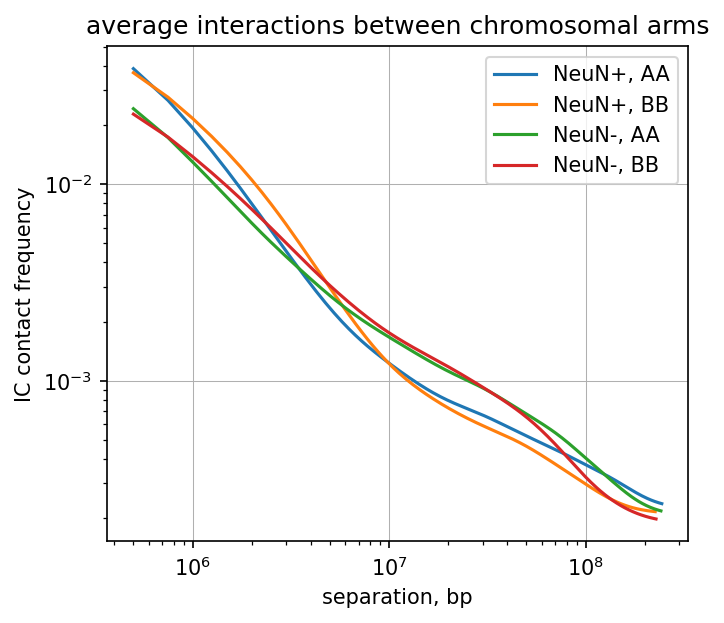

In [237]:
f, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)

for phen in ('HC', 'SZ'):
    for ct in ('NeuN+', 'NeuN-'):
        for comp in ('AA', 'BB'):
# cvd_merged_AA = cvd_inter_AA.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']].sort_values(by='dist')
# cvd_merged_AA['s_bp'] = cvd_merged_AA['dist'] * 250000
# cvd_merged_AA = cvd_merged_AA.loc[cvd_merged_AA['dist'] > 1]

# cvd_merged_BB = cvd_inter_BB.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']].sort_values(by='dist')
# cvd_merged_BB['s_bp'] = cvd_merged_BB['dist'] * 250000
# cvd_merged_BB = cvd_merged_BB.loc[cvd_merged_BB['dist'] > 1]


# cvd_merged_AA_minus = cvd_inter_AA_minus.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']]\
#                                         .sort_values(by='dist')
# cvd_merged_AA_minus['s_bp'] = cvd_merged_AA_minus['dist'] * 250000
# cvd_merged_AA_minus = cvd_merged_AA_minus.loc[cvd_merged_AA_minus['dist'] > 1]

# cvd_merged_BB_minus = cvd_inter_BB_minus.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']]\
#                                         .sort_values(by='dist')
# cvd_merged_BB_minus['s_bp'] = cvd_merged_BB_minus['dist'] * 250000
# cvd_merged_BB_minus = cvd_merged_BB_minus.loc[cvd_merged_BB_minus['dist'] > 1]


            ax.loglog(
                cvd_merged_AA['s_bp'],
                cvd_merged_AA['balanced.avg.smoothed.agg'],
            #     marker
                markersize=5,
                label='NeuN+, AA'
            )
# ax.loglog(
#     cvd_merged_BB['s_bp'],
#     cvd_merged_BB['balanced.avg.smoothed.agg'],
# #     marker
#     markersize=5,
#     label='NeuN+, BB'
# )
# ax.loglog(
#     cvd_merged_AA_minus['s_bp'],
#     cvd_merged_AA_minus['balanced.avg.smoothed.agg'],
# #     marker
#     markersize=5,
#     label='NeuN-, AA'
# )
# ax.loglog(
#     cvd_merged_BB_minus['s_bp'],
#     cvd_merged_BB_minus['balanced.avg.smoothed.agg'],
# #     marker
#     markersize=5,
#     label='NeuN-, BB'
# )


ax.set(
    xlabel='separation, bp',
    ylabel='IC contact frequency',
    title="average interactions between chromosomal arms")
ax.grid(lw=0.5)
ax.set_aspect(1.0)
ax.legend()

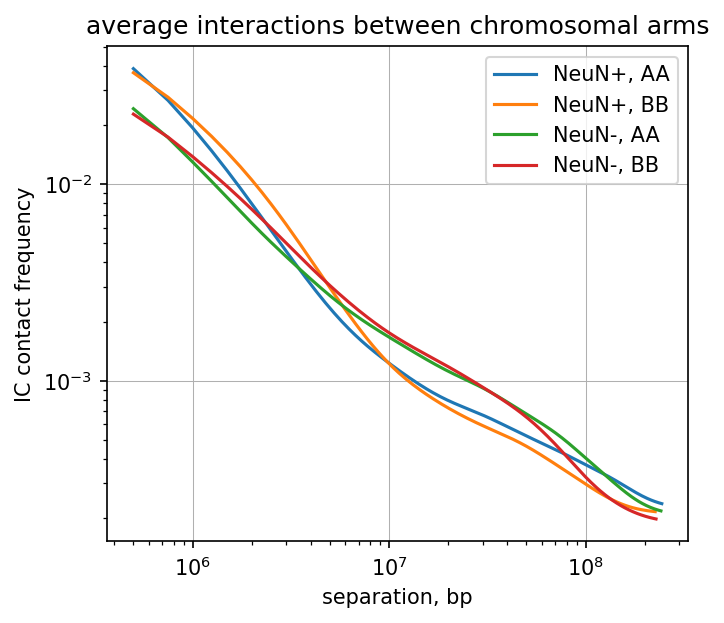

In [237]:
cvd_merged_AA = cvd_inter_AA.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']].sort_values(by='dist')
cvd_merged_AA['s_bp'] = cvd_merged_AA['dist'] * 250000
cvd_merged_AA = cvd_merged_AA.loc[cvd_merged_AA['dist'] > 1]

cvd_merged_BB = cvd_inter_BB.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']].sort_values(by='dist')
cvd_merged_BB['s_bp'] = cvd_merged_BB['dist'] * 250000
cvd_merged_BB = cvd_merged_BB.loc[cvd_merged_BB['dist'] > 1]


cvd_merged_AA_minus = cvd_inter_AA_minus.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']]\
                                        .sort_values(by='dist')
cvd_merged_AA_minus['s_bp'] = cvd_merged_AA_minus['dist'] * 250000
cvd_merged_AA_minus = cvd_merged_AA_minus.loc[cvd_merged_AA_minus['dist'] > 1]

cvd_merged_BB_minus = cvd_inter_BB_minus.drop_duplicates(subset=['dist'])[['dist', 'balanced.avg.smoothed.agg']]\
                                        .sort_values(by='dist')
cvd_merged_BB_minus['s_bp'] = cvd_merged_BB_minus['dist'] * 250000
cvd_merged_BB_minus = cvd_merged_BB_minus.loc[cvd_merged_BB_minus['dist'] > 1]

f, ax = plt.subplots(1,1,
    figsize=(5,5), dpi=150)

ax.loglog(
    cvd_merged_AA['s_bp'],
    cvd_merged_AA['balanced.avg.smoothed.agg'],
#     marker
    markersize=5,
    label='NeuN+, AA'
)
ax.loglog(
    cvd_merged_BB['s_bp'],
    cvd_merged_BB['balanced.avg.smoothed.agg'],
#     marker
    markersize=5,
    label='NeuN+, BB'
)
ax.loglog(
    cvd_merged_AA_minus['s_bp'],
    cvd_merged_AA_minus['balanced.avg.smoothed.agg'],
#     marker
    markersize=5,
    label='NeuN-, AA'
)
ax.loglog(
    cvd_merged_BB_minus['s_bp'],
    cvd_merged_BB_minus['balanced.avg.smoothed.agg'],
#     marker
    markersize=5,
    label='NeuN-, BB'
)


ax.set(
    xlabel='separation, bp',
    ylabel='IC contact frequency',
    title="average interactions between chromosomal arms")
ax.grid(lw=0.5)
ax.set_aspect(1.0)
ax.legend()

# Expected by TADs

In [170]:
# Load TAD borders
tads = {
    phen: {
        "NeuN+": pbt(f"tad_borders_mrg_smp/boundaries_{phen}_plus_250.0kb.bed"),
        "NeuN-": pbt(f"tad_borders_mrg_smp/boundaries_{phen}_minus_250.0kb.bed"),
    } for phen in ('HC', 'SZ')
}
tads['HC']['NeuN+'].head()

chr1	3000000	3025000	HC_plus	0.35308732665141174	.
 chr1	3400000	3425000	HC_plus	0.479415909975409	.
 chr1	3875000	3900000	HC_plus	2.1821610472033632	.
 chr1	4825000	4850000	HC_plus	0.49296193343376804	.
 chr1	5975000	6000000	HC_plus	0.9480686593285115	.
 chr1	6650000	6675000	HC_plus	1.6039880517766343	.
 chr1	7275000	7300000	HC_plus	0.2533886553964951	.
 chr1	7625000	7650000	HC_plus	0.9704202613930586	.
 chr1	7950000	7975000	HC_plus	0.40197408657572403	.
 chr1	8325000	8350000	HC_plus	1.0198159532059128	.
 

In [176]:
# Turn TAD border coordinates to TAD coordinates
def chia_input(phen, ct, rep, chrom):
    # Assign TAD borders to chromosome bins
    tad_bords = tads[phen][ct].to_dataframe()
    tad_bords_chrom = tad_bords.loc[tad_bords['chrom'] == chrom].reset_index(drop=True)
    tad_bords_chrom['bin'] = tad_bords_chrom['start'] // res

    bord_bins = tad_bords_chrom['bin'].values
    print(bord_bins[:5])
    
    # Load clr bins
    clr_bins = clrs[phen][ct][rep].bins().fetch(chrom).reset_index(drop=True)
    
    # Locate bad bins
    bad_bins = clr_bins.loc[clr_bins['weight'].isna()]
    
    # filter bad bins
    bad_bins_bed = pbt.from_dataframe(bad_bins)
    bad_bins_bed = bad_bins_bed.merge(d=25000)
    bad_bins_flt = bad_bins_bed.filter(lambda bord: len(bord) >= 50000).saveas().to_dataframe()
    
    # get tad-tad interactions values
    chrom_mtx = clrs[phen][ct][rep].matrix(balance=False).fetch(chrom)
    # chrom_mtx[:, bad_bins] = 0 # remove bad bins
    # chrom_mtx[bad_bins, :] = 0

    bedpe_rows = []
    for idx1 in range(len(bord_bins) - 1):
        tad1_start, tad1_end = bord_bins[idx1], bord_bins[idx1+1]
        bedpe_rows.append([chrom, tad1_start * res, tad1_end * res])
            
    bedpe_df = pd.DataFrame(bedpe_rows, columns=('chrom', 'start', 'end'))
    print(bedpe_df.shape)
    
    # Remove TADs that overlap bad bins
    bedpe_df_flt = bf.overlap(bedpe_df, bad_bins, suffixes=('', '_cent'))
    bedpe_df_flt = bedpe_df_flt.loc[~bedpe_df_flt['chrom_cent'].isin(clrs[phen][ct][rep].chromnames), 
                                   ('chrom', 'start', 'end')]
    bedpe_df_flt['start'] = bedpe_df_flt['start'].astype(int)
    bedpe_df_flt['end'] = bedpe_df_flt['end'].astype(int)

    # print(bedpe_df_flt.shape)
    
    return bedpe_df_flt

In [226]:
# tad_cvd = {'HC': {'NeuN+': {}, 'NeuN-': {}}, 
#            'SZ': {'NeuN+': {}, 'NeuN-': {}}}

phens = ['HC', 'SZ']
for phen in ['HC']:
    for ct in cts:
        for rep in ['R2']:
            print(phen, ct, rep)
            bedpe_df_flt = chia_input(phen, ct, rep, 'chr1')
            bedpe_df_flt['name'] = bedpe_df_flt.index
            bedpe_df_flt['length'] = bedpe_df_flt['end'] - bedpe_df_flt['start']
            bedpe_df_flt = bedpe_df_flt.loc[bedpe_df_flt['length'] > 0]
            bedpe_df_flt = bedpe_df_flt.drop(columns='length').reset_index(drop=True)

            tad_cvd[phen][ct][rep] = cooltools.expected_cis(
                clr=clrs_scal[phen][ct][rep],
                view_df=bedpe_df_flt,
                intra_only=False,
                smooth=True,
                aggregate_smoothed=True,
                chunksize=100000000,
                nproc=2
            )

HC NeuN+ R2
[12 13 15 19 23]
(343, 3)
HC NeuN- R2
[ 8 13 15 18 19]
(348, 3)


In [225]:
# save results
# tad_cvd['HC']['NeuN+']['R1'].to_pickle('tad_cvd.HC.NeuN+.R1.pkl')

In [195]:
tad_cvd['HC']['NeuN+']['R1']

region1  region2  dist  n_valid  count.sum  balanced.sum  count.avg  \
0              0        0     0       10        NaN           NaN        NaN   
1              0        0     1        9        NaN           NaN        NaN   
2              0        0     2        8       54.0      0.090052   6.750000   
3              0        0     3        7       44.0      0.078585   6.285714   
4              0        0     4        6       38.0      0.063831   6.333333   
...          ...      ...   ...      ...        ...           ...        ...   
2401075      470      470    25        5        4.0      0.008445   0.800000   
2401076      470      470    26        4        3.0      0.005924   0.750000   
2401077      470      470    27        3        3.0      0.007365   1.000000   
2401078      470      470    28        2        2.0      0.003582   1.000000   
2401079      470      470    29        1        3.0      0.007094   3.000000   

         balanced.avg  balanced.avg.smoothed  balanced.avg.smoothed.agg  
0                 NaN                    NaN                        NaN  
1                 NaN               0.000107                   0.000128  
2            0.011256               0.011134                   0.011444  
3            0.011226               0.011012                   0.009303  
4            0.010639               0.010321                   0.007918  
...               ...                    ...                        ...  
2401075      0.001689               0.002481                   0.002347  
2401076      0.001481               0.002412                   0.002264  
2401077      0.002455               0.002358                   0.002187  
2401078      0.001791               0.002316                   0.002114  
2401079      0.007094               0.002285                   0.002045  

[2401080 rows x 10 columns]

In [214]:
in_tad_cvd = tad_cvd['HC']['NeuN+']['R1'].loc[tad_cvd['HC']['NeuN+']['R1']['region1'] == 
                                               tad_cvd['HC']['NeuN+']['R1']['region2']]
in_tad_cvd_agg = in_tad_cvd[['s_bp', 'n_valid', 'balanced.sum']].groupby(['s_bp']).sum()
in_tad_cvd_agg['balanced.avg.agg'] = in_tad_cvd_agg['balanced.sum'] / in_tad_cvd_agg['n_valid']
in_tad_cvd_agg.iloc[0:1, :] = np.nan

out_tad_cvd = tad_cvd['HC']['NeuN+']['R1'].loc[tad_cvd['HC']['NeuN+']['R1']['region1'] != 
                                               tad_cvd['HC']['NeuN+']['R1']['region2']]
out_tad_cvd_agg = out_tad_cvd[['s_bp', 'n_valid', 'balanced.sum']].groupby(['s_bp']).sum()
out_tad_cvd_agg['balanced.avg.agg'] = out_tad_cvd_agg['balanced.sum'] / out_tad_cvd_agg['n_valid']
out_tad_cvd_agg.iloc[0:1, :] = np.nan

(50000.0, 2000000.0)

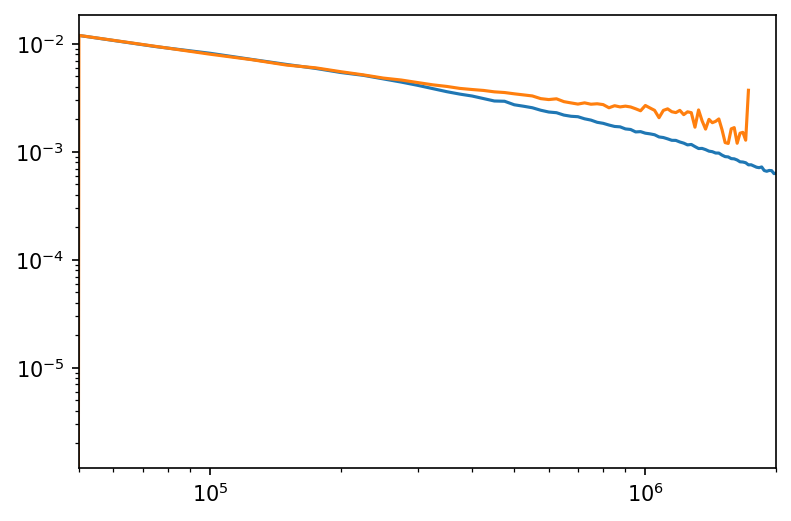

In [224]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(dpi=150)
plt.loglog(out_tad_cvd_agg.index,
           out_tad_cvd_agg['balanced.avg.agg'])
plt.loglog(in_tad_cvd_agg.index,
           in_tad_cvd_agg['balanced.avg.agg'])

plt.xlim([5e4, 2e6])

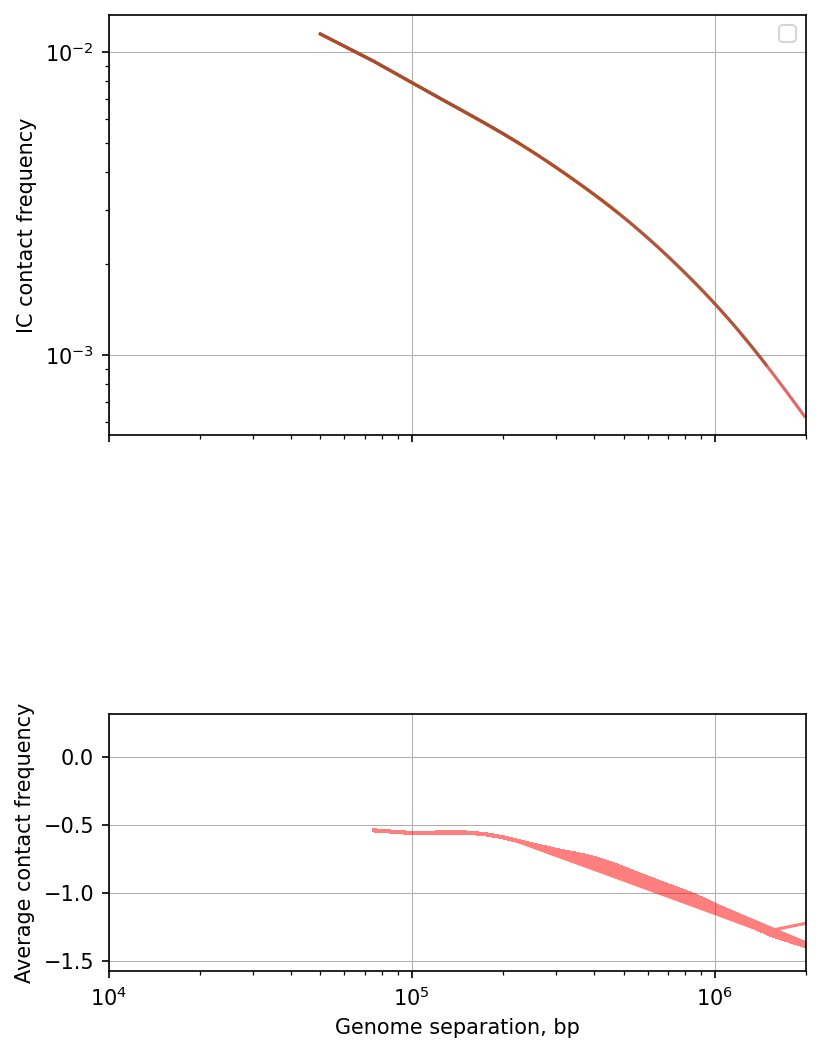

In [202]:
import warnings

warnings.filterwarnings('ignore')

# Plot scaling
f, axs = plt.subplots(2, 1, dpi=150, sharex=True, gridspec_kw={'height_ratios':[6,2]}, figsize=(6,10))

colors = {'NeuN+': 'red', 'NeuN-': 'blue'}
linestyles = {'HC': "solid", 'SZ': "dashed"}


i=0
for phen in ['HC']:
    for ct in ['NeuN+']:
        for rep in ['R1']:
            tad_cvd[phen][ct][rep].loc[:, 's_bp'] = tad_cvd[phen][ct][rep]['dist'] * res_scal
            tad_cvd[phen][ct][rep].loc[tad_cvd[phen][ct][rep]['dist'] < 2, 'balanced.avg.smoothed.agg'] = np.nan
            tad_cvd[phen][ct][rep].loc[:, 'balanced.avg.smoothed.agg.norm'] = \
                tad_cvd[phen][ct][rep]['balanced.avg.smoothed.agg'] / \
                tad_cvd[phen][ct][rep]['balanced.avg.smoothed.agg'].values[2]
            # cvd_smooth_agg[phen][ct]['not_balanced.avg'] = cvd_smooth_agg[phen][ct]['count.sum'] / \
                # cvd_smooth_agg[phen][ct]['n_valid']

            der = np.gradient(np.log(tad_cvd[phen][ct][rep]['balanced.avg.smoothed.agg.norm']),
                              np.log(tad_cvd[phen][ct][rep]['s_bp']))

            ax = axs[0]
            ax.loglog(
                tad_cvd[phen][ct][rep].loc[(tad_cvd[phen][ct][rep]['region1'] == 0) & (tad_cvd[phen][ct][rep]['region2'] == 0),
                                           's_bp'],
                tad_cvd[phen][ct][rep].loc[(tad_cvd[phen][ct][rep]['region1'] == 0) & (tad_cvd[phen][ct][rep]['region2'] == 0),
                                           'balanced.avg.smoothed.agg'],
                # '-',
                # markersize=5,
                # label=f"{ct}, {phen}, {rep}",
                # color=colors[ct],
                alpha=0.7,
                # linestyle=linestyles[phen]
            )
            ax.loglog(
                tad_cvd[phen][ct][rep].loc[(tad_cvd[phen][ct][rep]['region1'] == 1) & (tad_cvd[phen][ct][rep]['region2'] == 1),
                                           's_bp'],
                tad_cvd[phen][ct][rep].loc[(tad_cvd[phen][ct][rep]['region1'] == 1) & (tad_cvd[phen][ct][rep]['region2'] == 1),
                                           'balanced.avg.smoothed.agg'],
                # '-',
                # markersize=5,
                # label=f"{ct}, {phen}, {rep}",
                # color=colors[ct],
                alpha=0.7,
                # linestyle=linestyles[phen]
            )
            ax.loglog(
                tad_cvd[phen][ct][rep].loc[(tad_cvd[phen][ct][rep]['region1'] == 1) & (tad_cvd[phen][ct][rep]['region2'] == 2),
                                           's_bp'],
                tad_cvd[phen][ct][rep].loc[(tad_cvd[phen][ct][rep]['region1'] == 1) & (tad_cvd[phen][ct][rep]['region2'] == 2),
                                           'balanced.avg.smoothed.agg'],
                # '-',
                # markersize=5,
                # label=f"{ct}, {phen}, {rep}",
                # color=colors[ct],
                alpha=0.7,
                # linestyle=linestyles[phen]
            )
            ax.loglog(
                tad_cvd[phen][ct][rep].loc[(tad_cvd[phen][ct][rep]['region1'] == 2) & (tad_cvd[phen][ct][rep]['region2'] == 3),
                                           's_bp'],
                tad_cvd[phen][ct][rep].loc[(tad_cvd[phen][ct][rep]['region1'] == 2) & (tad_cvd[phen][ct][rep]['region2'] == 3),
                                           'balanced.avg.smoothed.agg'],
                # '-',
                # markersize=5,
                # label=f"{ct}, {phen}, {rep}",
                # color=colors[ct],
                alpha=0.7,
                # linestyle=linestyles[phen]
            )


            ax.set(
                ylabel='IC contact frequency',
                xlim=(1e4, 2e6), # 10kb
                # xlim=(5e4, 5e7), # 25kb
            )
            ax.set_aspect(1.0)
            ax.grid(lw=0.5)
            ax.legend()

            ax = axs[1]
            ax.semilogx(
                tad_cvd[phen][ct][rep]['s_bp'],
                der,
                color=colors[ct],
                alpha=0.5
            )

            ax.set(
                xlabel='separation, bp',
                ylabel='slope',
            )

            ax.grid(lw=0.5)


            ax.set(
                xlabel='Genome separation, bp',
                ylabel='Average contact frequency')
            # ax.set_aspect(1.0)
            ax.grid(lw=0.5)
            # plt.xlim([2e4, 1e6])


# plt.savefig("scaling.china8.sampled.10kb.inter-tad.png", dpi=300)

In [184]:
inter_tad_cvd = {'HC': {'NeuN+': {}, 'NeuN-': {}}, 
                 'SZ': {'NeuN+': {}, 'NeuN-': {}}}

phens = ['HC']
for phen in phens:
    for ct in cts:
        for rep in reps:
            print(phen, ct, rep)
            bedpe_df_flt = chia_input(phen, ct, rep, 'chr1')
            bedpe_df_flt['name'] = bedpe_df_flt.index
            bedpe_df_flt['length'] = bedpe_df_flt['end'] - bedpe_df_flt['start']
            bedpe_df_flt = bedpe_df_flt.loc[bedpe_df_flt['length'] > 0]
            bedpe_df_flt = bedpe_df_flt.drop(columns='length').reset_index(drop=True)

            inter_tad_cvd[phen][ct][rep] = cooltools.api.expected.diagsum_pairwise(
                clr=clrs_scal[phen][ct][rep],
                view_df=bedpe_df_flt,
                intra_only=True,
                chunksize=100000000,
            )

SZ NeuN+ R1
[13 15 19 21 23]
(349, 3)
SZ NeuN+ R2
[13 15 19 21 23]
(349, 3)
SZ NeuN- R1
[ 5  7  8 12 13]
(333, 3)
SZ NeuN- R2
[ 5  7  8 12 13]
(333, 3)


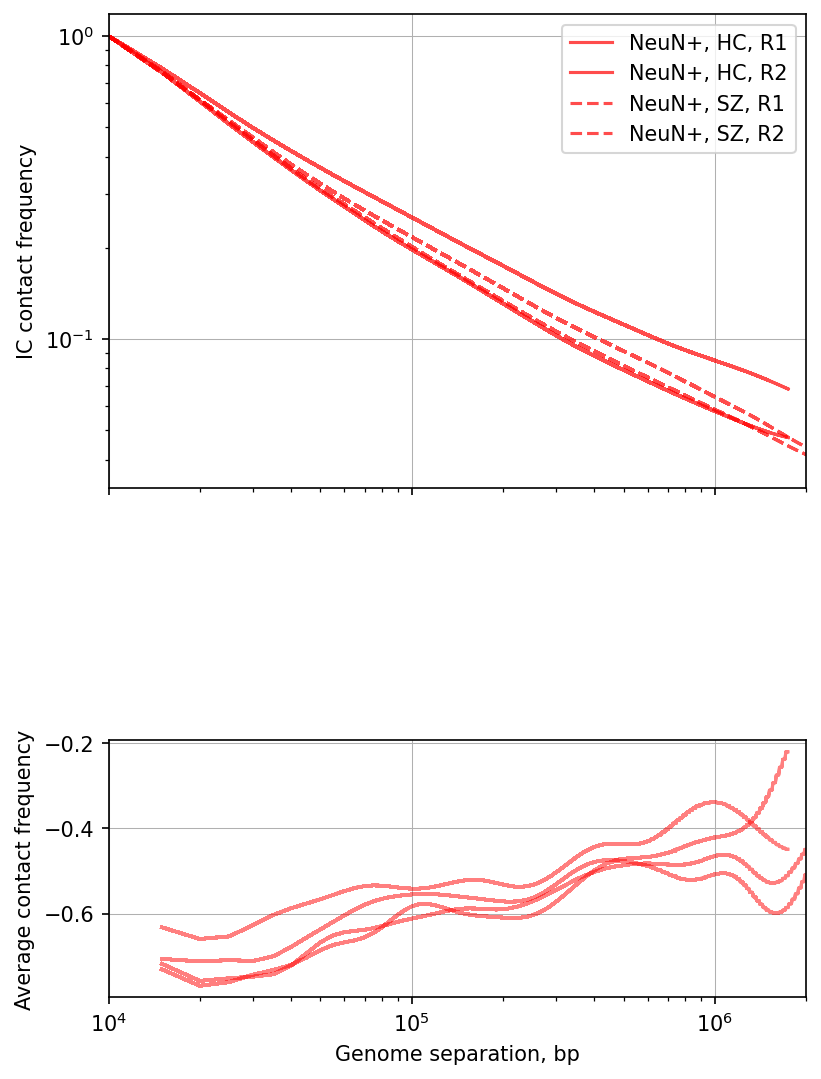

In [190]:
import warnings

warnings.filterwarnings('ignore')

# Plot scaling
f, axs = plt.subplots(2, 1, dpi=150, sharex=True, gridspec_kw={'height_ratios':[6,2]}, figsize=(6,10))

colors = {'NeuN+': 'red', 'NeuN-': 'blue'}
linestyles = {'HC': "solid", 'SZ': "dashed"}


i=0
for phen in ['HC', 'SZ']:
    for ct in ['NeuN+']:
        for rep in reps:
            tad_cvd[phen][ct][rep].loc[:, 's_bp'] = tad_cvd[phen][ct][rep]['dist'] * res_scal
            tad_cvd[phen][ct][rep].loc[tad_cvd[phen][ct][rep]['dist'] < 2, 'balanced.avg.smoothed.agg'] = np.nan
            tad_cvd[phen][ct][rep].loc[:, 'balanced.avg.smoothed.agg.norm'] = \
                tad_cvd[phen][ct][rep]['balanced.avg.smoothed.agg'] / \
                tad_cvd[phen][ct][rep]['balanced.avg.smoothed.agg'].values[2]
            # cvd_smooth_agg[phen][ct]['not_balanced.avg'] = cvd_smooth_agg[phen][ct]['count.sum'] / \
                # cvd_smooth_agg[phen][ct]['n_valid']

            der = np.gradient(np.log(tad_cvd[phen][ct][rep]['balanced.avg.smoothed.agg.norm']),
                              np.log(tad_cvd[phen][ct][rep]['s_bp']))

            ax = axs[0]
            ax.loglog(
                tad_cvd[phen][ct][rep]['s_bp'],
                tad_cvd[phen][ct][rep]['balanced.avg.smoothed.agg.norm'],
                # '-',
                # markersize=5,
                label=f"{ct}, {phen}, {rep}",
                color=colors[ct],
                alpha=0.7,
                linestyle=linestyles[phen]
            )

            ax.set(
                ylabel='IC contact frequency',
                xlim=(1e4, 2e6), # 10kb
                # xlim=(5e4, 5e7), # 25kb
            )
            ax.set_aspect(1.0)
            ax.grid(lw=0.5)
            ax.legend()

            ax = axs[1]
            ax.semilogx(
                tad_cvd[phen][ct][rep]['s_bp'],
                der,
                color=colors[ct],
                alpha=0.5
            )

            ax.set(
                xlabel='separation, bp',
                ylabel='slope',
            )

            ax.grid(lw=0.5)


            ax.set(
                xlabel='Genome separation, bp',
                ylabel='Average contact frequency')
            # ax.set_aspect(1.0)
            ax.grid(lw=0.5)
            # plt.xlim([2e4, 1e6])


# plt.savefig("scaling.china8.sampled.10kb.inter-tad.png", dpi=300)

# Does expression change in newly appearing small compartments in NeuN-?

## Small compartments

In [75]:
# Get newly appearing small compartments in NeuN-
comp_df = {'HC': {}, 'SZ': {}}

for phen in ('HC', 'SZ'):
    comp_df[phen]['Gli A & Neu B'] = comp[phen]['NeuN-']['A'].intersect(comp[phen]['NeuN+']['A'], v=True)\
                                                   .filter(lambda reg: len(reg) <= 1000000).saveas().to_dataframe()
    comp_df[phen]['Gli B & Neu A'] = comp[phen]['NeuN-']['B'].intersect(comp[phen]['NeuN+']['B'], v=True)\
                                                   .filter(lambda reg: len(reg) <= 1000000).saveas().to_dataframe()
    comp_df[phen]['Gli A & Neu A'] = comp[phen]['NeuN-']['A'].intersect(comp[phen]['NeuN+']['A'], u=True, f=1)\
                                                   .filter(lambda reg: len(reg) <= 1000000).saveas().to_dataframe()
    comp_df[phen]['Gli B & Neu B'] = comp[phen]['NeuN-']['B'].intersect(comp[phen]['NeuN+']['B'], u=True, f=1)\
                                                   .filter(lambda reg: len(reg) <= 1000000).saveas().to_dataframe()

    bin_expr_f = ['5343_BA9_neg.CPM.250kb.bw', '5343_BA9_pos.CPM.250kb.bw', 
                  '5404_BA9_neg.CPM.250kb.bw', '5404_BA9_pos.CPM.250kb.bw',
                  '5540_BA9_neg.CPM.250kb.bw', '5540_BA9_pos.CPM.250kb.bw',
                  '5347_BA9_neg.CPM.250kb.bw', '5347_BA9_pos.CPM.250kb.bw', 
                  '5456_BA9_neg.CPM.250kb.bw', '5456_BA9_pos.CPM.250kb.bw']

    print(comp_df[phen]['Gli A & Neu B'].shape,
          comp_df[phen]['Gli B & Neu A'].shape,
          comp_df[phen]['Gli A & Neu A'].shape,
          comp_df[phen]['Gli B & Neu B'].shape)

    for grp in ('Gli A & Neu B', 'Gli B & Neu A', 'Gli A & Neu A', 'Gli B & Neu B'):
        for file in bin_expr_f:
            with bbi.open(f'binned_expression/{file}') as f:
                    comp_df[phen][grp][file] = f.stackup(comp_df[phen][grp]['chrom'], 
                                                         comp_df[phen][grp]['start'], 
                                                         comp_df[phen][grp]['end'], bins=1)

        comp_df[phen][grp] = comp_df[phen][grp].drop(columns=['chrom','start','end'])\
                                   .melt(var_name='sample', value_name='Mean expression')
        comp_df[phen][grp]['Individual'] = comp_df[phen][grp]['sample'].str[:4]
        comp_df[phen][grp]['Cell type'] = comp_df[phen][grp]['sample'].str[9:12]
    
comp_df[phen][grp].head()

NameError: name 'comp' is not defined

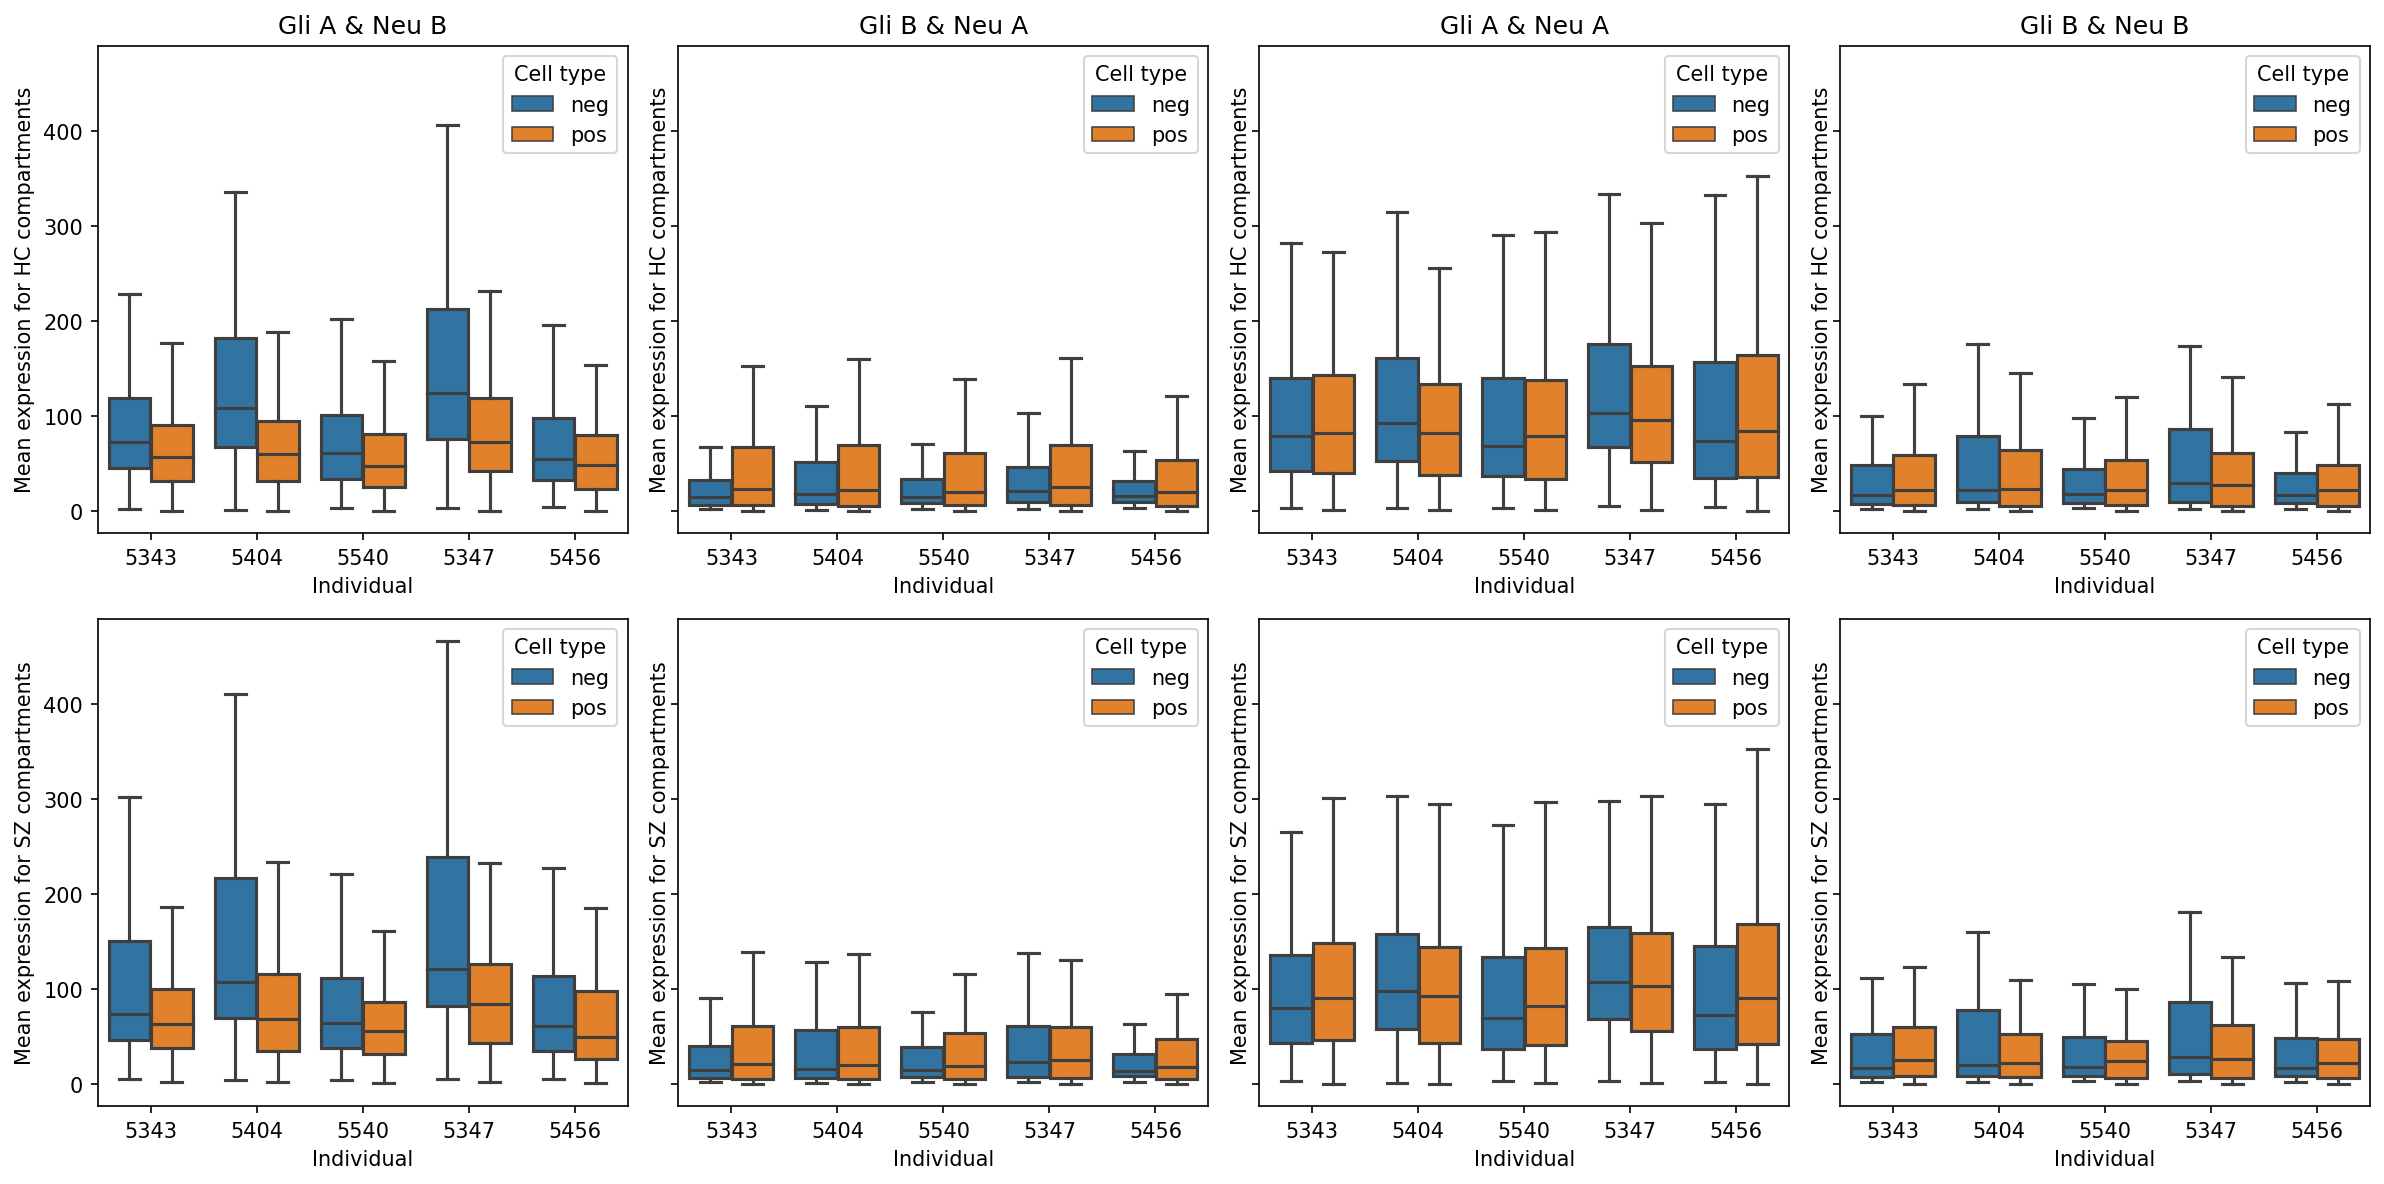

In [470]:
fig, axs = plt.subplots(2, 4, dpi=150, figsize=(16, 8), sharey=True)

for j, phen in enumerate(('HC', 'SZ')):
    for i, grp in enumerate(('Gli A & Neu B', 'Gli B & Neu A', 'Gli A & Neu A', 'Gli B & Neu B')):
        sns.boxplot(y='Mean expression', x='Individual', data=comp_df[phen][grp], hue='Cell type',
                    ax=axs[j, i], showfliers=False)
        axs[0, i].set_title(grp)
        axs[j, i].set_ylabel(f"Mean expression for {phen} compartments")

plt.tight_layout()
# plt.savefig("binned_expression_in_small compartments.png", dpi=300)

In [491]:
from scipy.stats import mannwhitneyu

for j, phen in enumerate(('HC', 'SZ')):
    for i, grp in enumerate(('Gli A & Neu B', 'Gli B & Neu A')):
        for ind in ('5343', '5404', '5540', '5347', '5456'):
            print(phen, grp,
            mannwhitneyu(
                comp_df[phen][grp].loc[(comp_df[phen][grp]['Individual'] == ind) & 
                                       (comp_df[phen][grp]['Cell type'] == 'pos'), 'Mean expression'],
                comp_df[phen][grp].loc[(comp_df[phen][grp]['Individual'] == ind) & 
                                       (comp_df[phen][grp]['Cell type'] == 'neg'), 'Mean expression']
            ).pvalue)


HC Gli A & Neu B 0.0003310692512852974
HC Gli A & Neu B 2.639665379954337e-13
HC Gli A & Neu B 0.00046945061130269363
HC Gli A & Neu B 1.867810236377758e-12
HC Gli A & Neu B 0.007399716795985333
HC Gli B & Neu A 0.045782293909342485
HC Gli B & Neu A 0.7421007266533902
HC Gli B & Neu A 0.44809837247141504
HC Gli B & Neu A 0.7090914311647072
HC Gli B & Neu A 0.7098035082548011
SZ Gli A & Neu B 0.008201574378336208
SZ Gli A & Neu B 2.331212762786484e-08
SZ Gli A & Neu B 0.015308670582110162
SZ Gli A & Neu B 1.1362704537210047e-08
SZ Gli A & Neu B 0.026609775267920903
SZ Gli B & Neu A 0.13117683623473997
SZ Gli B & Neu A 0.7979856508005205
SZ Gli B & Neu A 0.6760634697606736
SZ Gli B & Neu A 0.5215351115875269
SZ Gli B & Neu A 0.8285378534801328


## Correlation of PC1 with expression

In [475]:
from scipy.stats import pearsonr, spearmanr

chrom_query = pd.DataFrame(clrs['HC']['NeuN+'].chromsizes)
chrom_query.drop(index=['chrY', 'chrM'], inplace=True)
chrom_query['length'] = chrom_query['length'] - (chrom_query['length'] % 250000)
chrom_query['nbins'] = chrom_query['length'] // 250000

bin_expr_f = ['5343_BA9_neg.CPM.250kb.bw', '5343_BA9_pos.CPM.250kb.bw', 
                  '5404_BA9_neg.CPM.250kb.bw', '5404_BA9_pos.CPM.250kb.bw',
                  '5540_BA9_neg.CPM.250kb.bw', '5540_BA9_pos.CPM.250kb.bw',
                  '5347_BA9_neg.CPM.250kb.bw', '5347_BA9_pos.CPM.250kb.bw', 
                  '5456_BA9_neg.CPM.250kb.bw', '5456_BA9_pos.CPM.250kb.bw']
hic_maps = ('E1.HC.NeuN+', 'E1.HC.NeuN-', 'E1.SZ.NeuN+', 'E1.SZ.NeuN-')

res_pears = np.zeros((23, 4, 10), dtype=float) # n_chromosomes, n_hic_maps, n_expression_tracks

# MAKE SURE NaNs not dropped in eig_df
for k, file in enumerate(bin_expr_f):
    with bbi.open(f'binned_expression/{file}') as f:
        for i, (chrom, row) in enumerate(chrom_query.iterrows()):
            a = eig_df.loc[eig_df['chrom'] == chrom].iloc[:-1,:].reset_index(drop=True).dropna()
            b = f.fetch(chrom, 0, row['length'], row['nbins'])[a.index]
            
            for j, grp in enumerate(hic_maps):
                res_pears[i, j, k] = spearmanr(a[grp], b)[0]
                
res_pears_df = pd.DataFrame({"Spearmanr's ro": res_pears.reshape(920),
                            "Expression track": [*np.tile(bin_expr_f, 92)],
                            "hic_map": [*np.tile(np.repeat(hic_maps, 10), 23)]})
res_pears_df["Expression track"] = res_pears_df["Expression track"].str[:4] + res_pears_df["Expression track"].str[8:12]
res_pears_df.head()

Spearmanr's ro Expression track      hic_map
0        0.605168         5343_neg  E1.HC.NeuN+
1        0.493734         5343_pos  E1.HC.NeuN+
2        0.540382         5404_neg  E1.HC.NeuN+
3        0.477175         5404_pos  E1.HC.NeuN+
4        0.599660         5540_neg  E1.HC.NeuN+

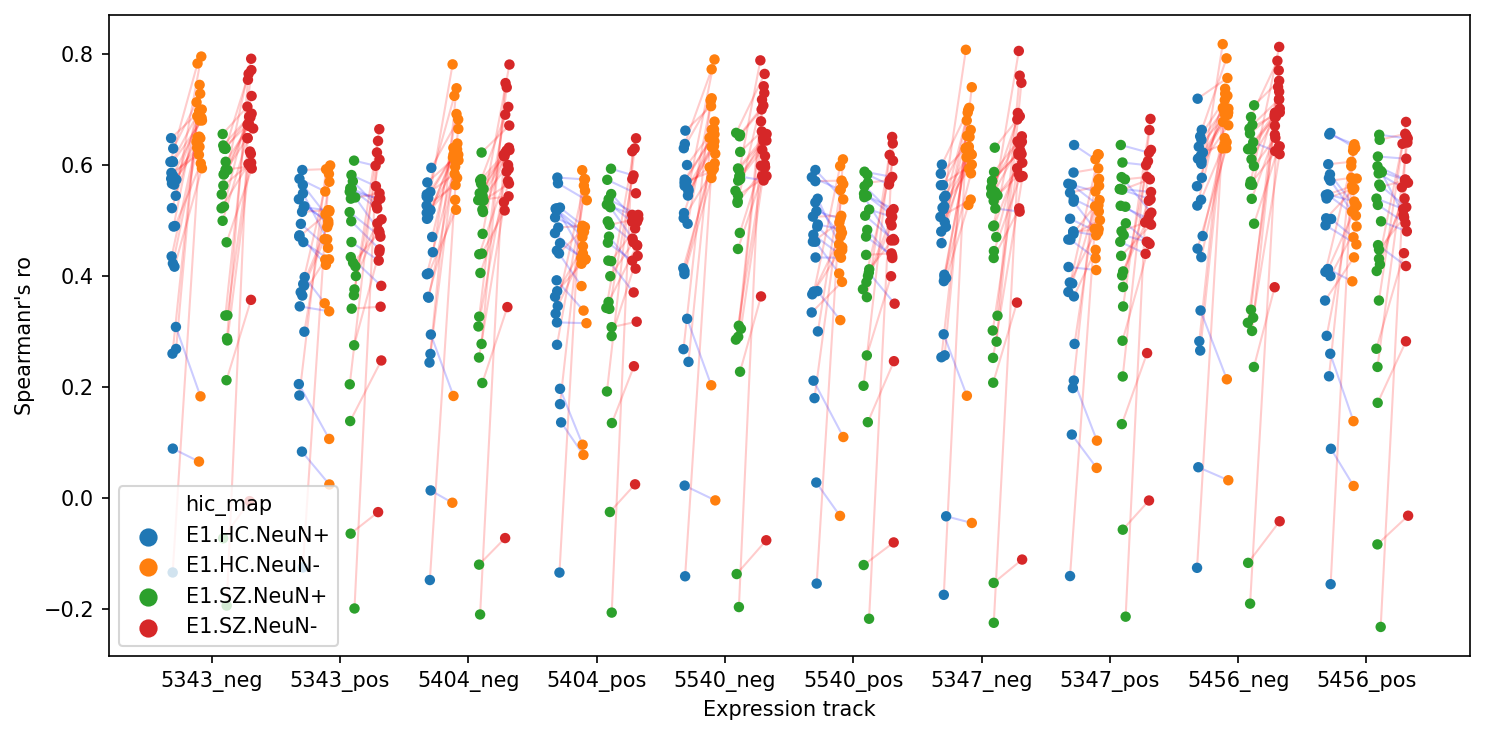

In [477]:
fig = plt.figure(dpi=150, figsize=(10,5))
ax = fig.add_subplot(111)
sns.stripplot(x='Expression track', y="Spearmanr's ro", data=res_pears_df, hue='hic_map', dodge=True, ax=ax);

idx0 = np.arange(0, 39, 2)
idx1 = idx0 + 1

for i, j in list(zip(idx0, idx1)):
    locs1 = ax.get_children()[i].get_offsets()
    locs2 = ax.get_children()[j].get_offsets()

    # before plotting, we need to sort so that the data points
    # correspond to each other as they did in "set1" and "set2"
    # sort_idxs1 = np.argsort(set1)
    # sort_idxs2 = np.argsort(set2)

    for k in range(locs1.shape[0]):
        x = [locs1[k, 0], locs2[k, 0]]
        y = [locs1[k, 1], locs2[k, 1]]
        if locs1[k, 1] < locs2[k, 1]:
            ax.plot(x, y, color="red", alpha=0.2, linewidth=1)
        else:
            ax.plot(x, y, color="blue", alpha=0.2, linewidth=1)

# plt.xticks(rotation=25);
plt.tight_layout()
# plt.savefig("PC1_vs_expression_correlation.png", dpi=300)

## All compartments

In [11]:
# get compartments
comp = {phen: {ct: {rep: {
    'A': pbt.from_dataframe(eig_df.loc[eig_df[f'E1.{phen}.{ct}.{rep}'] > 0]).merge(),
    'B': pbt.from_dataframe(eig_df.loc[eig_df[f'E1.{phen}.{ct}.{rep}'] < 0]).merge()
} for rep in reps} for ct in ('NeuN+', 'NeuN-')} for phen in ['HC']}

comp['HC']['NeuN+'][rep]['A'].head()

chr1	1000000	1050000
 chr1	1150000	1200000
 chr1	1550000	1600000
 chr1	1750000	1900000
 chr1	1950000	2050000
 chr1	2150000	2200000
 chr1	2350000	2400000
 chr1	2800000	2850000
 chr1	2900000	3450000
 chr1	3600000	5050000
 

In [12]:
# Get newly appearing small compartments in NeuN-
grp_df = {}
melt_df = {}

ct_label = {"pos": "NeuN+", 'neg': 'NeuN-'}

grp_df['Gli A & Neu B'] = comp['HC']['NeuN-']['merged']['A']\
    .intersect(comp['HC']['NeuN+']['merged']['B']).saveas().to_dataframe()
grp_df['Gli B & Neu A'] = comp['HC']['NeuN-']['merged']['B']\
    .intersect(comp['HC']['NeuN+']['merged']['A']).saveas().to_dataframe()

bin_expr_f = ['BA9_pos.merged.50bp.bw', 'BA9_neg.merged.50bp.bw']

for grp in ('Gli A & Neu B', 'Gli B & Neu A'):
    for file in bin_expr_f:
        with bbi.open(f'binned_expression/{file}') as f:
                grp_df[grp][file] = np.log10( f.stackup(grp_df[grp]['chrom'], 
                                              grp_df[grp]['start'], 
                                              grp_df[grp]['end'], bins=1) )

    melt_df[grp] = grp_df[grp].drop(columns=['chrom','start','end'])\
                               .melt(var_name='sample', value_name='Mean expression')
    # melt_df[phen][rep][grp]['Individual'] = melt_df[phen][rep][grp]['sample'].str[:4]
    melt_df[grp]['Cell type'] = melt_df[grp]['sample'].str[4:7]
    melt_df[grp]['Cell type'].replace(ct_label, inplace=True)
    melt_df[grp]['Group'] = grp

melt_df_cat = pd.concat(melt_df.values(), ignore_index=True)
melt_df_cat.head()

sample  Mean expression Cell type          Group
0  BA9_pos.merged.50bp.bw        -3.937490     NeuN+  Gli A & Neu B
1  BA9_pos.merged.50bp.bw        -2.428448     NeuN+  Gli A & Neu B
2  BA9_pos.merged.50bp.bw        -2.378109     NeuN+  Gli A & Neu B
3  BA9_pos.merged.50bp.bw        -1.067793     NeuN+  Gli A & Neu B
4  BA9_pos.merged.50bp.bw        -0.717508     NeuN+  Gli A & Neu B

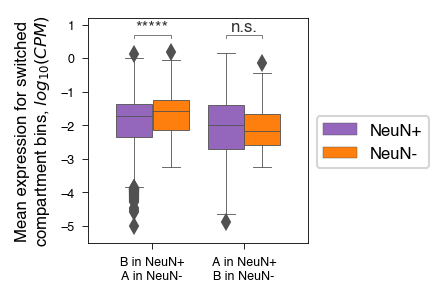

In [26]:
plot_rep = 'merged'

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(3, 2))

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

title = dict(zip(
    ('Gli A & Neu B', 'Gli B & Neu A'),
    ('B in NeuN+\nA in NeuN-', 'A in NeuN+\nB in NeuN-')
))

sns.boxplot(y='Mean expression', x='Group', data=melt_df_cat.replace(title), 
            hue='Cell type', ax=ax, palette=colors, saturation=1)
ax.set_ylabel("Mean expression for switched\ncompartment bins, $log_{10}(CPM)$")
plt.legend(bbox_to_anchor=(1, 0.6))
plt.xlabel('')
plt.ylim([-5.5, 1.2])
    
        
# statistical annotation
def annot(axs, x_mid, y, sig): 
    x1, x2 = x_mid-0.2, x_mid+0.2
    y, h, col = y, 0.1, 'k'
    axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.4, c=col, alpha=0.6)
    axs.text((x1+x2)*.5, y+h, sig, ha='center', va='bottom', color=col, alpha=0.8)
    
annot(ax, 0, 0.6, "*****")
annot(ax, 1, 0.6, "n.s.")


plt.tight_layout()
# plt.savefig("binned_expression_in_all_compartments.merged.pdf")

In [15]:
# Calculate p-values
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection

pvals = []

# calculate raw p-values using Wilcoxon test
for i, grp in enumerate(('Gli A & Neu B', 'Gli B & Neu A')):
        pval = wilcoxon(
            grp_df[grp][f'BA9_pos.merged.50bp.bw'],
            grp_df[grp][f'BA9_neg.merged.50bp.bw']
        ).pvalue

        pvals.append(pval)

        # print(phen, grp, plot_rep, pval)

pvals

[9.632139202837972e-79, 0.4115344005357443]

# Run MOSAIC

https://github.com/WenZi0809/MOSAIC

In [240]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 09 10:06:07 2021

@author: WenZi
"""
from scipy.stats.mstats import zscore
import numpy as np
from scipy.signal import convolve
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans

def get_com_mat(matrix):
    matrix = matrix.copy()
    col_sum = matrix.sum(axis=0)
    matrix_correct = np.matrix(col_sum).T * np.matrix(col_sum) / col_sum.sum()
    matrix = matrix - matrix_correct
    matrix[np.isnan(matrix)] = 0
    return matrix

def get_mod(part, matrix, remv = None):
    ct_ma =  get_com_mat(matrix)
    cls = sorted(list(set(part) - set({remv})))
    mod = []
    for c in cls :
        mask = part == c
        mod.append(ct_ma[mask][:,mask].sum()*0.5 / matrix.sum())
    return mod,sum(mod)

def get_oe(matrix):
    matrix = np.array(matrix).copy()
    lens = matrix.shape[0]
    mask = np.ones(lens)
    cut_off = lens * 0.4
    matrix_num = matrix.copy()
    matrix_num[matrix_num > 0] = 1
    col_sum = matrix_num.sum(axis = 0)
    sites = np.arange(lens)
    for i in sites:
        if col_sum[i] <= cut_off:
            mask[i] = 0
    mask = mask == 1
    x_o = sites.copy()
    y_o = sites.copy()
    dis = np.zeros(lens)
    mask_o = mask.copy()
    exp_matrix = np.ones((lens, lens))
    x_e = sites.copy()
    y_e = sites.copy()
    for i in range(lens):
    ##obs_matrix
        diag_n = matrix[(x_o, y_o)]
        diag_line = diag_n[mask_o]
        if diag_line.shape[0] == 0:
            dis[i] = 0
        else :
            dis[i] = diag_line.mean()
            x_o = np.delete(x_o,-1)
            y_o = np.delete(y_o,0)
            mask_o = np.delete(mask_o,-1)
        
        ##exp_matrix
        if dis[i] == 0:
            x_e = np.delete(x_e,-1)
            y_e = np.delete(y_e,0)
            continue
        exp_matrix[(x_e, y_e)] = dis[i]
        exp_matrix[(y_e, x_e)] = dis[i]
        x_e = np.delete(x_e,-1)
        y_e = np.delete(y_e,0)

    oe = np.matrix(matrix/exp_matrix)
    return np.asarray(oe), mask
    

def rearange_shuffle(matrix, part):
    part = part.copy()
    ctmatrix = get_com_mat(matrix) 
    sites = np.arange(len(part))   
    np.random.shuffle(sites)
    classes = sorted(set(part) - {0.0})
     
    for i in sites:
        current_c = part[i]
 
     ##clustering
       
        mod_value = -1
        for c in classes:
            part_mask = part == c
            c_sites = sites[part_mask]
#            o_sites = sites[~part_mask]
            Lic_sum = ctmatrix[i,c_sites].mean() #matrix[i,c_sites].mean() / matrix[i,o_sites].mean() #
            if Lic_sum <= -1 and current_c != 0 : 
               continue
                                      
            values = Lic_sum 
            if values > mod_value :
               mod_value = values
               part[i] = c 
    return part

def get_mod_values(part, matrix, remv = None):
    ct_ma =  get_com_mat(matrix)
    cls = sorted(list(set(part) - set({remv})))
    mod = []
    part_mask = {}
    for c in cls :
        part_mask[c] = part == c
    for i,p in enumerate(part):
        value = ct_ma[i,part_mask[p]].mean()
        mod.append(value)
    
    return np.asarray(mod)

def rearange_seq(matrix, part):
    part = part.copy()
    ctmatrix = get_com_mat(matrix) 
    sites = np.arange(len(part))   
    classes = sorted(set(part) - {0.0})
    
    mod_sample = get_mod_values(part, matrix)
    mask = mod_sample <= 0
    for i in np.hstack((sites[mask],sites[~mask])):
        current_c = part[i]
     
     ##clustering
        
        mod_value = -1
        for c in classes:
            part_mask = part == c
            c_sites = sites[part_mask]

#            o_sites = sites[~part_mask]
            Lic_sum = ctmatrix[i,c_sites].mean() #matrix[i,c_sites].mean() / matrix[i,o_sites].mean() #
            if Lic_sum <= -1 and current_c != 0 : 
               continue
            
            values = Lic_sum 
            if values > mod_value :
               mod_value = values
               part[i] = c 
    return part

def sort_part(matrix, part):
    sites = np.arange(len(part))   
    sort_values = np.array(part)
    ranges = set(sort_values) - {0}
    list_values = []
    for i in ranges:
        mask = sort_values == i
        loci_site = sites[mask]
        means = matrix[loci_site, loci_site].mean()
        list_values.append([means,loci_site])

    sort_cls = sorted(list_values, key=lambda x: (x[0]))
    new_part = dict()
    for i in range(len(ranges)):
        for x in sort_cls[i][1]:
           new_part[x] = i
    
    outs = [new_part.get(j,-1) for j in sites]
         
    return np.array(outs, dtype = float)


def select_pc(pcs, matrix, lc=[0], remv = None):
        
    mod = 0 
    exclud = []
    exclud.extend(lc)
    sites = np.delete(np.arange(10),exclud)
    for i in sites:  
        label_mid = np.zeros(matrix.shape[0])
        pcmid = pcs[i]
        mask_u = pcmid > 0 #np.percentile(pcmid, 75)
        mask_d = pcmid <= 0 #np.percentile(pcmid, 25)
        label_mid[mask_u] = 3
        label_mid[mask_d] = 2
        c_mod = get_mod(label_mid, matrix , remv)[1]
        print (i+1,c_mod)
        if c_mod > mod :
            mod = c_mod
            lci = i
                
    return lci 

def Kmeans_SVD(matrix, mask, cent = 0, cluster_number=4):
    ##input O/E matrix/gap position/centromere position/cluster number
    mat = matrix[mask][:,mask]
    lens = mat.shape[0]      
    oe = mat.copy()
    ##svd
    u,s,v = np.linalg.svd(oe)                             ## first round of SVD
       
    del_s = []
    lc = select_pc(v, oe, [0], 0)                         
    svd_id = np.delete(np.arange(20),[0,lc])
    for i in svd_id:                                      ## remove centromere effect
        sites = np.ones(lens)
        p =  zscore(convolve(v[i],[1,1,1], mode = 'same'))
        sites[p<=0] = -1
        print (i+1,abs(sites[:cent].mean()),abs(sites[cent:].mean()))
        if (abs(sites[:cent].mean()) + abs(sites[cent:].mean())) >= 1.0:
            del_s.append(i)
        
        elif abs(sites[:cent].mean()) + abs(sites[cent:].mean()) >= 0.8:
            v[i][:cent] = v[i][:cent] - v[i][:cent].mean()
            u[:,i][:cent] = u[:,i][:cent] - u[:,i][:cent].mean()
            v[i][cent:] = v[i][cent:] - v[i][cent:].mean()
            u[:,i][cent:] = u[:,i][cent:] - u[:,i][cent:].mean()
              
    s[del_s] = 0 
    oe = np.dot((u*s),v)
    oe[oe<0] = 0
    oe2 =  oe.copy()
    u,s,v = np.linalg.svd(np.asarray(oe))                 ## second round of SVD
    lc = select_pc(v, oe, [0], 0)                         ## select EV1
    lc2 = select_pc(v, oe, [0,lc], 0)                     ## select EV2
        
    pc1 = v[lc].copy()
    pc2 = v[lc2].copy()
#    pc3 = v[lc3].copy()
    
    pct = 1
    p5 = np.percentile(pc1,pct)   
    pc1[pc1<p5] = p5  
    p95 = np.percentile(pc1,(100-pct))   
    pc1[pc1>p95] = p95  
    
    p5 = np.percentile(pc2,pct)   
    pc2[pc2<p5] = p5  
    p95 = np.percentile(pc2,(100-pct))   
    pc2[pc2>p95] = p95 
    

#     X = np.asarray(zip(v[lc], v[lc2]*(s[lc2] / s[lc])))  ##weighted by eigenvalues
    X = np.array(list(zip(v[lc], v[lc2]*(s[lc2] / s[lc]))))  ##weighted by eigenvalues
        
    label = KMeans(n_clusters=cluster_number, random_state=0).fit(X).labels_ + 1  ##K-means

    prd_buff = label.copy()
    mod = get_mod(label,oe2)[1]
    prd_pre = label.copy()            
    while True :                                        ##Louvain algorithm
        prd_pre = rearange_seq(oe2,prd_pre)
        
        l0 = len(prd_pre[(prd_pre - prd_buff) == 0]) / float(oe.shape[1])
        print (l0,get_mod(prd_pre,oe2)[1])
        
        if  get_mod(prd_pre,oe2)[1] <= mod : 
            prd_pre = prd_buff.copy()
            break
        else :
            prd_buff = prd_pre.copy()
            mod = get_mod(prd_pre,oe2)[1]
        
    prd = sort_part(oe, prd_pre) + 1
    return prd, X

# if __name__ == '__main__':
#     oe, mask = get_oe(matrix)
#     labels = Kmeans_SVD(oe, mask, cent = 0, cluster_number=4)

In [256]:
bins_mos = bins.copy(deep=True)
bins_mos['mosaic_clus'] = 0
bins_mos['mosaic_E1'] = np.nan
bins_mos['mosaic_E2'] = np.nan



for chrom in clrs['HC']['NeuN-']['merged'].chromnames:
    print(chrom)
    
    # get numpy matrix
    matrix = clrs['HC']['NeuN-']['merged'].matrix().fetch(chrom)
    matrix = np.nan_to_num(matrix)

    # get centromere bin
    hg38_cens_sad.index = hg38_cens_sad['chrom']
    cen_bin = hg38_cens_sad.loc[chrom, 'mid'] // res
    
    # Run MOSAIC
    oe, mask = get_oe(matrix)
    labels, eigs_mos = Kmeans_SVD(oe, mask, cent = cen_bin, cluster_number=4)
    
    # assign bins to clusters
    all_labels = np.array(mask, dtype=int)
    all_labels[all_labels != 0] = labels
    bins_mos.loc[bins_mos['chrom'] == chrom, 'mosaic_clus'] = all_labels
    
    # assign bins to eigs
    all_labels = np.array(mask, dtype=float)
    all_labels[all_labels != 0] = eigs_mos[:, 0]
    all_labels[all_labels == 0] = np.nan
    bins_mos.loc[bins_mos['chrom'] == chrom, 'mosaic_E1'] = all_labels
    
    all_labels = np.array(mask, dtype=float)
    all_labels[all_labels != 0] = eigs_mos[:, 1]
    all_labels[all_labels == 0] = np.nan
    bins_mos.loc[bins_mos['chrom'] == chrom, 'mosaic_E2'] = all_labels

chr1
2 0.06084953223752867
3 -0.023812942117213964
4 0.024157863590836468
5 0.01704172123267226
6 -0.016001762995926958
7 -0.014566792155718366
8 0.013911328215750564
9 -0.009320339647834328
10 0.0064960182297870385
3 0.2531389226407452 0.05181058495821727
4 0.5925475901174565 0.7860724233983287
5 0.19724584852166868 0.07186629526462396
6 0.3406237343053868 0.3147632311977716
7 0.4175779667881733 0.6044568245125348
8 0.0044552450384771165 0.11977715877437325
9 0.08221952207371405 0.019498607242339833
10 0.10247063588497367 0.09749303621169916
11 0.25880923450789795 0.10863509749303621
12 0.054678007290400975 0.07186629526462396
13 0.14945321992709598 0.2947075208913649
14 0.019846091535034426 0.09749303621169916
15 0.1421628189550425 0.08635097493036212
16 0.011745646010530578 0.1799442896935933
17 0.1445929526123937 0.08969359331476323
18 0.04495747266099635 0.017270194986072424
19 0.027946537059538274 0.008356545961002786
20 0.002025111381125962 0.02618384401114206
2 0.05916028280984

2 0.03796141277964281
3 -0.024276095989850702
4 0.015449636009484922
5 -0.014105518564128422
6 0.007778391143117361
7 -0.005755878197369633
8 -0.006334118800349851
9 0.006489093821403201
10 0.0055058063918073255
3 -0.024276095989850702
4 0.015449636009484922
5 -0.014105518564128422
6 0.007778391143117361
7 -0.005755878197369633
8 -0.006334118800349851
9 0.006489093821403201
10 0.0055058063918073255
0.7397862979258328 0.0345507991615549
0.9380892520427404 0.035083302974358965
0.967316153362665 0.03517437238622087
0.978629792583281 0.03525839947821242
0.9864864864864865 0.03534863668936661
0.9934003771213074 0.03537985668320961
0.9952859836580766 0.03534902811785775
chr7
2 0.04353079931545779
3 0.02832388617689593
4 -0.021372693864297382
5 0.01756622337559325
6 -0.009624472121550575
7 0.01123399218616185
8 -0.01074320181737173
9 -0.008319593123807747
10 0.007476653710873656
3 0.8277591973244147 0.7929411764705883
4 0.18394648829431437 0.17882352941176471
5 0.205685618729097 0.05529411764

6 0.014349397197925495
7 0.010703886929391686
8 -0.005944733034612376
9 0.006458004602168754
10 -0.0054220720554810364
3 0.04033379694019471 0.030203185063152116
4 0.02364394993045897 0.032399780340472265
5 0.9777468706536857 0.5529928610653487
6 0.46870653685674546 0.03459637561779242
7 0.56884561891516 0.21801208127402527
8 0.02642559109874826 0.07633168588687535
9 0.02086230876216968 0.09170785282811642
10 0.13212795549374132 0.04228445908841296
11 0.3045897079276773 0.10378912685337727
12 0.08484005563282336 0.05656232839099396
13 0.009735744089012517 0.13454146073585943
14 0.03477051460361613 0.11147721032399781
15 0.09318497913769123 0.04887424492037342
16 0.01808066759388039 0.06974190005491489
17 0.12934631432545202 0.16749038989566173
18 0.18219749652294853 0.05985722130697419
19 0.054242002781641166 0.057660626029654036
20 0.07649513212795549 0.029104887424492038
2 0.05529324917985237
3 0.02340481634734698
4 -0.02102173293561522
5 0.014311153546139408
6 0.010771975619788557
7

10 -0.006627861225488212
3 -0.015629300274777727
4 0.016633795821970235
5 0.015548527377975302
6 -0.00880799785935189
7 0.010593677109243015
8 -0.009935179516727646
9 0.007747167777782133
10 -0.006627861225488212
0.8772563176895307 0.049891565911542896
0.9371841155234657 0.0504153842860751
0.9732851985559566 0.05061423075022008
0.9898916967509025 0.050648401311084196
0.9963898916967509 0.050562151685605516
chr18
2 0.027657830450517236
3 0.014764868075950701
4 0.010166586154016478
5 -0.010092705792675297
6 -0.0098068228881487
7 -0.007554203934761991
8 0.0073861550159004235
9 -0.006177877358806724
10 -0.00532570581312577
3 0.8953168044077136 0.6407407407407407
4 0.559228650137741 0.027777777777777776
5 0.20110192837465565 0.02962962962962963
6 0.06887052341597796 0.1962962962962963
7 0.4380165289256198 0.26296296296296295
8 0.7079889807162535 0.08333333333333333
9 0.20110192837465565 0.11666666666666667
10 0.11294765840220386 0.10185185185185185
11 0.01928374655647383 0.10555555555555556

2 0.02540401816067597
3 0.01985346888359736
4 -0.007137573729630923
5 0.007209376056693402
6 -0.00435845156503172
7 0.005057150797451896
8 0.004864166990308984
9 -0.00493887539301246
10 0.00499736809181997
3 0.01985346888359736
4 -0.007137573729630923
5 0.007209376056693402
6 -0.00435845156503172
7 0.005057150797451896
8 0.004864166990308984
9 -0.00493887539301246
10 0.00499736809181997
0.8932107496463932 0.02715328753556688
0.963932107496464 0.02713832674835752
chrY


IndexError: index 1 is out of bounds for axis 0 with size 0

In [257]:
# Save eigs
import os

chrom_path = "/home/ipletenev/schizophrenia_2021/data/hg38.reduced.chrom.sizes"

# save result

for eig in ['E1', 'E2']:
    out_name = f'MOSAIC.NeuN-.50kb.{eig}.bedGraph'
    bins_mos[['chrom', 'start', 'end', f'mosaic_{eig}']]\
        .dropna()\
        .to_csv(out_name, header=False, 
                index=False, sep='\t', na_rep='NA')

    # upload to higlass
    sort_out = out_name.rstrip(".bedGraph") + ".sorted.bedGraph"
    bw_out = sort_out.rstrip(".bedGraph") + ".bw"
    os.system(f"bedtools sort -i {out_name} > {sort_out}")
    os.system(f"/opt/anaconda/bin/bedGraphToBigWig {sort_out} {chrom_path} {bw_out}")
    os.system(f"cp {bw_out} /tank/hg-tmp/")
    os.system(f"docker exec higlass-container python higlass-server/manage.py ingest_tileset \
                --filename /tmp/{bw_out} \
                --filetype bigwig \
                --datatype vector \
                --coordSystem hg38 \
                --name {bw_out} \
                --project-name schizophrenia_2021")
    os.system(f"rm /tank/hg-tmp/{bw_out}")

Using coordinates for coordinate system: hg38
Using coordinates for coordinate system: hg38


In [231]:
# Save clusters
import os


N_clus = 4
out_path = f'MOSAIC.NeuN-.50kb.4clus.bed'


# add rgb colors
cmap = mpl.cm.get_cmap('seismic')
rgb = [cmap(1 / N_clus * x + 0.1)[:3] for x in range(N_clus)]
rgb = [','.join([str(round(x * 255)) for x in rgb_item]) for rgb_item in rgb]
rgb = dict(zip(np.arange(N_clus)+1, rgb))
rgb[0] = '169,169,169'

# merge nearby intervals
bins_mos_clus = []
for i in range(N_clus+1):
    bins_mos_i = bins_mos.loc[bins_mos['mosaic_clus'] == i]
    bins_mos_i = bf.merge(bins_mos_i, min_dist=0)
    bins_mos_i['mosaic_clus'] = i
    bins_mos_clus.append(bins_mos_i)
    
bins_mos_mrg = pd.concat(bins_mos_clus, ignore_index=True)
bins_mos_mrg = bf.sort_bedframe(bins_mos_mrg)
bins_mos_mrg

# add extra columns
bins_mos_mrg['score'] = 1
bins_mos_mrg['strand'] = '.'
bins_mos_mrg['thickStart'] = bins_mos_mrg['start']
bins_mos_mrg['thickEnd'] = bins_mos_mrg['end']
bins_mos_mrg['rgb'] = bins_mos_mrg['mosaic_clus'].map(rgb)

# save
bins_mos_mrg[['chrom', 'start', 'end', 'mosaic_clus', 'score', 
              'strand', 'thickStart', 'thickEnd', 'rgb']]\
    .to_csv(out_path, sep='\t', header=False, index=False)

# create beddb file for higlass
os.system(f"/home/ipletenev/.conda/envs/hic/bin/clodius aggregate bedfile \
                --chromsizes-filename ~/schizophrenia_2021/data/hg38.reduced.chrom.sizes \
                {out_path}")

# upload to higlass
out_beddb = out_path + ".beddb"
out_name = out_beddb.lstrip("results/")  
os.system(f'cp {out_beddb} /tank/hg-tmp/')
os.system(f"docker exec higlass-container python higlass-server/manage.py ingest_tileset \
            --filename /tmp/{out_name} \
            --filetype beddb \
            --datatype bedlike \
            --coordSystem hg38 \
            --name {out_name} \
            --project-name schizophrenia_2021")
os.system(f'rm /tank/hg-tmp/{out_name}')
os.system(f'rm {out_beddb}')

4


{1: '0,0,146',
 2: '101,101,255',
 3: '255,153,153',
 4: '204,0,0',
 0: '169,169,169'}

# Subcompartments found with "inspectro"

In [25]:
# Load subcompartments
cts = ['NeuN+', 'NeuN-']
N_comp = 7
sub_dir = "/tank/projects/schizophrenia_2021/results/2023.05.01/inspectro/results/"
sub_ct = {
    ct: pd.read_table(sub_dir + f"{ct}_our_with_hu2021.100000.E1-E128.sampled.kmeans_sm{N_comp}.bed",
                      usecols=[0, 1, 2, 3], names=['chrom', 'start', 'end', 'sub'])
    for ct in cts
}
rao_path = "~/schizophrenia_2021/data/rao2014/GSE63525_GM12878_subcompartments.hg38.round.bed"
rao_sub = pd.read_table(rao_path, names=['chrom', 'start', 'end', 'sub_rao2014'])
sub = pd.merge(sub_ct['NeuN+'], sub_ct['NeuN-'], on=['chrom', 'start', 'end'], 
               suffixes=['_NeuN+', '_NeuN-'])

sub.head()

chrom   start     end  sub_NeuN+  sub_NeuN-
0  chr1       0  100000          7          7
1  chr1  100000  200000          7          7
2  chr1  200000  300000          7          7
3  chr1  300000  400000          7          7
4  chr1  400000  500000          7          7

In [26]:
# Load chromhmm
states = ['TssA', 'TssFlnk', 'EnhA', 'TssBiv', 'ReprPC', 'Quies']
state_colors = dict(zip(states, ['crimson','salmon',  'orange','indianred',  'grey','lightgrey']))
chrom_hmm = {
    'NeuN+': bf.read_table('dong2022/ChromHMM_Neuron.bed', schema='bed9'),
    'NeuN-': bf.read_table('dong2022/ChromHMM_NonNeuron.bed', schema='bed9')
}
chrom_hmm['NeuN+'].head()

chrom  start    end    name  score strand  thickStart  thickEnd         rgb
0  chr10  52200  67400   Quies      0      .       52200     67400     0,0,255
1  chr10  67400  73400  ReprPC      0      .       67400     73400     0,102,0
2  chr10  73400  74400  TssBiv      0      .       73400     74400  51,255,153
3  chr10  74400  75800  ReprPC      0      .       74400     75800     0,102,0
4  chr10  75800  77000  TssBiv      0      .       75800     77000  51,255,153

In [27]:
hmm_frac = {}

for ct in ['NeuN+', 'NeuN-']:
    hmm_sub = bf.overlap(
        chrom_hmm[ct],
        sub,
        return_overlap=True, 
        how='inner'
    )
    hmm_sub['overlap'] = hmm_sub['overlap_end'] - hmm_sub['overlap_start']
    hmm_frac[ct] = hmm_sub[['name', f'sub_{ct}_', 'overlap']]\
        .groupby(['name', f'sub_{ct}_'], as_index=False).sum()\
        .pivot(index='name', columns=f'sub_{ct}_')

    subc_freq = hmm_frac[ct].sum(axis=0) / hmm_frac[ct].sum().sum()
    hmm_frac[ct] = hmm_frac[ct].div(hmm_frac[ct].sum(axis=1), axis=0)
    hmm_frac[ct] = hmm_frac[ct].div(subc_freq.values, axis=1)
    hmm_frac[ct] = hmm_frac[ct].loc[['TssA', 'TssFlnk', 'EnhA', 'TssBiv', 'ReprPC', 'Quies']] # reorder states
    
hmm_frac['NeuN+']

overlap                                                    \
sub_NeuN+_         0         1         2         3         4         5   
name                                                                     
TssA        0.548009  0.833393  1.188608  0.885035  0.662608  1.875744   
TssFlnk     0.831679  0.988560  1.218577  0.697799  0.784803  1.368716   
EnhA        0.655230  0.835503  1.361654  0.751571  0.890334  1.843806   
TssBiv      0.667401  1.042885  0.959028  1.860324  1.953331  1.129349   
ReprPC      0.929062  1.111501  0.734109  1.918104  1.906233  0.657360   
Quies       1.079688  1.001803  1.000978  0.831808  0.818153  0.931160   

                                
sub_NeuN+_         6         7  
name                            
TssA        3.227126  1.102427  
TssFlnk     1.690729  0.802222  
EnhA        1.906291  0.762849  
TssBiv      1.482328  0.988729  
ReprPC      0.582016  1.257949  
Quies       0.899046  0.976817

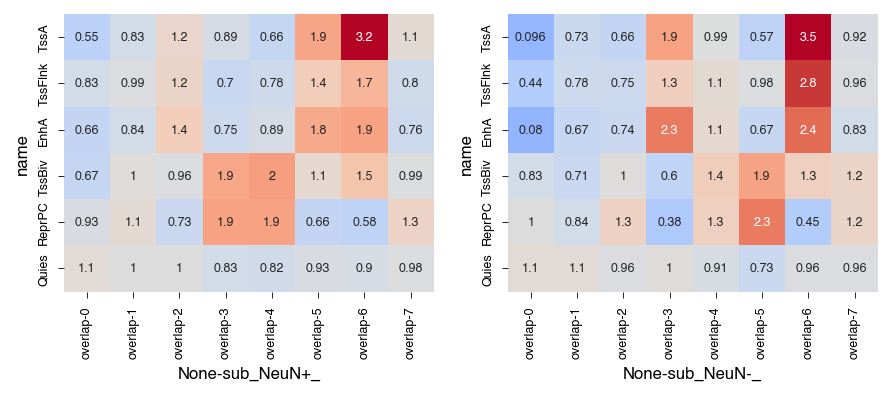

In [28]:
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(7, 3))

for i, ct in enumerate(['NeuN+', 'NeuN-']):
    sns.heatmap(hmm_frac[ct], annot=True, cmap='coolwarm', 
                center=1, vmin=0.075, vmax=3, 
                cbar=False, square=True,
                annot_kws={'fontsize': 6}, ax=axs[i])

In [ ]:
import plotly.express as px
import matplotlib as mpl

import plotly.io as pio
pio.renderers.default = 'notebook'


df = sub[['chrom', 'start', 'end', 'sub_NeuN+', 'sub_NeuN-']]
# add rao2014 data
df = df.loc[(df['sub_NeuN+'] != N_comp) & (df['sub_NeuN-'] != N_comp)]
df = bf.overlap(df, rao_sub)\
        .drop_duplicates(subset=['chrom', 'start', 'end'])\
        .drop(columns=['chrom_', 'start_', 'end_'])\
        .rename(columns={'sub_rao2014_': 'sub_rao2014'})\
        .dropna()\
        .reset_index(drop=True)
cmap = mpl.cm.get_cmap('seismic')
fig = px.parallel_categories(df[['sub_NeuN+', 'sub_NeuN-', 'sub_rao2014']], 
                             color='sub_NeuN-', 
                             color_continuous_scale ='balance')

fig.show()

In [76]:
hmm_frac_k27 = {}

for ct in ['NeuN+', 'NeuN-']:
    hmm_k27 = bf.overlap(
        sub,
        chrom_hmm[ct],
        return_overlap=True, 
        how='left'
    )
    #.groupby(['chrom', 'start', 'end'], as_index=False)
    hmm_k27['overlap'] = hmm_k27['overlap_end'] - hmm_k27['overlap_start']
    hmm_frac_k27[ct] = hmm_k27.loc[hmm_k27['name_'].isin(['ReprPC', 'TssBiv']), 
                                   ['chrom', 'start', 'end', 'overlap']]\
        .groupby(['chrom', 'start', 'end'], as_index=False).sum()
    
    hmm_frac_k27[ct]['frac'] = hmm_frac_k27[ct]['overlap'] / 100_000
#     subc_freq = hmm_frac[ct].sum(axis=0) / hmm_frac[ct].sum().sum()
#     hmm_frac[ct] = hmm_frac[ct].div(hmm_frac[ct].sum(axis=1), axis=0)
#     hmm_frac[ct] = hmm_frac[ct].div(subc_freq.values, axis=1)
#     hmm_frac[ct] = hmm_frac[ct].loc[['TssA', 'TssFlnk', 'EnhA', 'TssBiv', 'ReprPC', 'Quies']] # reorder states
    
hmm_frac_k27[ct]

chrom      start        end  overlap   frac
0      chr1     800000     900000    29800  0.298
1      chr1     900000    1000000    63200  0.632
2      chr1    1000000    1100000    19000   0.19
3      chr1    1100000    1200000    15600  0.156
4      chr1    1200000    1300000     7800  0.078
...     ...        ...        ...      ...    ...
17513  chr9  137800000  137900000    20800  0.208
17514  chr9  137900000  138000000    58800  0.588
17515  chr9  138000000  138100000    61600  0.616
17516  chr9  138100000  138200000    60800  0.608
17517  chr9  138200000  138300000    21400  0.214

[17518 rows x 5 columns]

(array([6599., 2720., 1888., 1508., 1208., 1031.,  888.,  702.,  635.,
         339.]),
 array([0.002, 0.1018, 0.2016, 0.3014, 0.4012, 0.501, 0.6008, 0.7006,
        0.8004, 0.9002, 1.0], dtype=object),
 <BarContainer object of 10 artists>)

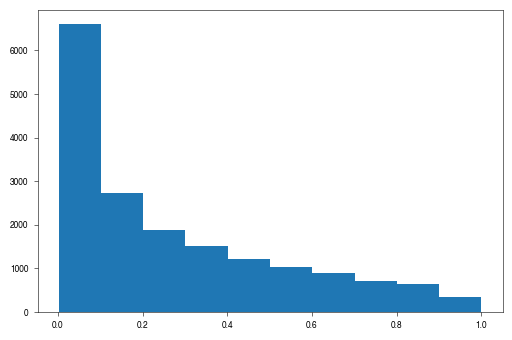

In [77]:
plt.figure(dpi=100)
plt.hist(hmm_frac_k27['NeuN-']['frac'])

In [80]:
df = sub[['chrom', 'start', 'end', 'sub_NeuN+', 'sub_NeuN-']]
# add rao2014 data
df = df.loc[(df['sub_NeuN+'] != 5) & (df['sub_NeuN-'] != 5)]
df = bf.overlap(
    df, 
    hmm_frac_k27['NeuN-'].loc[hmm_frac_k27['NeuN-']['frac'] > 0.4],
    how='inner'
)
df = bf.overlap(df, rao_sub)\
        .drop_duplicates(subset=['chrom', 'start', 'end'])\
        .drop(columns=['chrom_', 'start_', 'end_'])\
        .rename(columns={'sub_rao2014_': 'sub_rao2014'})\
        .dropna()\
        .reset_index(drop=True)
cmap = mpl.cm.get_cmap('seismic')
fig = px.parallel_categories(df[['sub_NeuN+', 'sub_NeuN-', 'sub_rao2014']], 
                             color='sub_NeuN-', 
                             color_continuous_scale ='balance')

fig.show()

In [ ]:
hmm_reg = {}

for ct in ['NeuN+', 'NeuN-']:
    hmm_sub = bf.overlap(
        sub,
        chrom_hmm[ct],
        return_overlap=True, 
        how='left'
    )
    hmm_sub['overlap'] = hmm_sub['overlap_end'] - hmm_sub['overlap_start']
    hmm_reg[ct] = hmm_sub[['chrom', 'start', 'end', 'name', f'sub_{ct}_', 'overlap']]\
        .groupby(['chrom', 'start', 'end', 'name', f'sub_{ct}_'], as_index=False).sum()\
#         .pivot(index='name', columns=f'sub_{ct}_')

#     subc_freq = hmm_frac[ct].sum(axis=0) / hmm_frac[ct].sum().sum()
#     hmm_frac[ct] = hmm_frac[ct].div(hmm_frac[ct].sum(axis=1), axis=0)
#     hmm_frac[ct] = hmm_frac[ct].div(subc_freq.values, axis=1)
#     hmm_frac[ct] = hmm_frac[ct].loc[['TssA', 'TssFlnk', 'EnhA', 'TssBiv', 'ReprPC', 'Quies']] # reorder states
    
hmm_reg['NeuN+']

### chromHMM enrichment in other cell-type subcompartments

In [22]:
hmm_frac = {}
sub_ct = {"NeuN+": 'NeuN-', "NeuN-": "NeuN+"}

for ct in ['NeuN+', 'NeuN-']:
    hmm_sub = bf.overlap(
        chrom_hmm[ct],
        sub,
        return_overlap=True, 
        how='inner'
    )
    hmm_sub['overlap'] = hmm_sub['overlap_end'] - hmm_sub['overlap_start']
    hmm_frac[ct] = hmm_sub[['name', f'sub_{sub_ct[ct]}_', 'overlap']]\
        .groupby(['name', f'sub_{sub_ct[ct]}_'], as_index=False).sum()\
        .pivot(index='name', columns=f'sub_{sub_ct[ct]}_')

    subc_freq = hmm_frac[ct].sum(axis=0) / hmm_frac[ct].sum().sum()
    hmm_frac[ct] = hmm_frac[ct].div(hmm_frac[ct].sum(axis=1), axis=0)
    hmm_frac[ct] = hmm_frac[ct].div(subc_freq.values, axis=1)
    hmm_frac[ct] = hmm_frac[ct].loc[['TssA', 'TssFlnk', 'EnhA', 'TssBiv', 'ReprPC', 'Quies']] # reorder states
    
hmm_frac['NeuN+']

overlap                                                  
sub_NeuN-_         0         1         2         3         4         5
name                                                                  
TssA        0.295365  0.695488  1.707315  0.748590  3.021685  0.838860
TssFlnk     0.446450  0.723078  1.979363  0.686177  1.804945  0.685037
EnhA        0.612404  0.836686  1.287191  1.302976  1.884174  0.616124
TssBiv      0.548018  1.230325  1.211724  1.458125  1.387910  0.910451
ReprPC      0.994620  1.393617  0.634977  1.452678  0.549905  1.297344
Quies       1.084702  0.945440  1.005758  0.865345  0.912822  0.997250

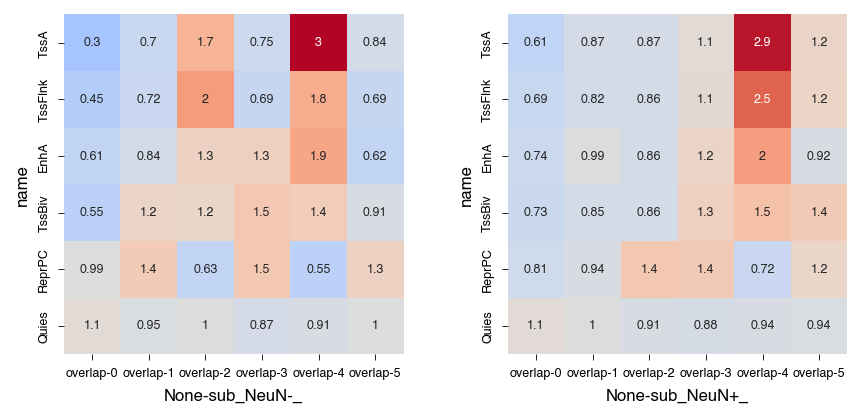

In [23]:
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(7, 3))

for i, ct in enumerate(['NeuN+', 'NeuN-']):
    sns.heatmap(hmm_frac[ct], annot=True, cmap='coolwarm', 
                center=1, vmin=0.075, vmax=3, 
                cbar=False, square=True,
                annot_kws={'fontsize': 6}, ax=axs[i])

## Work with NeuN- region covered by compartment 2

In [79]:
sub.loc[sub['sub_NeuN-'] == 2]

chrom     start       end  sub_NeuN+  sub_NeuN-
484     chr1  48400000  48500000          3          2
485     chr1  48500000  48600000          3          2
504     chr1  50400000  50500000          3          2
505     chr1  50500000  50600000          3          2
506     chr1  50600000  50700000          3          2
...      ...       ...       ...        ...        ...
28115  chr21  33200000  33300000          1          2
28116  chr21  33300000  33400000          1          2
28118  chr21  33500000  33600000          1          2
28119  chr21  33600000  33700000          1          2
28143  chr21  36000000  36100000          1          2

[6302 rows x 5 columns]

In [88]:
# load gene expression
riz_cnts = pd.read_pickle('../2022.10.07/rizzardi.logTPM_counts.pkl')

# Add DE info
riz_deseq_res = pd.read_table('../2022.10.07/rizzardi.DEseq2_results.tsv', 
                              usecols=['gene', 'log2FoldChange', 'padj'])\
    .rename(columns={'log2FoldChange': 'log2FC'})
riz_pc_cnts = riz_cnts\
    .loc[riz_cnts['gene.type'] == 'protein_coding']\
    .merge(riz_deseq_res, left_on='gene.id', right_on='gene', how='inner')\
    .drop(columns='gene')
riz_pc_cnts['mid_start'] = (riz_pc_cnts['start'] + riz_pc_cnts['end']) // 2
riz_pc_cnts['mid_end'] = riz_pc_cnts['mid_start'] + 1
riz_pc_cnts['tss_start'] = riz_pc_cnts[['start', 'end', 'strand']]\
    .apply(lambda row: row['start'] if row['strand'] == "+" else row['end'] - 1, axis=1)
riz_pc_cnts['tss_end'] = riz_pc_cnts['tss_start'] + 1

print(riz_pc_cnts.shape)
riz_pc_cnts.head()

(19941, 15)


chrom      start        end gene.name strand          gene.id  \
0   chrX  100627107  100639991    TSPAN6      -  ENSG00000000003   
1   chrX  100584935  100599885      TNMD      +  ENSG00000000005   
2  chr20   50934866   50959140      DPM1      -  ENSG00000000419   
3   chr1  169849630  169894267     SCYL3      -  ENSG00000000457   
4   chr1  169662006  169854080  C1orf112      +  ENSG00000000460   

        gene.type  log2TPM_NeuN+  log2TPM_NeuN-    log2FC          padj  \
0  protein_coding       0.698059       2.883887 -3.523806  1.515735e-09   
1  protein_coding       0.421484       0.253933  0.981864  2.580295e-01   
2  protein_coding       3.425938       3.225108  0.291221  3.556893e-01   
3  protein_coding       2.632269       2.694000 -0.089339  7.819347e-01   
4  protein_coding       0.405074       0.687128 -0.593957  1.043098e-01   

   mid_start    mid_end  tss_start    tss_end  
0  100633549  100633550  100639990  100639991  
1  100592410  100592411  100584935  100584936  
2   50947003   50947004   50959139   50959140  
3  169871948  169871949  169894266  169894267  
4  169758043  169758044  169662006  169662007

In [33]:
# comp2 = sub.loc[sub['sub_NeuN-'] == 2]
df = bf.overlap(riz_pc_cnts, sub, how='inner', 
                cols1=['chrom', 'mid_start', 'mid_end'])
df = df.loc[df['padj'] < 0.05]
df['sub_grp'] = df['sub_NeuN-_'].apply(lambda sub: '2' if sub == 2 else 'other')
df['logFC_grp'] = df['log2FC'].apply(lambda fc: '>0' if fc > 0 else '<0')
df

chrom      start        end gene.name strand          gene.id  \
5      chr22   17084953   17115693    IL17RA      +  ENSG00000177663   
6      chr22   17116296   17121367  TMEM121B      -  ENSG00000183307   
7      chr22   17137510   17165287     HDHD5      -  ENSG00000069998   
8      chr22   17178789   17258235      ADA2      -  ENSG00000093072   
9      chr22   17359948   17558151     CECR2      +  ENSG00000099954   
...      ...        ...        ...       ...    ...              ...   
19079  chr10  133394093  133422520      MTG1      +  ENSG00000148824   
19080  chr10  133420665  133424625      SPRN      -  ENSG00000203772   
19081  chr10  133453927  133523558    SCART1      +  ENSG00000214279   
19082  chr10  133520405  133561220    CYP2E1      +  ENSG00000130649   
19083  chr10  133553900  133569835     SYCE1      -  ENSG00000171772   

            gene.type  log2TPM_NeuN+  log2TPM_NeuN-    log2FC           padj  \
5      protein_coding       3.012406       4.152596 -1.087712   1.132661e-04   
6      protein_coding       5.070000       2.869859  1.936608   3.026855e-06   
7      protein_coding       2.504481       1.893395  0.643459   4.278718e-02   
8      protein_coding       0.148130       1.523274 -4.623996   1.706372e-18   
9      protein_coding       0.456634       5.103481 -6.325980  4.874502e-124   
...               ...            ...            ...       ...            ...   
19079  protein_coding       3.022583       4.361886 -1.368196   1.420609e-07   
19080  protein_coding       6.694316       2.893159  3.824841   9.763370e-33   
19081  protein_coding       2.395210       3.011590 -0.645878   4.132562e-02   
19082  protein_coding       3.179885       2.256021  1.017960   2.734260e-04   
19083  protein_coding       6.283029       2.973739  3.652359   5.559051e-31   

       mid_start    mid_end chrom_     start_       end_  sub_NeuN+_  \
5       17100323   17100324  chr22   17100000   17200000           2   
6       17118831   17118832  chr22   17100000   17200000           2   
7       17151398   17151399  chr22   17100000   17200000           2   
8       17218512   17218513  chr22   17200000   17300000           2   
9       17459049   17459050  chr22   17400000   17500000           2   
...          ...        ...    ...        ...        ...         ...   
19079  133408306  133408307  chr10  133400000  133500000           4   
19080  133422645  133422646  chr10  133400000  133500000           4   
19081  133488742  133488743  chr10  133400000  133500000           4   
19082  133540812  133540813  chr10  133500000  133600000           4   
19083  133561867  133561868  chr10  133500000  133600000           4   

       sub_NeuN-_ sub_grp logFC_grp  
5               1   other        <0  
6               1   other        >0  
7               1   other        >0  
8               1   other        <0  
9               1   other        <0  
...           ...     ...       ...  
19079           3   other        <0  
19080           3   other        >0  
19081           3   other        <0  
19082           3   other        >0  
19083           3   other        >0  

[8160 rows x 20 columns]

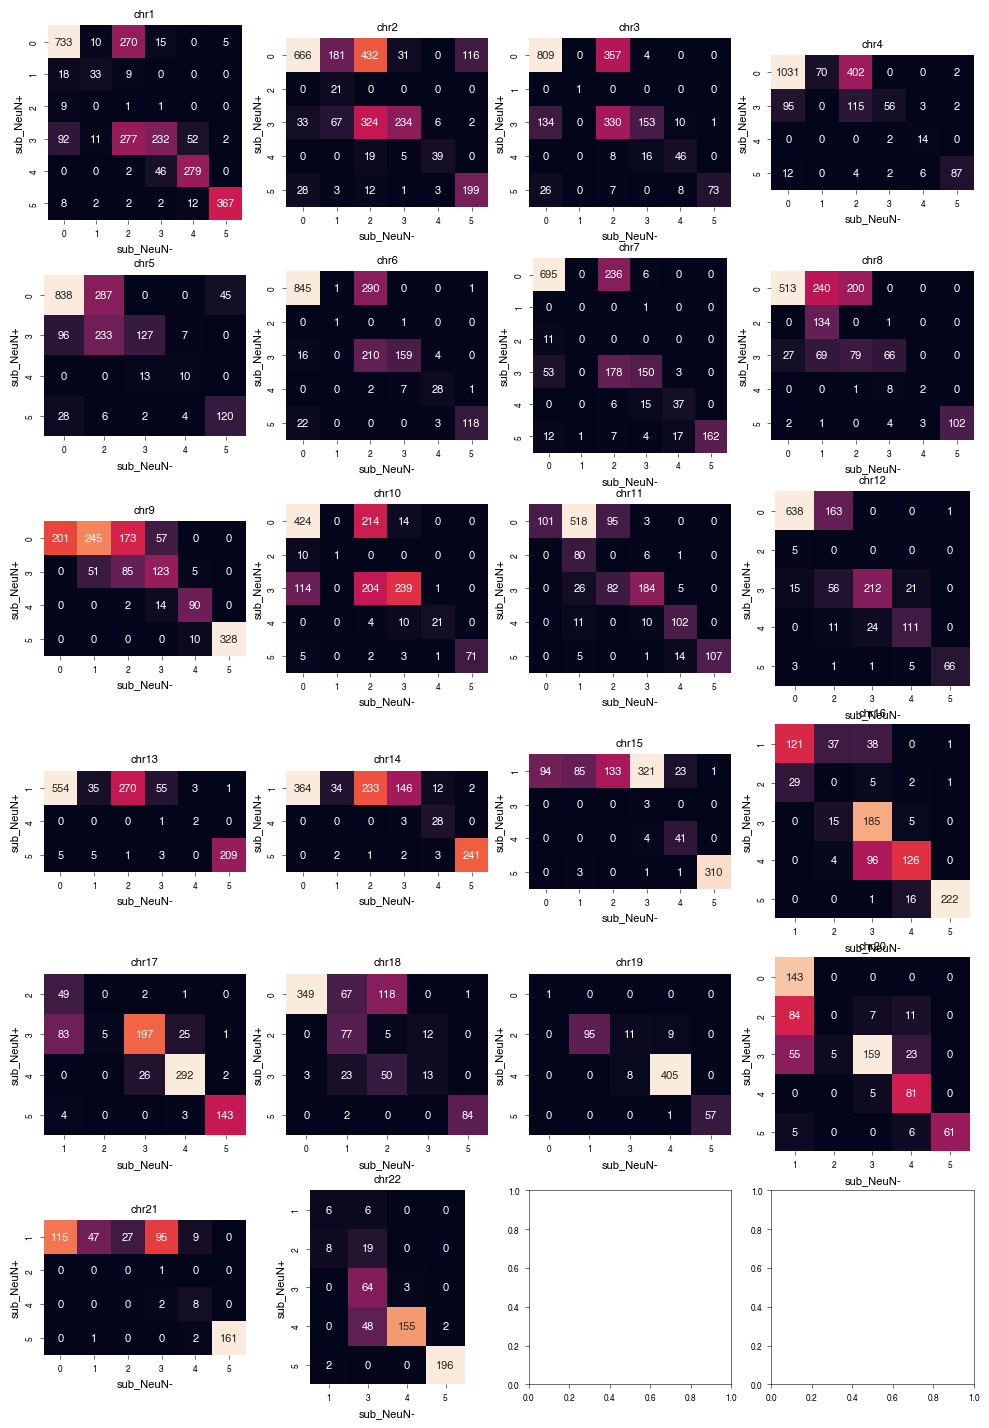

In [106]:
# Number of bins for each pair of subcompartments (per-chromosome)
chromnames = sub['chrom'].unique()

fig, axs = plt.subplots(6, 4, dpi=100, figsize=(12, 18))
for i, chrom in enumerate(chromnames):
    ax = axs[i // 4, i % 4]
    df = sub.loc[sub['chrom'] == chrom]
    sns.heatmap(pd.crosstab(df['sub_NeuN+'], df['sub_NeuN-']), 
                annot=True, fmt='.0f', square=True, ax=ax, cbar=False)
    ax.set_title(chrom)


<AxesSubplot:xlabel='sub_NeuN-_', ylabel='sub_NeuN+_'>

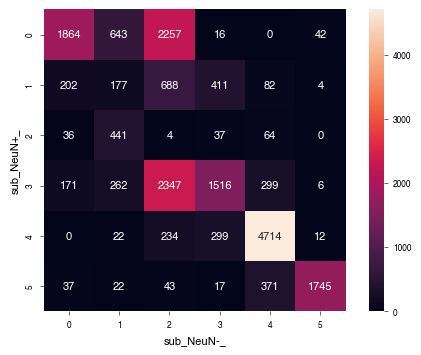

In [90]:
df = bf.overlap(riz_pc_cnts, sub, how='inner', 
                cols1=['chrom', 'tss_start', 'tss_end'])
map_all = pd.crosstab(df['sub_NeuN+_'], df['sub_NeuN-_'])

plt.figure(dpi=100)
sns.heatmap(map_all, annot=True, fmt='.0f', square=True)

<AxesSubplot:xlabel='sub_NeuN-_', ylabel='sub_NeuN+_'>

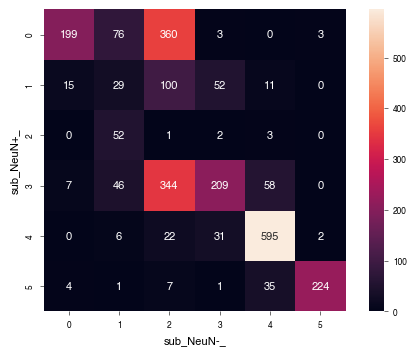

In [93]:
df = bf.overlap(riz_pc_cnts, sub, how='inner', 
                cols1=['chrom', 'tss_start', 'tss_end'])
df = df.loc[(df['padj'] < 0.05) & (df['log2FC'] < -1.5)]

plt.figure(dpi=100)
sns.heatmap(pd.crosstab(df['sub_NeuN+_'], df['sub_NeuN-_']), annot=True, 
            fmt='.0f', square=True)

<AxesSubplot:xlabel='sub_NeuN-_', ylabel='sub_NeuN+_'>

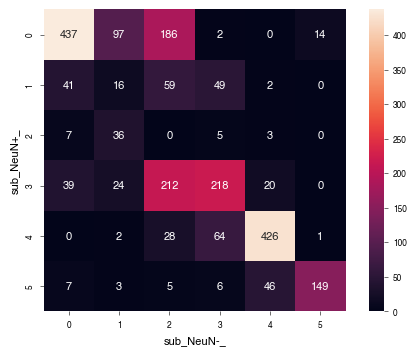

In [92]:
df = bf.overlap(riz_pc_cnts, sub, how='inner', 
                cols1=['chrom', 'tss_start', 'tss_end'])
df = df.loc[(df['padj'] < 0.05) & (df['log2FC'] > 1.5)]

plt.figure(dpi=100)
sns.heatmap(pd.crosstab(df['sub_NeuN+_'], df['sub_NeuN-_']), annot=True, 
            fmt='.0f', square=True)